# Python Notebook

In [60]:
## Function to prepare datatables (cleaning and hyperlinking, adding tool tips, etc) input for the database qmds
import sys, os
import pandas as pd
# Change working directory to ConnectomeDB
project_root = "/Users/sakuramaezono/Library/CloudStorage/OneDrive-YokohamaCityUniversity/Personal/05_Python_repositories/ConnectomeDB"
os.chdir(project_root)
sys.path.append(os.path.abspath("src"))

In [61]:
project_root

'/Users/sakuramaezono/Library/CloudStorage/OneDrive-YokohamaCityUniversity/Personal/05_Python_repositories/ConnectomeDB'

In [62]:
import os
import jinja2
import sys
import pandas as pd
import numpy as np
import time
import base64
import re


sys.path.append(os.path.abspath("src"))
import fetchGSheet
from createDataTable import pop_up_info, gene_pair0, generate_perplexity_links, gene_pair00
from createFunctionalAnnotTable import gene_pair_annot_ligand, gene_pair_annot_receptor

# Paths
TEMPLATE_PATH = 'HTML/cardwithPMIDTemplate.html'
OUTPUT_DIR = 'data/cards/'


#### Bring in PMID details ####

# Load PubMed data
pubmed_data = pd.read_csv("data/pubmed_results.csv")
pubmed_data["Year"] = pubmed_data["Year"].astype(str).str.replace(".0",
                                                                  "",
                                                                  regex=False).astype(int)
test_genes = ["VEGFA KDR", "ADAM17 IL6R"]
pubmed_data["PMID"] = pubmed_data["PMID"].astype(str)

# add llm results
bio_keywords = pd.read_csv("data/llm_results.csv")
gene_pair00["Human LR Pair"] = gene_pair00["Human LR Pair"].str.replace("——", " ")

gene_pair00=gene_pair00[gene_pair00["Human LR Pair"].isin(test_genes)]
# Replace spaces in "Human LR Pair" with a placeholder
gene_pair00["Human LR Pair"] = gene_pair00["Human LR Pair"].str.replace(" ", "——")
gene_pair000 = gene_pair00.merge(bio_keywords, how='left', left_on="Human LR Pair", right_on='Human LR Pair')
gene_pair000["Relevance Keywords"] = gene_pair000["Relevance Keywords"].astype(str)
gene_pair000["Human LR Pair"] = gene_pair000["Human LR Pair"].astype(str)
pubmed_data = pubmed_data.reset_index(drop=True)  # Remove the index


#################################################################################################
#### Bring in original card info ####
# Add Disease (specific) to cards
df= pd.read_csv("data/disease_annotations_per_pair.csv")
df = df.groupby('interaction')['disease'].apply(', '.join).reset_index()
# Map and set to unknown for now
mapping = dict(zip(df['interaction'],df['disease']))
gene_pair0["Disease"] = gene_pair0['Human LR Pair'].map(mapping).fillna("unknown")

gene_pair0 = generate_perplexity_links(
    gene_pair0,
    pathway_col="Disease",
    default_query_template="What-diseases-is-the-ligand-receptor-pair-{pair}-associated-with"
)

# if only one replace gene_pair0 to e.g.
gene_pair_input = gene_pair0[gene_pair0["Human LR Pair"].isin(test_genes)]
#gene_pair_input = gene_pair0

# add external link icon

icon_html = '<i class="fa-solid fa-arrow-up-right-from-square" style="margin-left:4px;"></i></a>'
columns_to_update = [
    "KEGG Pathway", "PROGENy Pathway", "Cancer-related",
    "Disease Type", "Disease"
]

for col in columns_to_update:
    gene_pair_input[col] = gene_pair_input[col].str.replace(
        "</a>", icon_html, regex=False
    )

# add Ligand/Receptor group info
agg_func = lambda x: ', '.join(sorted(set(map(str, x))))
gene_pair_annot_ligand = gene_pair_annot_ligand.groupby('Ligand HGNC ID').agg(agg_func).reset_index()
ligand_mapping = dict(zip(gene_pair_annot_ligand['Ligand HGNC ID'],gene_pair_annot_ligand['Ligand group']))
gene_pair_annot_receptor = gene_pair_annot_receptor.groupby('Receptor HGNC ID').agg(agg_func).reset_index()
receptor_mapping = dict(zip(gene_pair_annot_receptor['Receptor HGNC ID'],gene_pair_annot_receptor['Receptor group']))


def load_template(template_path):
    """Load Jinja2 template from a file."""
    with open(template_path, 'r') as file:
        return jinja2.Template(file.read())

def encode_image(image_path):
    """Encode an image to base64."""
    try:
        with open(image_path, "rb") as image_file:
            return base64.b64encode(image_file.read()).decode('utf-8')
    except FileNotFoundError:
        return None

# Function to extract the HGNC ID from the anchor tag URL
def extract_hgnc_id(col):
    """Use regular expression to extract the HGNC ID after 'HGNC:'."""
    match = re.search(r'HGNC:(\d+)', col)
    if match:
        return match.group(1)  # Return the HGNC ID (number part)
    return None  # Return None if the format doesn't match or it's not a string

# Updated functions to convert the HGNC link (using extract_hgnc_id)
def convert_hgnc_url(col):
    hgnc_id = extract_hgnc_id(col)  # Extract the HGNC ID
    if hgnc_id:
        visible_text = 'GeneCards <i class="fa-solid fa-arrow-up-right-from-square" style="margin-left: 4px;"></i>'
        new_link = (
            f'<a href="https://www.genecards.org/cgi-bin/carddisp.pl?id_type=hgnc&id={hgnc_id}" '
            f'target="_blank" style="color: #0000EE; text-decoration: underline;">{visible_text}</a>'
        )
        return new_link
    return None

def convert_hgnc_url_disease(col):
    hgnc_id = extract_hgnc_id(col)  # Extract the HGNC ID
    if hgnc_id:
        visible_text = 'MalaCards <i class="fa-solid fa-arrow-up-right-from-square" style="margin-left: 4px;"></i>'
        new_link = f'<a href="https://www.genecards.org/cgi-bin/carddisp.pl?id_type=hgnc&id={hgnc_id}#diseases" target="_blank">{visible_text}</a>'
        return new_link
    return None

def convert_hgnc_url_exp(col):
    hgnc_id = extract_hgnc_id(col)  # Extract the HGNC ID
    if hgnc_id:
        visible_text = 'mRNA expression in normal human tissues <i class="fa-solid fa-arrow-up-right-from-square" style="margin-left: 4px;"></i>'
        new_link = f'<a href="https://www.genecards.org/cgi-bin/carddisp.pl?id_type=hgnc&id={hgnc_id}#expression" target="_blank">{visible_text}</a>'
        return new_link
    return None

def prepare_dataframes(gene_pair_input):
    """Prepare interaction, ligand, and receptor dataframes."""
    # DBlength = len(gene_pair_input)
    # gene_pair_input["Interaction ID"] = [f"CDB{str(i).zfill(4)}" for i in range(1, DBlength + 1)]
    gene_pair_input["Interaction Type"] = [
        f'{ligand} {ligandLocation} ligand binds to {receptor} {receptorLocation} receptor'
        for ligand, ligandLocation, receptor, receptorLocation in zip(
            gene_pair_input["Ligand"], gene_pair_input["Ligand Location"],
            gene_pair_input["Receptor"], gene_pair_input["Receptor Location"]
        )
    ]
    interaction_card = gene_pair_input[["Interaction ID", "Human LR Pair", "Interaction Type", "Perplexity", "PMID", "KEGG Pathway",  "PROGENy Pathway", "Cancer-related", "Disease Type", "Disease"]]
    interaction_card["Perplexity"] = interaction_card["Perplexity"].str.replace('size=30', 'size=80')

    pop_up_info_lim = pop_up_info[
        ["Approved symbol", "Alias symbol", "Previous symbol", "Date symbol changed"]
    ].drop_duplicates(subset="Approved symbol", keep="first")

    def format_symbol_aliases(old_symbol, aliases):
        # Filter out "N/A" values
        parts = [p for p in (old_symbol, aliases) if p != "N/A"]
        # Return just the symbol if no valid aliases or old symbols
        return f"{', '.join(parts)}" if parts else aliases

    pop_up_info_lim['Other Symbols'] =pop_up_info_lim.apply(
        lambda row: format_symbol_aliases(row["Previous symbol"], row["Alias symbol"]),
        axis=1
    )

    ligand_card = gene_pair_input[["Human LR Pair", "Ligand", "Ligand name", "Ligand HGNC ID", "Ligand MGI ID", "Ligand RGD ID", "Ligand Location"]].merge(
        pop_up_info_lim, how='left', left_on='Ligand', right_on='Approved symbol'
    ).drop_duplicates(subset='Human LR Pair', keep="first").drop(columns=["Ligand", "Approved symbol"])

    ligand_card_1 = ligand_card[["Human LR Pair", "Ligand name", "Other Symbols" ]]
    ligand_card_2 = ligand_card[["Human LR Pair", "Ligand HGNC ID", "Ligand Location"]]
    # Convert links
    ligand_card_2["HGNC gene card"] = ligand_card_2["Ligand HGNC ID"].apply(convert_hgnc_url)
    ligand_card_2["Disease relevance"] = ligand_card_2["Ligand HGNC ID"].apply(convert_hgnc_url_disease)
    ligand_card_2["Expression Profile"] = ligand_card_2["Ligand HGNC ID"].apply(convert_hgnc_url_exp)
    # Add ligand group
    ligand_card_2["Lineage group"] = ligand_card_2['Ligand HGNC ID'].map(ligand_mapping).fillna("none")
    icon_html = '<i class="fa-solid fa-arrow-up-right-from-square" style="margin-left:4px;"></i></a>'
    columns_to_update = ["Ligand HGNC ID"]

    for col in columns_to_update:
        ligand_card_2[col] = ligand_card_2[col].str.replace(
            "</a>", icon_html, regex=False
        )
    # Add extra line to balance out cards if necessary
    def add_spacing(text):
        if len(text) <= 60:
            return f"{text}<br><br>"  # extra line for short text
        else:
            return f"{text}"      # no extra line for long text


    #ligand_card_2["Lineage group"] = ligand_card_2["Lineage group"].apply(add_spacing)
    ligand_card_2 = ligand_card_2[["Human LR Pair", "Ligand HGNC ID", "HGNC gene card", "Ligand Location", "Lineage group", "Disease relevance", "Expression Profile"]]


    receptor_card = gene_pair_input[["Human LR Pair", "Receptor", "Receptor name", "Receptor HGNC ID", "Receptor MGI ID", "Receptor RGD ID", "Receptor Location"]].merge(
        pop_up_info_lim, how='left', left_on='Receptor', right_on='Approved symbol'
    ).drop_duplicates(subset='Human LR Pair', keep="first").drop(columns=["Receptor", "Approved symbol"])

    receptor_card_1 = receptor_card[["Human LR Pair", "Receptor name", "Other Symbols"]]
    receptor_card_2 = receptor_card[["Human LR Pair", "Receptor HGNC ID", "Receptor Location"]]
    receptor_card_2["HGNC gene card"] = receptor_card_2["Receptor HGNC ID"].apply(convert_hgnc_url)
    receptor_card_2["Disease relevance"] = receptor_card_2["Receptor HGNC ID"].apply(convert_hgnc_url_disease)
    receptor_card_2["Expression Profile"] = receptor_card_2["Receptor HGNC ID"].apply(convert_hgnc_url_exp)
    # Add Receptor group
    receptor_card_2["Lineage group"] = receptor_card_2['Receptor HGNC ID'].map(receptor_mapping).fillna("none")
    icon_html = '<i class="fa-solid fa-arrow-up-right-from-square" style="margin-left:4px;"></i></a>'
    columns_to_update = ["Receptor HGNC ID"]

    for col in columns_to_update:
        receptor_card_2[col] = receptor_card_2[col].str.replace(
            "</a>", icon_html, regex=False
        )
    # Add extra line to balance out cards if necessary
    #receptor_card_2["Lineage group"] = receptor_card_2["Lineage group"].apply(add_spacing)
    receptor_card_2 = receptor_card_2[["Human LR Pair", "Receptor HGNC ID",  "HGNC gene card", "Receptor Location", "Lineage group", "Disease relevance", "Expression Profile" ]]

    return interaction_card, ligand_card_1, ligand_card_2, receptor_card_1, receptor_card_2


def generate_combined_html_files(
    gene_pair_keywords_df, # Renamed df to be more descriptive
    template,
    interaction_card_df, # Renamed to avoid confusion with internal loop var
    ligand_card_1_df,
    receptor_card_1_df,
    ligand_card_2_df,
    receptor_card_2_df,
    pubmed_data_df, # Renamed to avoid confusion with internal loop var
    gene_pair_main_df, # Renamed gene_pair_df
    output_dir
):
    os.makedirs(output_dir, exist_ok=True)

    # Use the 'Human LR Pair' from the gene_pair_keywords_df for iteration
    for idx, row in gene_pair_keywords_df.iterrows():
        lr_pair_name = row["Human LR Pair"] # This is the gene_name (e.g., VEGFA——KDR)
        keywords = row["Relevance Keywords"] # Keywords from llm_results
        pmids_str = row["PMID"] # PMIDs associated with this LR Pair

        # Split LR Pair for file naming and data filtering
        value1, value2 = lr_pair_name.replace("——", " ").split()

        # Data rows for each section, filtered by the current LR Pair
        row0 = interaction_card_df[interaction_card_df['Human LR Pair'] == lr_pair_name]
        row1 = ligand_card_1_df[ligand_card_1_df['Human LR Pair'] == lr_pair_name]
        row2 = receptor_card_1_df[receptor_card_1_df['Human LR Pair'] == lr_pair_name]
        row3 = ligand_card_2_df[ligand_card_2_df['Human LR Pair'] == lr_pair_name]
        row4 = receptor_card_2_df[receptor_card_2_df['Human LR Pair'] == lr_pair_name]

                # make the pair cards here
        def convert_pair_url(df_pairs):
            df_pairs["Human LR Pair"] = [
                f'<a href="https://comp.med.yokohama-cu.ac.jp/collab/connectomeDB/cards/{lrpair}.html" target="_blank" '
                f'title="Open {lrpair} card" style="color: #0000EE; text-decoration: underline;">'
                f'{lrpair}</a>'
                if pd.notna(lrpair) and lrpair.strip() else ""
                for lrpair in df_pairs["Human LR Pair"]
            ]
            return df_pairs


        # Related ligand pairs
        ligand_pairs = gene_pair_main_df[gene_pair_main_df['Ligand'] == value1]
        ligand_pairs = ligand_pairs[ligand_pairs["Human LR Pair"].str.replace(" ", "——") != lr_pair_name] # Ensure comparison with placeholder
        ligand_pairs = convert_pair_url(ligand_pairs[["Human LR Pair"]])
        ligand_pairs_str = ' ・ '.join([btn for btn in ligand_pairs["Human LR Pair"] if btn])

        # Related receptor pairs
        receptor_pairs = gene_pair_main_df[gene_pair_main_df['Receptor'] == value2]
        receptor_pairs = receptor_pairs[receptor_pairs["Human LR Pair"].str.replace(" ", "——") != lr_pair_name] # Ensure comparison with placeholder
        receptor_pairs = convert_pair_url(receptor_pairs[["Human LR Pair"]])
        receptor_pairs_str = ' ・ '.join([btn for btn in receptor_pairs["Human LR Pair"] if btn])
        
        # Prepare table data (convert to dict)
        table0_data = row0.drop('Human LR Pair', axis=1).to_dict(orient='records')[0] if not row0.empty else {}
        table1_data = row1.drop('Human LR Pair', axis=1).to_dict(orient='records')[0] if not row1.empty else {}
        table2_data = row2.drop('Human LR Pair', axis=1).to_dict(orient='records')[0] if not row2.empty else {}
        table3_data = row3.drop('Human LR Pair', axis=1).to_dict(orient='records')[0] if not row3.empty else {}
        table4_data = row4.drop('Human LR Pair', axis=1).to_dict(orient='records')[0] if not row4.empty else {}
        # PMID stuff
        tab_headers = []
        tab_contents = []
        sources = [pmid.strip() for pmid in str(pmids_str).split(',') if pmid.strip()]

        if sources:
            for i, pmid in enumerate(sources):
                pubmed_row = pubmed_data_df[pubmed_data_df["PMID"] == pmid]

                if not pubmed_row.empty:
                    title = pubmed_row["Title"].values[0]
                    abstract = pubmed_row["Abstract"].values[0]
                    journal = pubmed_row["Journal"].values[0]
                    year = pubmed_row["Year"].values[0]
                else:
                    title = "No Title Found"
                    abstract = "No Abstract Found"
                    journal = "Journal Unknown"
                    year = "Year Unknown"

                active_class = "active" if i == 0 else ""
                tab_headers.append(f'<button class="tablinks {active_class}" onclick="openTab(event, \'tab{pmid}\')">{pmid}</button>')
                tab_contents.append(f"""
                <div id="tab{pmid}" class="tabcontent {active_class}">
                    <h2>{title}</h2>
                    <p><strong>{journal}, {year}; <a href="https://pubmed.ncbi.nlm.nih.gov/{pmid}/" target="_blank">For more details, see PubMed</a></strong></p>
                    <p>{abstract}</p>

                </div>
                """)

        # Assuming you have images for ligand and receptor or they are not needed in the template
        # If you intend to use them, define them here, e.g.:
        ligand_image = encode_image("path/to/ligand_image.png") # Replace with actual path
        receptor_image = encode_image("path/to/receptor_image.png") # Replace with actual path

        # Render the template with all data
        rendered_content = template.render(
            gene_name=lr_pair_name.replace("——", " "), # Pass the human-readable pair name
            value1=value1,
            value2=value2,
            table0_data=table0_data,
            table1_data=table1_data,
            table2_data=table2_data,
            table3_data=table3_data,
            table4_data=table4_data,
            ligand_image=ligand_image,
            receptor_image=receptor_image,
            ligand_pairs=ligand_pairs_str,
            receptor_pairs=receptor_pairs_str,
            tab_headers="".join(tab_headers),
            tab_contents="".join(tab_contents),
            keywords=keywords
        )

        output_file = os.path.join(output_dir, f"{value1} {value2}.html")
        with open(output_file, 'w', encoding='utf-8') as file:
            file.write(rendered_content)

if __name__ == "__main__":
    # Prepare dataframes
    interaction_card, ligand_card_1, ligand_card_2, receptor_card_1, receptor_card_2 = prepare_dataframes(gene_pair_input.copy())

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_12361/2612187119.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gene_pair00["Human LR Pair"] = gene_pair00["Human LR Pair"].str.replace(" ", "——")
/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_12361/2612187119.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gene_pair_input[col] = gene_pair_input[col].str.replace(
/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_12361/2612187119.py:145: SettingWithCopyWarning: 
A val

In [63]:
template = load_template(TEMPLATE_PATH)

In [64]:
gene_pair_keywords_df=gene_pair000
template=template
interaction_card_df=interaction_card
ligand_card_1_df=ligand_card_1
receptor_card_1_df=receptor_card_1
ligand_card_2_df=ligand_card_2
receptor_card_2_df=receptor_card_2
pubmed_data_df=pubmed_data
gene_pair_main_df=gene_pair0
output_dir=OUTPUT_DIR

In [91]:
gene_pair0_copy

NameError: name 'gene_pair0_copy' is not defined

In [66]:
# Use the 'Human LR Pair' from the gene_pair_keywords_df for iteration
for idx, row in gene_pair_keywords_df.iterrows():
    lr_pair_name = row["Human LR Pair"] # This is the gene_name (e.g., VEGFA——KDR)
    keywords = row["Relevance Keywords"] # Keywords from llm_results
    pmids_str = row["PMID"] # PMIDs associated with this LR Pair

    # Split LR Pair for file naming and data filtering
    value1, value2 = lr_pair_name.replace("——", " ").split()

    # Data rows for each section, filtered by the current LR Pair
    row0 = interaction_card_df[interaction_card_df['Human LR Pair'] == lr_pair_name]
    row1 = ligand_card_1_df[ligand_card_1_df['Human LR Pair'] == lr_pair_name]
    row2 = receptor_card_1_df[receptor_card_1_df['Human LR Pair'] == lr_pair_name]
    row3 = ligand_card_2_df[ligand_card_2_df['Human LR Pair'] == lr_pair_name]
    row4 = receptor_card_2_df[receptor_card_2_df['Human LR Pair'] == lr_pair_name]

    # make the pair cards here
    def convert_pair_url(df_pairs):
        df_pairs["Human LR Pair"] = [
            f'<a href="https://comp.med.yokohama-cu.ac.jp/collab/connectomeDB/cards/{lrpair}.html" target="_blank" '
            f'title="Open {lrpair} card" style="color: #0000EE; text-decoration: underline;">'
            f'{lrpair}</a>'
            if pd.notna(lrpair) and lrpair.strip() else ""
            for lrpair in df_pairs["Human LR Pair"]
        ]
        return df_pairs

    # Related ligand pairs
    ligand_pairs = gene_pair_main_df[gene_pair_main_df['Ligand'] == value1]
    ligand_pairs = ligand_pairs[ligand_pairs["Human LR Pair"].str.replace(" ", "——") != lr_pair_name] # Ensure comparison with placeholder
    ligand_pairs = convert_pair_url(ligand_pairs[["Human LR Pair"]])
    ligand_pairs_str = ' ・ '.join([btn for btn in ligand_pairs["Human LR Pair"] if btn])

    # Related receptor pairs
    receptor_pairs = gene_pair_main_df[gene_pair_main_df['Receptor'] == value2]
    receptor_pairs = receptor_pairs[receptor_pairs["Human LR Pair"].str.replace(" ", "——") != lr_pair_name] # Ensure comparison with placeholder
    receptor_pairs = convert_pair_url(receptor_pairs[["Human LR Pair"]])
    receptor_pairs_str = ' ・ '.join([btn for btn in receptor_pairs["Human LR Pair"] if btn])
    
    # Prepare table data (convert to dict)
    table0_data = row0.drop('Human LR Pair', axis=1).to_dict(orient='records')[0] if not row0.empty else {}
    table1_data = row1.drop('Human LR Pair', axis=1).to_dict(orient='records')[0] if not row1.empty else {}
    table2_data = row2.drop('Human LR Pair', axis=1).to_dict(orient='records')[0] if not row2.empty else {}
    table3_data = row3.drop('Human LR Pair', axis=1).to_dict(orient='records')[0] if not row3.empty else {}
    table4_data = row4.drop('Human LR Pair', axis=1).to_dict(orient='records')[0] if not row4.empty else {}

    # PMID stuff
    tab_headers = []
    tab_contents = []
    sources = [pmid.strip() for pmid in str(pmids_str).split(',') if pmid.strip()]

    if sources:
        for i, pmid in enumerate(sources):
            pubmed_row = pubmed_data_df[pubmed_data_df["PMID"] == pmid]

            if not pubmed_row.empty:
                title = pubmed_row["Title"].values[0]
                abstract = pubmed_row["Abstract"].values[0]
                journal = pubmed_row["Journal"].values[0]
                year = pubmed_row["Year"].values[0]
            else:
                title = "No Title Found"
                abstract = "No Abstract Found"
                journal = "Journal Unknown"
                year = "Year Unknown"

            active_class = "active" if i == 0 else ""
            tab_headers.append(f'<button class="tablinks {active_class}" onclick="openTab(event, \'tab{pmid}\')">{pmid}</button>')
            tab_contents.append(f"""
            <div id="tab{pmid}" class="tabcontent {active_class}">
                <h2>{title}</h2>
                <p><strong>{journal}, {year}; <a href="https://pubmed.ncbi.nlm.nih.gov/{pmid}/" target="_blank">For more details, see PubMed</a></strong></p>
                <p>{abstract}</p>
            </div>
            """)

    # Assuming you have images for ligand and receptor or they are not needed in the template
    # If you intend to use them, define them here, e.g.:
    ligand_image = encode_image("path/to/ligand_image.png") # Replace with actual path
    receptor_image = encode_image("path/to/receptor_image.png") # Replace with actual path

    # Render the template with all data
    rendered_content = template.render(
        gene_name=lr_pair_name.replace("——", " "), # Pass the human-readable pair name
        value1=value1,
        value2=value2,
        table0_data=table0_data,
        table1_data=table1_data,
        table2_data=table2_data,
        table3_data=table3_data,
        table4_data=table4_data,
        ligand_image=ligand_image,
        receptor_image=receptor_image,
        ligand_pairs=ligand_pairs_str,
        receptor_pairs=receptor_pairs_str,
        tab_headers="".join(tab_headers),
        tab_contents="".join(tab_contents),
        keywords=keywords
    )


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_12361/1937574190.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pairs["Human LR Pair"] = [
/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_12361/1937574190.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pairs["Human LR Pair"] = [
/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_12361/1937574190.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_

In [94]:
import os
import jinja2
import sys
import pandas as pd
import numpy as np
import time
import base64
import re

# Add the src directory to the path for importing modules
sys.path.append(os.path.abspath("src"))

# Import necessary modules from your existing src files
# Ensure createDataTable and createFunctionalAnnotTable are in your 'src' directory
from createDataTable import pop_up_info, gene_pair0, generate_perplexity_links, gene_pair00
from createFunctionalAnnotTable import gene_pair_annot_ligand, gene_pair_annot_receptor

# --- Paths ---
MERGED_TEMPLATE_PATH = 'HTML/mergedCardWithPMIDTemplate.html'
OUTPUT_DIR = 'data/cards/' # New output directory for combined files

# --- Load and Preprocess Data (Combined from both scripts) ---

# Load PubMed data (from createPMIDpages.py)
pubmed_data = pd.read_csv("data/pubmed_results.csv")
pubmed_data["Year"] = pubmed_data["Year"].astype(str).str.replace(".0", "", regex=False).astype(int)
pubmed_data["PMID"] = pubmed_data["PMID"].astype(str)
pubmed_data = pubmed_data.reset_index(drop=True)

# Load LLM results (from createPMIDpages.py)
bio_keywords = pd.read_csv("data/llm_results.csv")

# --- Prepare gene_pair00 for PMID section (from createPMIDpages.py) ---
# gene_pair00 is used for PMID and Keywords, so it needs the '——' placeholder
# Ensure gene_pair00 is a copy to avoid SettingWithCopyWarning later
gene_pair00_copy = gene_pair00.copy()
gene_pair00_copy["Human LR Pair"] = gene_pair00_copy["Human LR Pair"].str.replace(" ", "——")

# Merge with LLM results
gene_pair000 = gene_pair00_copy.merge(bio_keywords, how='left', left_on="Human LR Pair", right_on='Human LR Pair')
gene_pair000["Relevance Keywords"] = gene_pair000["Relevance Keywords"].astype(str)
gene_pair000["Human LR Pair"] = gene_pair000["Human LR Pair"].astype(str) # Ensure string type

# --- Prepare gene_pair0 for Card section (from createCards.py) ---
# gene_pair0 is used for card details, it should retain spaces for splitting gene names
# Ensure gene_pair0 is a copy to avoid SettingWithCopyWarning later
gene_pair0_copy = gene_pair0.copy()

# Add Disease (specific) to cards
df_disease = pd.read_csv("data/disease_annotations_per_pair.csv")
df_disease = df_disease.groupby('interaction')['disease'].apply(', '.join).reset_index()
mapping_disease = dict(zip(df_disease['interaction'], df_disease['disease']))
gene_pair0_copy["Disease"] = gene_pair0_copy['Human LR Pair'].map(mapping_disease).fillna("unknown")

gene_pair0_copy = generate_perplexity_links(
    gene_pair0_copy,
    pathway_col="Disease",
    default_query_template="What-diseases-is-the-ligand-receptor-pair-{pair}-associated-with"
)

gene_pair0_copy["Interaction ID"] = gene_pair0_copy["Interaction ID"].apply(
    lambda x: f"<a href='https://comp.med.yokohama-cu.ac.jp/collab/connectomeDB/database/filter/{x}.html'>{x}</a>"
)
# Add external link icon
icon_html = '<i class="fa-solid fa-arrow-up-right-from-square" style="margin-left:4px;"></i></a>'
columns_to_update = [
    "KEGG Pathway", "PROGENy Pathway", "Cancer-related",
    "Disease Type", "Disease"
]
for col in columns_to_update:
    gene_pair0_copy[col] = gene_pair0_copy[col].str.replace(
        "</a>", icon_html, regex=False
    )

# Add Ligand/Receptor group info
agg_func = lambda x: ', '.join(sorted(set(map(str, x))))
gene_pair_annot_ligand = gene_pair_annot_ligand.groupby('Ligand HGNC ID').agg(agg_func).reset_index()
ligand_mapping = dict(zip(gene_pair_annot_ligand['Ligand HGNC ID'], gene_pair_annot_ligand['Ligand group']))

gene_pair_annot_receptor = gene_pair_annot_receptor.groupby('Receptor HGNC ID').agg(agg_func).reset_index()
receptor_mapping = dict(zip(gene_pair_annot_receptor['Receptor HGNC ID'], gene_pair_annot_receptor['Receptor group']))


# --- Helper Functions (Combined and adjusted) ---

def load_template(template_path):
    """Load Jinja2 template from a file."""
    with open(template_path, 'r', encoding='utf-8') as file:
        return jinja2.Template(file.read())

def encode_image(image_path):
    """Encode an image to base64. (Not used in this version, but kept for reference)"""
    try:
        with open(image_path, "rb") as image_file:
            return base64.b64encode(image_file.read()).decode('utf-8')
    except FileNotFoundError:
        return None

def extract_hgnc_id(col):
    """Use regular expression to extract the HGNC ID after 'HGNC:'."""
    match = re.search(r'HGNC:(\d+)', col)
    if match:
        return match.group(1)
    return None

def convert_hgnc_url(col):
    hgnc_id = extract_hgnc_id(col)
    if hgnc_id:
        visible_text = 'GeneCards <i class="fa-solid fa-arrow-up-right-from-square" style="margin-left: 4px;"></i>'
        new_link = (
            f'<a href="https://www.genecards.org/cgi-bin/carddisp.pl?id_type=hgnc&id={hgnc_id}" '
            f'target="_blank" style="color: #0000EE; text-decoration: underline;">{visible_text}</a>'
        )
        return new_link
    return None

def convert_hgnc_url_disease(col):
    hgnc_id = extract_hgnc_id(col)
    if hgnc_id:
        visible_text = 'MalaCards <i class="fa-solid fa-arrow-up-right-from-square" style="margin-left: 4px;"></i>'
        new_link = f'<a href="https://www.genecards.org/cgi-bin/carddisp.pl?id_type=hgnc&id={hgnc_id}#diseases" target="_blank">{visible_text}</a>'
        return new_link
    return None

def convert_hgnc_url_exp(col):
    hgnc_id = extract_hgnc_id(col)
    if hgnc_id:
        visible_text = 'mRNA expression in normal human tissues <i class="fa-solid fa-arrow-up-right-from-square" style="margin-left: 4px;"></i>'
        new_link = f'<a href="https://www.genecards.org/cgi-bin/carddisp.pl?id_type=hgnc&id={hgnc_id}#expression" target="_blank">{visible_text}</a>'
        return new_link
    return None

def prepare_card_dataframes(gene_pair_input_df):
    """Prepare interaction, ligand, and receptor dataframes for the card section."""
    # Ensure gene_pair_input_df is a copy to avoid SettingWithCopyWarning
    gene_pair_input_df = gene_pair_input_df.copy()

    gene_pair_input_df["Interaction Type"] = [
        f'{ligand} {ligandLocation} ligand binds to {receptor} {receptorLocation} receptor'
        for ligand, ligandLocation, receptor, receptorLocation in zip(
            gene_pair_input_df["Ligand"], gene_pair_input_df["Ligand Location"],
            gene_pair_input_df["Receptor"], gene_pair_input_df["Receptor Location"]
        )
    ]
    interaction_card = gene_pair_input_df[["Interaction ID", "Human LR Pair", "Interaction Type", "Perplexity", "PMID", "KEGG Pathway",  "PROGENy Pathway", "Cancer-related", "Disease Type", "Disease"]]
    interaction_card["Perplexity"] = interaction_card["Perplexity"].str.replace('size=30', 'size=80')

    pop_up_info_lim = pop_up_info[
        ["Approved symbol", "Alias symbol", "Previous symbol", "Date symbol changed"]
    ].drop_duplicates(subset="Approved symbol", keep="first")

    def format_symbol_aliases(old_symbol, aliases):
        parts = [p for p in (old_symbol, aliases) if p != "N/A"]
        return f"{', '.join(parts)}" if parts else aliases

    pop_up_info_lim['Other Symbols'] = pop_up_info_lim.apply(
        lambda row: format_symbol_aliases(row["Previous symbol"], row["Alias symbol"]),
        axis=1
    )

    ligand_card = gene_pair_input_df[["Human LR Pair", "Ligand", "Ligand name", "Ligand HGNC ID", "Ligand MGI ID", "Ligand RGD ID", "Ligand Location"]].merge(
        pop_up_info_lim, how='left', left_on='Ligand', right_on='Approved symbol'
    ).drop_duplicates(subset='Human LR Pair', keep="first").drop(columns=["Ligand", "Approved symbol"])

    ligand_card_1 = ligand_card[["Human LR Pair", "Ligand name", "Other Symbols" ]]
    ligand_card_2 = ligand_card[["Human LR Pair", "Ligand HGNC ID", "Ligand Location"]]
    ligand_card_2["HGNC gene card"] = ligand_card_2["Ligand HGNC ID"].apply(convert_hgnc_url)
    ligand_card_2["Disease relevance"] = ligand_card_2["Ligand HGNC ID"].apply(convert_hgnc_url_disease)
    ligand_card_2["Expression Profile"] = ligand_card_2["Ligand HGNC ID"].apply(convert_hgnc_url_exp)
    ligand_card_2["Lineage group"] = ligand_card_2['Ligand HGNC ID'].map(ligand_mapping).fillna("none")
    icon_html_card = '<i class="fa-solid fa-arrow-up-right-from-square" style="margin-left:4px;"></i></a>' # Use a different name to avoid conflict
    for col in ["Ligand HGNC ID"]:
        ligand_card_2[col] = ligand_card_2[col].str.replace(
            "</a>", icon_html_card, regex=False
        )
    ligand_card_2 = ligand_card_2[["Human LR Pair", "Ligand HGNC ID", "HGNC gene card", "Ligand Location", "Lineage group", "Disease relevance", "Expression Profile"]]


    receptor_card = gene_pair_input_df[["Human LR Pair", "Receptor", "Receptor name", "Receptor HGNC ID", "Receptor MGI ID", "Receptor RGD ID", "Receptor Location"]].merge(
        pop_up_info_lim, how='left', left_on='Receptor', right_on='Approved symbol'
    ).drop_duplicates(subset='Human LR Pair', keep="first").drop(columns=["Receptor", "Approved symbol"])

    receptor_card_1 = receptor_card[["Human LR Pair", "Receptor name", "Other Symbols"]]
    receptor_card_2 = receptor_card[["Human LR Pair", "Receptor HGNC ID", "Receptor Location"]]
    receptor_card_2["HGNC gene card"] = receptor_card_2["Receptor HGNC ID"].apply(convert_hgnc_url)
    receptor_card_2["Disease relevance"] = receptor_card_2["Receptor HGNC ID"].apply(convert_hgnc_url_disease)
    receptor_card_2["Expression Profile"] = receptor_card_2["Receptor HGNC ID"].apply(convert_hgnc_url_exp)
    receptor_card_2["Lineage group"] = receptor_card_2['Receptor HGNC ID'].map(receptor_mapping).fillna("none")
    for col in ["Receptor HGNC ID"]:
        receptor_card_2[col] = receptor_card_2[col].str.replace(
            "</a>", icon_html_card, regex=False
        )
    receptor_card_2 = receptor_card_2[["Human LR Pair", "Receptor HGNC ID",  "HGNC gene card", "Receptor Location", "Lineage group", "Disease relevance", "Expression Profile" ]]

    return interaction_card, ligand_card_1, ligand_card_2, receptor_card_1, receptor_card_2

# Define test genes - these should be in the 'space' format for gene_pair0
    # and will be converted to '——' for gene_pair000 internally.
test_genes = ["VEGFA ITGB1", "VEGFA KDR", "VEGFA NRP1"] # Example genes

    # Filter gene_pair0 for the test genes to be used in prepare_card_dataframes
    # This gene_pair_input should have space-separated LR pairs
gene_pair_input = gene_pair0_copy[gene_pair0_copy["Human LR Pair"].isin(test_genes)]

In [95]:
gene_pair_main_df=gene_pair0_copy
gene_pair_main_df

,Interaction ID,Human LR Pair,Ligand,Ligand Symbol & Aliases,Ligand HGNC ID,Receptor,Receptor Symbol & Aliases,Perplexity,PMID,Ligand Location,...,PROGENy Pathway,Mouse Ligand,Mouse Receptor,Ligand MGI ID,Receptor MGI ID,Rat Ligand,Rat Receptor,Ligand RGD ID,Receptor RGD ID,Disease
0,<a href='https://comp.med.yokohama-cu.ac.jp/co...,A2M HSPA5,A2M,"<span title=""A2M (FWP007, S863-7, CPAMD5)"">A2M...","<a href=""https://www.genenames.org/data/gene-s...",HSPA5,"<span title=""HSPA5 (GRP78, BiP)"">HSPA5 (GRP78,...","<a href=""https://www.perplexity.ai/search?q=Wh...","<a href=""https://comp.med.yokohama-cu.ac.jp/co...","<span title=""based on perplexity, uniprot"">sec...",...,"Estrogen (see <a href=""https://www.perplexity....",A2m,Hspa5,"<a href=""https://www.informatics.jax.org/marke...","<a href=""https://www.informatics.jax.org/marke...",A2m,Hspa5,"<a href=""https://rgd.mcw.edu/rgdweb/report/gen...","<a href=""https://rgd.mcw.edu/rgdweb/report/gen...","Liver carcinoma (see <a href=""https://www.perp..."
1,<a href='https://comp.med.yokohama-cu.ac.jp/co...,A2M LRP1,A2M,"<span title=""A2M (FWP007, S863-7, CPAMD5)"">A2M...","<a href=""https://www.genenames.org/data/gene-s...",LRP1,"<span title=""LRP1 (APR, A2MR, LRP, CD91, LRP1A...","<a href=""https://www.perplexity.ai/search?q=Wh...","<a href=""https://comp.med.yokohama-cu.ac.jp/co...","<span title=""based on perplexity, uniprot"">sec...",...,"Hypoxia, p53, MAPK, Trail, Androgen (see <a hr...",A2m,Lrp1,"<a href=""https://www.informatics.jax.org/marke...","<a href=""https://www.informatics.jax.org/marke...",A2m,Lrp1,"<a href=""https://rgd.mcw.edu/rgdweb/report/gen...","<a href=""https://rgd.mcw.edu/rgdweb/report/gen...","<a href=""https://www.perplexity.ai/search?q=Wh..."
2,<a href='https://comp.med.yokohama-cu.ac.jp/co...,ACE BDKRB2,ACE,"<span title=""ACE (DCP1, ACE1, CD143)"">ACE (DCP...","<a href=""https://www.genenames.org/data/gene-s...",BDKRB2,"<span title=""BDKRB2 (BK-2)"">BDKRB2 (BK-2)</span>","<a href=""https://www.perplexity.ai/search?q=Wh...","<a href=""https://comp.med.yokohama-cu.ac.jp/co...","<span title=""based on perplexity, uniprot"">cel...",...,"PI3K, Androgen, Trail (see <a href=""https://ww...",Ace,Bdkrb2,"<a href=""https://www.informatics.jax.org/marke...","<a href=""https://www.informatics.jax.org/marke...",Ace,Bdkrb2,"<a href=""https://rgd.mcw.edu/rgdweb/report/gen...","<a href=""https://rgd.mcw.edu/rgdweb/report/gen...","Bipolar Disorder, Hypertensive disease, Hypote..."
3,<a href='https://comp.med.yokohama-cu.ac.jp/co...,ADA DPP4,ADA,"<span title=""ADA (ADA1)"">ADA (ADA1)</span>","<a href=""https://www.genenames.org/data/gene-s...",DPP4,"<span title=""DPP4 (CD26, ADCP2, DPPIV)"">DPP4 (...","<a href=""https://www.perplexity.ai/search?q=Wh...","<a href=""https://comp.med.yokohama-cu.ac.jp/co...","<span title=""based on hpa, uniprot"">cell membr...",...,"VEGF, Estrogen, MAPK, WNT (see <a href=""https:...",Ada,Dpp4,"<a href=""https://www.informatics.jax.org/marke...","<a href=""https://www.informatics.jax.org/marke...",Ada,Dpp4,"<a href=""https://rgd.mcw.edu/rgdweb/report/gen...","<a href=""https://rgd.mcw.edu/rgdweb/report/gen...","<a href=""https://www.perplexity.ai/search?q=Wh..."
4,<a href='https://comp.med.yokohama-cu.ac.jp/co...,ADAM10 EPHA3,ADAM10,"<span title=""ADAM10 (kuz, MADM, HsT18717, CD15...","<a href=""https://www.genenames.org/data/gene-s...",EPHA3,"<span title=""EPHA3 (ETK, ETK1, TYRO4, HEK, HEK...","<a href=""https://www.perplexity.ai/search?q=Wh...","<a href=""https://comp.med.yokohama-cu.ac.jp/co...","<span title=""based on hpa, perplexity, uniprot...",...,"VEGF, Hypoxia (see <a href=""https://www.perple...",Adam10,Epha3,"<a href=""https://www.informatics.jax.org/marke...","<a href=""https://www.informatics.jax.org/marke...",Adam10,Epha3,"<a href=""https://rgd.mcw.edu/rgdweb/report/gen...","<a href=""https://rgd.mcw.edu/rgdweb/report/gen...","<a href=""https://www.perplexity.ai/search?q=Wh..."
...,...,...,...,...,...,...,...,...,...,...,...,

In [103]:
page_navigation_map = []
    # Ensure df_for_navigation is sorted consistently to guarantee correct prev/next order.
df_for_navigation = gene_pair_main_df.sort_values(
        by="Interaction ID",
        key=lambda series: series.apply(
            lambda x: int(re.search(r'CDB(\d+)</a>', x).group(1))
            if isinstance(x, str) and re.search(r'CDB(\d+)</a>', x)
            else -1 # Return -1 (or 0) for sorting if the pattern is not found or if x is not a string
        )
    ).reset_index(drop=True)
df_for_navigation

,Interaction ID,Human LR Pair,Ligand,Ligand Symbol & Aliases,Ligand HGNC ID,Receptor,Receptor Symbol & Aliases,Perplexity,PMID,Ligand Location,...,PROGENy Pathway,Mouse Ligand,Mouse Receptor,Ligand MGI ID,Receptor MGI ID,Rat Ligand,Rat Receptor,Ligand RGD ID,Receptor RGD ID,Disease
0,<a href='https://comp.med.yokohama-cu.ac.jp/co...,A2M HSPA5,A2M,"<span title=""A2M (FWP007, S863-7, CPAMD5)"">A2M...","<a href=""https://www.genenames.org/data/gene-s...",HSPA5,"<span title=""HSPA5 (GRP78, BiP)"">HSPA5 (GRP78,...","<a href=""https://www.perplexity.ai/search?q=Wh...","<a href=""https://comp.med.yokohama-cu.ac.jp/co...","<span title=""based on perplexity, uniprot"">sec...",...,"Estrogen (see <a href=""https://www.perplexity....",A2m,Hspa5,"<a href=""https://www.informatics.jax.org/marke...","<a href=""https://www.informatics.jax.org/marke...",A2m,Hspa5,"<a href=""https://rgd.mcw.edu/rgdweb/report/gen...","<a href=""https://rgd.mcw.edu/rgdweb/report/gen...","Liver carcinoma (see <a href=""https://www.perp..."
1,<a href='https://comp.med.yokohama-cu.ac.jp/co...,A2M LRP1,A2M,"<span title=""A2M (FWP007, S863-7, CPAMD5)"">A2M...","<a href=""https://www.genenames.org/data/gene-s...",LRP1,"<span title=""LRP1 (APR, A2MR, LRP, CD91, LRP1A...","<a href=""https://www.perplexity.ai/search?q=Wh...","<a href=""https://comp.med.yokohama-cu.ac.jp/co...","<span title=""based on perplexity, uniprot"">sec...",...,"Hypoxia, p53, MAPK, Trail, Androgen (see <a hr...",A2m,Lrp1,"<a href=""https://www.informatics.jax.org/marke...","<a href=""https://www.informatics.jax.org/marke...",A2m,Lrp1,"<a href=""https://rgd.mcw.edu/rgdweb/report/gen...","<a href=""https://rgd.mcw.edu/rgdweb/report/gen...","<a href=""https://www.perplexity.ai/search?q=Wh..."
2,<a href='https://comp.med.yokohama-cu.ac.jp/co...,ACE BDKRB2,ACE,"<span title=""ACE (DCP1, ACE1, CD143)"">ACE (DCP...","<a href=""https://www.genenames.org/data/gene-s...",BDKRB2,"<span title=""BDKRB2 (BK-2)"">BDKRB2 (BK-2)</span>","<a href=""https://www.perplexity.ai/search?q=Wh...","<a href=""https://comp.med.yokohama-cu.ac.jp/co...","<span title=""based on perplexity, uniprot"">cel...",...,"PI3K, Androgen, Trail (see <a href=""https://ww...",Ace,Bdkrb2,"<a href=""https://www.informatics.jax.org/marke...","<a href=""https://www.informatics.jax.org/marke...",Ace,Bdkrb2,"<a href=""https://rgd.mcw.edu/rgdweb/report/gen...","<a href=""https://rgd.mcw.edu/rgdweb/report/gen...","Bipolar Disorder, Hypertensive disease, Hypote..."
3,<a href='https://comp.med.yokohama-cu.ac.jp/co...,ADA DPP4,ADA,"<span title=""ADA (ADA1)"">ADA (ADA1)</span>","<a href=""https://www.genenames.org/data/gene-s...",DPP4,"<span title=""DPP4 (CD26, ADCP2, DPPIV)"">DPP4 (...","<a href=""https://www.perplexity.ai/search?q=Wh...","<a href=""https://comp.med.yokohama-cu.ac.jp/co...","<span title=""based on hpa, uniprot"">cell membr...",...,"VEGF, Estrogen, MAPK, WNT (see <a href=""https:...",Ada,Dpp4,"<a href=""https://www.informatics.jax.org/marke...","<a href=""https://www.informatics.jax.org/marke...",Ada,Dpp4,"<a href=""https://rgd.mcw.edu/rgdweb/report/gen...","<a href=""https://rgd.mcw.edu/rgdweb/report/gen...","<a href=""https://www.perplexity.ai/search?q=Wh..."
4,<a href='https://comp.med.yokohama-cu.ac.jp/co...,ADAM10 EPHA3,ADAM10,"<span title=""ADAM10 (kuz, MADM, HsT18717, CD15...","<a href=""https://www.genenames.org/data/gene-s...",EPHA3,"<span title=""EPHA3 (ETK, ETK1, TYRO4, HEK, HEK...","<a href=""https://www.perplexity.ai/search?q=Wh...","<a href=""https://comp.med.yokohama-cu.ac.jp/co...","<span title=""based on hpa, perplexity, uniprot...",...,"VEGF, Hypoxia (see <a href=""https://www.perple...",Adam10,Epha3,"<a href=""https://www.informatics.jax.org/marke...","<a href=""https://www.informatics.jax.org/marke...",Adam10,Epha3,"<a href=""https://rgd.mcw.edu/rgdweb/report/gen...","<a href=""https://rgd.mcw.edu/rgdweb/report/gen...","<a href=""https://www.perplexity.ai/search?q=Wh..."
...,...,...,...,...,...,...,...,...,...,...,...,

In [115]:
cleaned_main_df = table0_data.copy()
cleaned_main_df["Clean Interaction ID"] = cleaned_main_df["Interaction ID"].apply(
        lambda x: re.search(r'(CDB\d+)</a>', x).group(1)
        if isinstance(x, str) and re.search(r'(CDB\d+)</a>', x)
        else None
    )
    # Filter out rows where the clean ID could not be extracted (malformed entries)
cleaned_main_df = cleaned_main_df.dropna(subset=["Clean Interaction ID"])
cleaned_main_df

KeyError: 'Interaction ID'

In [114]:
df_for_rendering_and_navigation = cleaned_main_df.sort_values(
        by="Clean Interaction ID",
        key=lambda series: series.str[3:].astype(int) # Now it's just "CDBXXXXX" so simple slicing works
    ).reset_index(drop=True)
df_for_rendering_and_navigation

,Interaction ID,Human LR Pair,Ligand,Ligand Symbol & Aliases,Ligand HGNC ID,Receptor,Receptor Symbol & Aliases,Perplexity,PMID,Ligand Location,...,Mouse Ligand,Mouse Receptor,Ligand MGI ID,Receptor MGI ID,Rat Ligand,Rat Receptor,Ligand RGD ID,Receptor RGD ID,Disease,Clean Interaction ID
0,<a href='https://comp.med.yokohama-cu.ac.jp/co...,A2M HSPA5,A2M,"<span title=""A2M (FWP007, S863-7, CPAMD5)"">A2M...","<a href=""https://www.genenames.org/data/gene-s...",HSPA5,"<span title=""HSPA5 (GRP78, BiP)"">HSPA5 (GRP78,...","<a href=""https://www.perplexity.ai/search?q=Wh...","<a href=""https://comp.med.yokohama-cu.ac.jp/co...","<span title=""based on perplexity, uniprot"">sec...",...,A2m,Hspa5,"<a href=""https://www.informatics.jax.org/marke...","<a href=""https://www.informatics.jax.org/marke...",A2m,Hspa5,"<a href=""https://rgd.mcw.edu/rgdweb/report/gen...","<a href=""https://rgd.mcw.edu/rgdweb/report/gen...","Liver carcinoma (see <a href=""https://www.perp...",CDB00001
1,<a href='https://comp.med.yokohama-cu.ac.jp/co...,A2M LRP1,A2M,"<span title=""A2M (FWP007, S863-7, CPAMD5)"">A2M...","<a href=""https://www.genenames.org/data/gene-s...",LRP1,"<span title=""LRP1 (APR, A2MR, LRP, CD91, LRP1A...","<a href=""https://www.perplexity.ai/search?q=Wh...","<a href=""https://comp.med.yokohama-cu.ac.jp/co...","<span title=""based on perplexity, uniprot"">sec...",...,A2m,Lrp1,"<a href=""https://www.informatics.jax.org/marke...","<a href=""https://www.informatics.jax.org/marke...",A2m,Lrp1,"<a href=""https://rgd.mcw.edu/rgdweb/report/gen...","<a href=""https://rgd.mcw.edu/rgdweb/report/gen...","<a href=""https://www.perplexity.ai/search?q=Wh...",CDB00002
2,<a href='https://comp.med.yokohama-cu.ac.jp/co...,ACE BDKRB2,ACE,"<span title=""ACE (DCP1, ACE1, CD143)"">ACE (DCP...","<a href=""https://www.genenames.org/data/gene-s...",BDKRB2,"<span title=""BDKRB2 (BK-2)"">BDKRB2 (BK-2)</span>","<a href=""https://www.perplexity.ai/search?q=Wh...","<a href=""https://comp.med.yokohama-cu.ac.jp/co...","<span title=""based on perplexity, uniprot"">cel...",...,Ace,Bdkrb2,"<a href=""https://www.informatics.jax.org/marke...","<a href=""https://www.informatics.jax.org/marke...",Ace,Bdkrb2,"<a href=""https://rgd.mcw.edu/rgdweb/report/gen...","<a href=""https://rgd.mcw.edu/rgdweb/report/gen...","Bipolar Disorder, Hypertensive disease, Hypote...",CDB00003
3,<a href='https://comp.med.yokohama-cu.ac.jp/co...,ADA DPP4,ADA,"<span title=""ADA (ADA1)"">ADA (ADA1)</span>","<a href=""https://www.genenames.org/data/gene-s...",DPP4,"<span title=""DPP4 (CD26, ADCP2, DPPIV)"">DPP4 (...","<a href=""https://www.perplexity.ai/search?q=Wh...","<a href=""https://comp.med.yokohama-cu.ac.jp/co...","<span title=""based on hpa, uniprot"">cell membr...",...,Ada,Dpp4,"<a href=""https://www.informatics.jax.org/marke...","<a href=""https://www.informatics.jax.org/marke...",Ada,Dpp4,"<a href=""https://rgd.mcw.edu/rgdweb/report/gen...","<a href=""https://rgd.mcw.edu/rgdweb/report/gen...","<a href=""https://www.perplexity.ai/search?q=Wh...",CDB00004
4,<a href='https://comp.med.yokohama-cu.ac.jp/co...,ADAM10 EPHA3,ADAM10,"<span title=""ADAM10 (kuz, MADM, HsT18717, CD15...","<a href=""https://www.genenames.org/data/gene-s...",EPHA3,"<span title=""EPHA3 (ETK, ETK1, TYRO4, HEK, HEK...","<a href=""https://www.perplexity.ai/search?q=Wh...","<a href=""https://comp.med.yokohama-cu.ac.jp/co...","<span title=""based on hpa, perplexity, uniprot...",...,Adam10,Epha3,"<a href=""https://www.informatics.jax.org/marke...","<a href=""https://www.informatics.jax.org/marke...",Adam10,Epha3,"<a href=""https://rgd.mcw.edu/rgdweb/report/gen...","<a href=""https://rgd.mcw.edu/rgdweb/report/gen...","<a href=""https://www.perplexity.ai/search?q=Wh...",CDB00005
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3431,<a href='https://comp.med.yokohama-cu.ac.jp/co...,ZG16B TLR2,ZG16B,"<span title=""ZG16B (HRPE773, PRO1567, JCLN2)"">...","<a href=""https://www.genenames.org/data/gene-s

In [113]:
page_navigation_map = []
    # Ensure df_for_navigation is sorted consistently to guarantee correct prev/next order.
df_for_navigation = gene_pair_main_df.sort_values(by="Interaction ID", key=lambda x: x.str[3:].astype(int)).reset_index(drop=True)
for idx, row in df_for_navigation.iterrows():
        interaction_id = row["Interaction ID"] # e.g., 'CDB00001'
        human_lr_pair = row["Human LR Pair"] # e.g., 'VEGFA KDR'

        # Construct the filename with interaction_id appended
value1, value2 = human_lr_pair.split(" ")
        # UPDATED FILENAME CONSTRUCTION
filename = f"{value1.strip()} —— {value2.strip()}_{interaction_id}.html"
full_url_path = os.path.join("/data/cards/", filename) # Path relative to web root

page_navigation_map.append({
            "interaction_id": interaction_id,
            "url": full_url_path,
            "filename": filename # Store filename for saving later
        })
page_navigation_map


ValueError: invalid literal for int() with base 10: "href='https://comp.med.yokohama-cu.ac.jp/collab/connectomeDB/database/filter/CDB00001.html'>CDB00001</a>"

In [88]:
for i, page_info in enumerate(page_navigation_map):
        current_interaction_id = page_info["interaction_id"]
        current_filename_to_save = page_info["filename"]
            # Retrieve the original human_lr_pair for data filtering, if needed
        current_human_lr_pair = df_for_navigation.loc[df_for_navigation["Interaction ID"] == current_interaction_id, "Human LR Pair"].iloc[0]

        # Determine previous page info
        prev_page_info = None
        if i > 0:
            prev_page_info = page_navigation_map[i - 1]
        print(prev_page_info)
page_navigation_map

None


[{'interaction_id': 'CDB03436',
  'url': '/data/cards/ZP3 —— CHRNA7_CDB03436.html',
  'filename': 'ZP3 —— CHRNA7_CDB03436.html'}]

In [80]:
total_interaction_ids = gene_pair_main_df["Interaction ID"].str[3:].astype(int).max()
total_interaction_ids

np.int64(3436)

In [81]:
gene_pair_main_df

,Interaction ID,Human LR Pair,Ligand,Ligand Symbol & Aliases,Ligand HGNC ID,Receptor,Receptor Symbol & Aliases,Perplexity,PMID,Ligand Location,...,PROGENy Pathway,Mouse Ligand,Mouse Receptor,Ligand MGI ID,Receptor MGI ID,Rat Ligand,Rat Receptor,Ligand RGD ID,Receptor RGD ID,Disease
0,CDB00001,A2M HSPA5,A2M,"<span title=""A2M (FWP007, S863-7, CPAMD5)"">A2M...","<a href=""https://www.genenames.org/data/gene-s...",HSPA5,"<span title=""HSPA5 (GRP78, BiP)"">HSPA5 (GRP78,...","<a href=""https://www.perplexity.ai/search?q=Wh...","<a href=""https://comp.med.yokohama-cu.ac.jp/co...","<span title=""based on perplexity, uniprot"">sec...",...,"Estrogen (see <a href=""https://www.perplexity....",A2m,Hspa5,"<a href=""https://www.informatics.jax.org/marke...","<a href=""https://www.informatics.jax.org/marke...",A2m,Hspa5,"<a href=""https://rgd.mcw.edu/rgdweb/report/gen...","<a href=""https://rgd.mcw.edu/rgdweb/report/gen...","Liver carcinoma (see <a href=""https://www.perp..."
1,CDB00002,A2M LRP1,A2M,"<span title=""A2M (FWP007, S863-7, CPAMD5)"">A2M...","<a href=""https://www.genenames.org/data/gene-s...",LRP1,"<span title=""LRP1 (APR, A2MR, LRP, CD91, LRP1A...","<a href=""https://www.perplexity.ai/search?q=Wh...","<a href=""https://comp.med.yokohama-cu.ac.jp/co...","<span title=""based on perplexity, uniprot"">sec...",...,"Hypoxia, p53, MAPK, Trail, Androgen (see <a hr...",A2m,Lrp1,"<a href=""https://www.informatics.jax.org/marke...","<a href=""https://www.informatics.jax.org/marke...",A2m,Lrp1,"<a href=""https://rgd.mcw.edu/rgdweb/report/gen...","<a href=""https://rgd.mcw.edu/rgdweb/report/gen...","<a href=""https://www.perplexity.ai/search?q=Wh..."
2,CDB00003,ACE BDKRB2,ACE,"<span title=""ACE (DCP1, ACE1, CD143)"">ACE (DCP...","<a href=""https://www.genenames.org/data/gene-s...",BDKRB2,"<span title=""BDKRB2 (BK-2)"">BDKRB2 (BK-2)</span>","<a href=""https://www.perplexity.ai/search?q=Wh...","<a href=""https://comp.med.yokohama-cu.ac.jp/co...","<span title=""based on perplexity, uniprot"">cel...",...,"PI3K, Androgen, Trail (see <a href=""https://ww...",Ace,Bdkrb2,"<a href=""https://www.informatics.jax.org/marke...","<a href=""https://www.informatics.jax.org/marke...",Ace,Bdkrb2,"<a href=""https://rgd.mcw.edu/rgdweb/report/gen...","<a href=""https://rgd.mcw.edu/rgdweb/report/gen...","Bipolar Disorder, Hypertensive disease, Hypote..."
3,CDB00004,ADA DPP4,ADA,"<span title=""ADA (ADA1)"">ADA (ADA1)</span>","<a href=""https://www.genenames.org/data/gene-s...",DPP4,"<span title=""DPP4 (CD26, ADCP2, DPPIV)"">DPP4 (...","<a href=""https://www.perplexity.ai/search?q=Wh...","<a href=""https://comp.med.yokohama-cu.ac.jp/co...","<span title=""based on hpa, uniprot"">cell membr...",...,"VEGF, Estrogen, MAPK, WNT (see <a href=""https:...",Ada,Dpp4,"<a href=""https://www.informatics.jax.org/marke...","<a href=""https://www.informatics.jax.org/marke...",Ada,Dpp4,"<a href=""https://rgd.mcw.edu/rgdweb/report/gen...","<a href=""https://rgd.mcw.edu/rgdweb/report/gen...","<a href=""https://www.perplexity.ai/search?q=Wh..."
4,CDB00005,ADAM10 EPHA3,ADAM10,"<span title=""ADAM10 (kuz, MADM, HsT18717, CD15...","<a href=""https://www.genenames.org/data/gene-s...",EPHA3,"<span title=""EPHA3 (ETK, ETK1, TYRO4, HEK, HEK...","<a href=""https://www.perplexity.ai/search?q=Wh...","<a href=""https://comp.med.yokohama-cu.ac.jp/co...","<span title=""based on hpa, perplexity, uniprot...",...,"VEGF, Hypoxia (see <a href=""https://www.perple...",Adam10,Epha3,"<a href=""https://www.informatics.jax.org/marke...","<a href=""https://www.informatics.jax.org/marke...",Adam10,Epha3,"<a href=""https://rgd.mcw.edu/rgdweb/report/gen...","<a href=""https://rgd.mcw.edu/rgdweb/report/gen...","<a href=""https://www.perplexity.ai/search?q=Wh..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3431,CDB03432,ZG16B TLR2,ZG16B,"<span title=""ZG16B (HRPE773, PRO1567, JCLN2)"">...","<a href=""https://www.genenames.org/data/gene-s...",TLR2,"<span title=""TLR2 (T

In [38]:
# Replace spaces in "Human LR Pair" with a placeholder
gene_pair00["Human LR Pair"] = gene_pair00["Human LR Pair"].str.replace(" ", "——")
gene_pair000 = gene_pair00.merge(bio_keywords, how='left', left_on="Human LR Pair", right_on='Human LR Pair')
gene_pair000["Relevance Keywords"] = gene_pair000["Relevance Keywords"].astype(str)
gene_pair000["Human LR Pair"]  = gene_pair000["Human LR Pair"].astype(str)
pubmed_data = pubmed_data.reset_index(drop=True)  # Remove the index
gene_pair000

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_12361/1669084248.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gene_pair00["Human LR Pair"] = gene_pair00["Human LR Pair"].str.replace(" ", "——")


,Human LR Pair,PMID,Relevance Keywords
0,ADAM17——IL6R,22575642,"proteins, metalloprotease, substrates, il, pro..."
1,VEGFA——KDR,"15637071, 27834687, 8621427","inflammatory, vegf 165, synthesis, signaling, ..."


In [19]:
test_genes = ["VEGFA KDR", "ADAM17 IL6R"]
test_genes.replace("——", " ")

AttributeError: 'list' object has no attribute 'replace'

In [8]:
species_list

['ptroglodytes',
 'ggallus',
 'sscrofa',
 'btaurus',
 'clfamiliaris',
 'ecaballus',
 'oarambouillet']

In [17]:
import os
import jinja2
import sys
import pandas as pd
import numpy as np
import time
import base64
import re


sys.path.append(os.path.abspath("src"))  
import fetchGSheet
from createDataTable import pop_up_info, gene_pair0, generate_perplexity_links
from createFunctionalAnnotTable import gene_pair_annot_ligand, gene_pair_annot_receptor
gene_pair0
value = "CD80 CD274"
value1 = "CD80"
ligand_pairs = gene_pair0[gene_pair0['Ligand'] == value1]
# print out all Human LR Pair values except for value
ligand_pairs = ligand_pairs[ligand_pairs["Human LR Pair"] != value]
ligand_pairs = ligand_pairs[["Human LR Pair"]]
# Create the links to the HTML cards
ligand_pairs["Human LR Pair"] = [
            f'<a href="https://comp.med.yokohama-cu.ac.jp/collab/connectomeDB/cards/{lrpair}.html" target="_blank" '
            f'role="button" title="Open {lrpair} card" class="btn btn-outline-primary" '
            f'style="background-color: #3498db; color: white; border-color: #2980b9; font-size: 16px; '
            f'padding: 8px 12px; margin: 4px; text-decoration: none; border-radius: 4px;">'
            f'{lrpair} Card</a>'
            if pd.notna(lrpair) and lrpair.strip() else ""
            for lrpair in ligand_pairs["Human LR Pair"]
        ]
        
        # Aggregate into one value separated by space
ligand_pairs = ' '.join([btn for btn in ligand_pairs["Human LR Pair"] if btn])
ligand_pairs

'<a href="https://comp.med.yokohama-cu.ac.jp/collab/connectomeDB/cards/CD80 CD28.html" target="_blank" role="button" title="Open CD80 CD28 card" class="btn btn-outline-primary" style="background-color: #3498db; color: white; border-color: #2980b9; font-size: 16px; padding: 8px 12px; margin: 4px; text-decoration: none; border-radius: 4px;">CD80 CD28 Card</a> <a href="https://comp.med.yokohama-cu.ac.jp/collab/connectomeDB/cards/CD80 CTLA4.html" target="_blank" role="button" title="Open CD80 CTLA4 card" class="btn btn-outline-primary" style="background-color: #3498db; color: white; border-color: #2980b9; font-size: 16px; padding: 8px 12px; margin: 4px; text-decoration: none; border-radius: 4px;">CD80 CTLA4 Card</a>'

In [30]:
gene_pair_trip.columns

Index(['<span title="Double-click header of Interaction ID to ensure all values are shown">Interaction ID&nbsp;</span>',
       '<span title="Ligand-Receptor Interacting Pair, as described in Liu et al. (PMID: XXXXXX)">Human LR Pair</span>',
       '<span title="Double-click header of Ligand symbol and aliases to ensure all values are shown">Ligand symbol and aliases&nbsp;</span>',
       '<span title="Double-click header of Receptor symbol and aliases to ensure all values are shown">Receptor symbol and aliases&nbsp;</span>',
       'Perplexity', 'Database Source', 'PMID', 'Year', 'Journal', 'Title',
       '<span title="Double-click header of PROGENy Pathway to ensure all values are shown">PROGENy Pathway&nbsp;</span>',
       '<span title="Double-click header of Cancer-related to ensure all values are shown">Cancer-related&nbsp;</span>',
       'Species',
       '<span title="HUGO Gene Nomenclature Committee (HGNC) ID. Click on the link for more details">Ligand HGNC ID&nbsp;&nbsp;</s

In [31]:
gene_pair_trip_cat = gene_pair_trip.iloc[:, [8,5,12]]
cat_cols_trip = gene_pair_trip_cat.select_dtypes(include='object').columns
cat_cols_trip

Index(['Journal', 'Database Source', 'Species'], dtype='object')

In [10]:
## Function to prepare functional annotation datatable
import sys, os
from itables import init_notebook_mode
import pandas as pd
from itables import show
from itables import options
from IPython.display import HTML, display
import numpy as np
from bs4 import BeautifulSoup
from createDataTable import gene_pair, gene_pair0, generate_perplexity_link_pmid
import warnings
import fetchGSheet 
import string

def make_ids_unique(series):
    return [
        f"{id_val}{letter}"
        #if count > 1 else id_val -- UNCOMMENT SO UNIQUE ONES ARE ALSO WITH APPENDED LETTER ["A"]
        for id_val, count, letter in zip(
            series,
            series.groupby(series).transform('count'),
            series.groupby(series).cumcount().map(lambda i: string.ascii_uppercase[i] if i < 26 else f"_{i}")
        )
    ]

gene_pair0 = gene_pair0.dropna(subset=['Human LR Pair'])
mapping_ID = dict(zip(gene_pair0['Human LR Pair'], gene_pair0['Interaction ID']))
gene_pair_PMID = fetchGSheet.gene_pair.dropna(axis=1, how='all')
gene_pair_PMID = gene_pair_PMID[gene_pair_PMID['LR pair'] != '']
gene_pair_PMID= gene_pair_PMID[["LR pair", "PMID", "original source"]]
# Mapping for replacements
mapping = dict(zip(fetchGSheet.src_info['original source'], fetchGSheet.src_info['shortname']))
# Replace values in the column based on the mapping
gene_pair_PMID['Database Source'] = gene_pair_PMID['original source'].replace(mapping)

# Replace values in the column based on the mapping
gene_pair_PMID["Interaction ID"] = gene_pair_PMID['LR pair'].replace(mapping_ID)
df_pub = pd.read_csv("data/pubmed_results.csv", usecols=[0,1,3,4,5])
gene_pair_PMID["PMID"] = gene_pair_PMID["PMID"].astype(str)
df_pub["PMID"] = df_pub["PMID"].astype(str)
gene_pair_trip = pd.merge(gene_pair_PMID, df_pub, how='left', on='PMID')
### patch for the BioRxiV ###
gene_pair_trip["Year"] = gene_pair_trip["Year"].apply(
    lambda x: "2024" if pd.isna(x) or str(x).strip().lower() in ["nan", "none", "Species Specificity", "NaN", ""] else x
)
###
gene_pair_trip["Year"] = pd.to_numeric(gene_pair_trip["Year"], errors="coerce").astype("Int64")
gene_pair_trip = gene_pair_trip.merge(gene_pair, how='left', left_on='Interaction ID', right_on=gene_pair.columns[0])
gene_pair_trip = gene_pair_trip.drop(columns=["Interaction ID", gene_pair.columns[2], gene_pair.columns[5],gene_pair.columns[6]])
gene_pair_trip = gene_pair_trip.drop_duplicates()
gene_pair_trip = gene_pair_trip.reset_index(drop=True)  

# Add perplexity query
gene_pair_trip = gene_pair_trip.rename(columns={"LR pair": "Human LR Pair"})
gene_pair_trip["Perplexity"] = gene_pair_trip.apply(generate_perplexity_link_pmid, axis=1)
gene_pair_trip = gene_pair_trip.drop(columns=["Human LR Pair", "original source"])

gene_pair_trip["Species"] = gene_pair_trip["Species"].apply(
    lambda x: "unknown" if pd.isna(x) or str(x).strip().lower() in ["nan", "none", "Species Specificity", "NaN", ""] else x
)

### patch for the BioRxiV ###
gene_pair_trip["Title"] = gene_pair_trip["Title"].apply(
    lambda x: "ACKR5/GPR182 is a scavenger receptor for the atypical chemokine CXCL17, GPR15L and various endogenous peptides." if pd.isna(x) or str(x).strip().lower() in ["nan", "none", "NaN", ""] else x
)

### Pop-up for title
gene_pair_trip["Title"] = [
    f'<span title="{title}">{title}</span>'
    for title in gene_pair_trip["Title"]
]

gene_pair_trip["Journal"] = gene_pair_trip["Journal"].apply(
    lambda x: "bioRxiv" if pd.isna(x) or str(x).strip().lower() in ["nan", "none", "NaN", ""] else x
)


gene_pair_trip["PMID"] = [
    f'<a href="https://pubmed.ncbi.nlm.nih.gov/{pmid}" target="_blank">{pmid}</a>'
    if pd.notna(pmid) and str(pmid).isdigit()
    else f'<a href="{pmid}" target="_blank">BioRxiv</a>'
    for pmid in gene_pair_trip["PMID"]
]
####

df_annot=pd.read_csv("data/journal_abbv.csv")
mapping = dict(zip(df_annot['Journal Name'], df_annot['Abbreviation']))
# Replace values in the column based on the mapping
gene_pair_trip["JournalAbbv"] = gene_pair_trip['Journal'].replace(mapping)
gene_pair_trip["Journal"] = [
    f'<span title="{Journal}">{JournalAbbv}</span>'
    for Journal, JournalAbbv in zip(gene_pair_trip["Journal"], gene_pair_trip["JournalAbbv"])
    ]
gene_pair_trip = gene_pair_trip.drop(columns=['JournalAbbv'])

# Make ID unique
gene_pair_trip = gene_pair_trip.sort_values(by='Year', ascending=True)
gene_pair_trip[gene_pair_trip.columns[6]] = make_ids_unique(gene_pair_trip[gene_pair_trip.columns[6]])
gene_pair_trip = gene_pair_trip.sort_values(by='Year', ascending=False)

In [15]:
## Function to prepare functional annotation datatable
import sys, os
import re
from itables import init_notebook_mode
import pandas as pd
from itables import show
from itables import options
from IPython.display import HTML, display
import numpy as np
from bs4 import BeautifulSoup
from createDataTable import gene_pair0, gene_pair, top_pathway_df
from fetchGSheet import gene_group
import warnings

gene_pair_annot = gene_pair0[["Interaction ID", "Human LR Pair", "Cancer-related", "Ligand symbol and aliases",  "Receptor symbol and aliases"]].copy()
# Diseases
df= pd.read_csv("data/disease_annotations_per_pair.csv")
df_cat=pd.read_csv("data/disease_categories.csv")
mapping = dict(zip(df_cat['Disease Name'], df_cat['Category']))
# Replace values in the column based on the mapping
df["Disease Type"] = df['disease'].replace(mapping)
gene_pair_annot = gene_pair_annot.merge(df, how='left', left_on='Human LR Pair', right_on='interaction')
gene_pair_annot = gene_pair_annot.drop(columns=["interaction"])
# PROGENy Pathway retrieved via LIANA+
df= pd.read_csv("data/pathway_annotations_per_pair.csv") 
gene_pair_annot = gene_pair_annot.merge(df, how='left', left_on='Human LR Pair', right_on='interaction')
gene_pair_annot = gene_pair_annot.drop(columns=["interaction", "weight"])

gene_pair_annot = gene_pair_annot.rename(columns={
                                     "disease": "Disease", 
                                     "source": "PROGENy Pathway"}
                            )

In [16]:
# Bring in KEGG Pathways from AU side
gene_pair_annot = gene_pair_annot.merge(top_pathway_df, how='left', left_on='Human LR Pair', right_on='LR Pair')

# reorder
gene_pair_annot = gene_pair_annot[["Interaction ID", "Human LR Pair", "Disease", "Disease Type", "Cancer-related", "KEGG Pathway ID", "KEGG Pathway", "KEGG relationship", "PROGENy Pathway", "Ligand symbol and aliases",  "Receptor symbol and aliases"]]

In [17]:
gene_pair_annot["Disease"] = gene_pair_annot["Disease"].apply(
    lambda x: "unknown" if pd.isna(x) or str(x).strip().lower() in ["nan", "none", ""] else x)
gene_pair_annot["Disease Type"] = gene_pair_annot["Disease Type"].apply(
    lambda x: "unknown" if pd.isna(x) or str(x).strip().lower() in ["nan", "none", ""] else x)
gene_pair_annot["PROGENy Pathway"] = gene_pair_annot["PROGENy Pathway"].apply(
    lambda x: "unknown" if pd.isna(x) or str(x).strip().lower() in ["nan", "none", ""] else x)
gene_pair_annot["KEGG Pathway"] = gene_pair_annot["KEGG Pathway"].apply(
    lambda x: "unknown" if pd.isna(x) or str(x).strip().lower() in ["nan", "none", ""] else x)

gene_pair_annot["KEGG Pathway ID"] = gene_pair_annot["KEGG Pathway ID"].apply(
    lambda x: "unknown" if pd.isna(x) or str(x).strip().lower() in ["nan", "none", ""] else x)

gene_pair_annot["KEGG relationship"] = gene_pair_annot["KEGG relationship"].apply(
    lambda x: "unknown" if pd.isna(x) or str(x).strip().lower() in ["nan", "none", ""] else x)

In [18]:

gene_pair_annot = gene_pair_annot.reset_index(drop=True).copy()
gene_pair_annot["Interaction ID"] = gene_pair_annot["Interaction ID"].apply(
    lambda x: f"<a href='https://comp.med.yokohama-cu.ac.jp/collab/connectomeDB/database/filter/{x}.html'>{x}</a>"
)


In [19]:
# Separate Disease and Pathway and then rm duplicates
gene_pair_disease = gene_pair_annot[["Interaction ID", "Human LR Pair", "Disease", "Disease Type", "Cancer-related", "Ligand symbol and aliases",  "Receptor symbol and aliases"]]
gene_pair_disease = gene_pair_disease.drop_duplicates()
gene_pair_disease=gene_pair_disease.reset_index(drop=True)  


In [20]:
def generate_perplexity_link(row):
    if pd.isna(row["Disease"]) or row["Disease"] == "unknown":
        query = f"What-disease-is-the-{row['Human LR Pair']}-associated-with"
    else:
        query = f"What-is-the-role-of-the-ligand-and-receptor-pair-{row['Human LR Pair']}-in-{row['Disease']}"
    
    return (
        f'<a href="https://www.perplexity.ai/search?q={query}" target="_blank">'
        f'<img src="https://img.icons8.com/?size=30&id=0NbBuNOxUwps&format=png&color=000000" alt="Perplexity AI" /></a>'
    )

gene_pair_disease["Perplexity"] = gene_pair_disease.apply(generate_perplexity_link, axis=1)


In [21]:
# Create the links to the HTML cards
gene_pair_disease["Human LR Pair"] = [
    f'<a href="https://comp.med.yokohama-cu.ac.jp/collab/connectomeDB/cards/{lrPairOrig}.html">{lrPair}</a>'
    for lrPairOrig, lrPair in zip(gene_pair_disease["Human LR Pair"], gene_pair_disease["Human LR Pair"])
]

### Pop-up for disease, disease type
gene_pair_disease["Disease"] = [
    f'<span title="{disease}">{disease}</span>'
    for disease in gene_pair_disease["Disease"]
]

gene_pair_disease["Disease Type"] = [
    f'<span title="{disease}">{disease}</span>'
    for disease in gene_pair_disease["Disease Type"]
]

gene_pair_pathway = gene_pair_annot[["Interaction ID", "Human LR Pair",  "KEGG Pathway ID", "KEGG Pathway", "KEGG relationship", "PROGENy Pathway", "Ligand symbol and aliases",  "Receptor symbol and aliases"]]
gene_pair_pathway = gene_pair_pathway.drop_duplicates()
gene_pair_pathway=gene_pair_pathway.reset_index(drop=True)  
def generate_perplexity_link_pathway(row):
    if pd.isna(row["KEGG Pathway"]) or row["KEGG Pathway"] == "unknown":
        if pd.isna(row["PROGENy Pathway"]) or row["PROGENy Pathway"] == "unknown":
            query = f"What-biological-pathway-is-the-{row['Human LR Pair']}-associated-with"
        else:
            query = f"What-is-the-role-of-the-ligand-and-receptor-pair-{row['Human LR Pair']}-in-{row['PROGENy Pathway']}"
    else:
        query = f"What-is-the-role-of-the-ligand-and-receptor-pair-{row['Human LR Pair']}-in-{row['KEGG Pathway']}"
    
    return (
        f'<a href="https://www.perplexity.ai/search?q={query}" target="_blank">'
        f'<img src="https://img.icons8.com/?size=30&id=0NbBuNOxUwps&format=png&color=000000" alt="Perplexity AI" /></a>'
    )

gene_pair_pathway["Perplexity"] = gene_pair_pathway.apply(generate_perplexity_link_pathway, axis=1)


In [22]:
# Create the links to the HTML cards
gene_pair_pathway["Human LR Pair"] = [
    f'<a href="https://comp.med.yokohama-cu.ac.jp/collab/connectomeDB/cards/{lrPairOrig}.html">{lrPair}</a>'
    for lrPairOrig, lrPair in zip(gene_pair_pathway["Human LR Pair"], gene_pair_pathway["Human LR Pair"])
]

### Pop-up for KEGG Pathway
gene_pair_pathway["KEGG Pathway"] = [
    f'<span title="{path}">{path}</span>'
    for path in gene_pair_pathway["KEGG Pathway"]
]


In [23]:
gene_pair_annot2 = gene_pair0[[
    'Ligand HGNC ID', 'Receptor HGNC ID', 
    "Ligand symbol and aliases",  
    "Receptor symbol and aliases",
    'Ligand location', 'Receptor location',
]].copy()

# Extract HGNC IDs cleanly using regex only if string is valid
def extract_hgnc_id(text):
    if pd.isna(text): return None
    match = re.search(r'(HGNC:\d+)', str(text))
    return match.group(1) if match else None

gene_pair_annot2["ligand_hgnc_id"] = gene_pair_annot2["Ligand HGNC ID"].apply(extract_hgnc_id)
gene_pair_annot2["receptor_hgnc_id"] = gene_pair_annot2["Receptor HGNC ID"].apply(extract_hgnc_id)


In [27]:
gene_pair_annot2.columns

Index(['Ligand HGNC ID', 'Receptor HGNC ID', 'Ligand symbol and aliases',
       'Ligand symbol and aliases', 'Receptor symbol and aliases',
       'Ligand location', 'Receptor location', 'ligand_hgnc_id',
       'receptor_hgnc_id'],
      dtype='object')

In [6]:
# Add Disease (specific) to cards
df= pd.read_csv("data/disease_annotations_per_pair.csv")
df = df.groupby('interaction')['disease'].apply(', '.join).reset_index()
mapping = dict(zip(df['interaction'],df['disease']))
gene_pair0["Disease"] = gene_pair0['Human LR Pair'].replace(mapping)

gene_pair0["Disease"] = gene_pair0["Disease"].apply(
    lambda x: "ask Perplexity" if pd.isna(x) or str(x).strip().lower() in ["nan", "none", "", "unknown"] else x)
gene_pair0["Disease Type"] = gene_pair0["Disease Type"].apply(
    lambda x: "ask Perplexity"  if pd.isna(x) or str(x).strip().lower() in ["nan", "none", "","unknown"] else x)
gene_pair0["PROGENy Pathway"] = gene_pair0["PROGENy Pathway"].apply(
    lambda x: "ask Perplexity"  if pd.isna(x) or str(x).strip().lower() in ["nan", "none", "", "unknown"] else x)
gene_pair0["KEGG Pathway"] = gene_pair0["KEGG Pathway"].apply(
    lambda x: "ask Perplexity"  if pd.isna(x) or str(x).strip().lower() in ["nan", "none", "", "unknown"] else x)

# if only one replace gene_pair0 to e.g. 
gene_pair_input = gene_pair0[gene_pair0["Human LR Pair"] == "A2M HSPA5"]
gene_pair_input
gene_pair_input = gene_pair_input = gene_pair0[gene_pair0["Human LR Pair"].isin(["A2M HSPA5", "APOE LRP1"])]


In [169]:
# Diseases
df= pd.read_csv("data/disease_annotations_per_pair.csv")
df = df.groupby('interaction')['disease'].apply(', '.join).reset_index()
mapping = dict(zip(df['interaction'],df['disease']))
gene_pair0["Disease"]  = gene_pair0['Human LR Pair'].replace(mapping)
gene_pair0

,interaction,disease
0,A2M HSPA5,Liver carcinoma
1,ACE BDKRB2,"Bipolar Disorder, Hypertensive disease, Hypote..."
2,ADAM12 ITGA9,Malignant neoplasm of breast
3,ADAM17 ITGB1,"Liver Cirrhosis, Experimental"
4,ADAMTS13 CD163,Liver carcinoma
...,...,...
770,WNT5A FZD2,Robinow Syndrome
771,WNT5A ROR2,"Disproportionate short stature, ROBINOW SYNDRO..."
772,WNT5A TLR4,"Lung Neoplasms, Malignant neoplasm of lung"
773,WNT8B FZD4,Colorectal Carcinoma


,Interaction ID,Human LR Pair,Ligand,Receptor,Perplexity,PMID,Ligand HGNC ID,Ligand location,Receptor HGNC ID,Receptor location,...,Receptor symbol and aliases,Mouse Ligand,Mouse Receptor,Ligand MGI ID,Receptor MGI ID,Rat Ligand,Rat Receptor,Ligand RGD ID,Receptor RGD ID,Disease
0,CDB00001,A2M HSPA5,A2M,HSPA5,"<a href=""https://www.perplexity.ai/search?q=Wh...","<a href=""https://comp.med.yokohama-cu.ac.jp/co...","<a href=""https://www.genenames.org/data/gene-s...","<span title=""based on perplexity, uniprot"">sec...","<a href=""https://www.genenames.org/data/gene-s...","<span title=""based on PMID: 12194978, PMID: 32...",...,"HSPA5 (GRP78, BiP)",A2m,Hspa5,"<a href=""https://www.informatics.jax.org/marke...","<a href=""https://www.informatics.jax.org/marke...",A2m,Hspa5,"<a href=""https://rgd.mcw.edu/rgdweb/report/gen...","<a href=""https://rgd.mcw.edu/rgdweb/report/gen...",Liver carcinoma
1,CDB00002,A2M LRP1,A2M,LRP1,"<a href=""https://www.perplexity.ai/search?q=Wh...","<a href=""https://comp.med.yokohama-cu.ac.jp/co...","<a href=""https://www.genenames.org/data/gene-s...","<span title=""based on perplexity, uniprot"">sec...","<a href=""https://www.genenames.org/data/gene-s...","<span title=""based on hpa, perplexity, uniprot...",...,"LRP1 (APR, A2MR, LRP, CD91, LRP1A, APOER, IGFB...",A2m,Lrp1,"<a href=""https://www.informatics.jax.org/marke...","<a href=""https://www.informatics.jax.org/marke...",A2m,Lrp1,"<a href=""https://rgd.mcw.edu/rgdweb/report/gen...","<a href=""https://rgd.mcw.edu/rgdweb/report/gen...",A2M LRP1
2,CDB00003,ACE BDKRB2,ACE,BDKRB2,"<a href=""https://www.perplexity.ai/search?q=Wh...","<a href=""https://comp.med.yokohama-cu.ac.jp/co...","<a href=""https://www.genenames.org/data/gene-s...","<span title=""based on perplexity, uniprot"">cel...","<a href=""https://www.genenames.org/data/gene-s...","<span title=""based on hpa, perplexity, uniprot...",...,BDKRB2 (BK-2),Ace,Bdkrb2,"<a href=""https://www.informatics.jax.org/marke...","<a href=""https://www.informatics.jax.org/marke...",Ace,Bdkrb2,"<a href=""https://rgd.mcw.edu/rgdweb/report/gen...","<a href=""https://rgd.mcw.edu/rgdweb/report/gen...","Bipolar Disorder, Hypertensive disease, Hypote..."
3,CDB00004,ADA DPP4,ADA,DPP4,"<a href=""https://www.perplexity.ai/search?q=Wh...","<a href=""https://comp.med.yokohama-cu.ac.jp/co...","<a href=""https://www.genenames.org/data/gene-s...","<span title=""based on hpa, uniprot"">cell membr...","<a href=""https://www.genenames.org/data/gene-s...","<span title=""based on perplexity, uniprot"">cel...",...,"DPP4 (CD26, ADCP2, DPPIV)",Ada,Dpp4,"<a href=""https://www.informatics.jax.org/marke...","<a href=""https://www.informatics.jax.org/marke...",Ada,Dpp4,"<a href=""https://rgd.mcw.edu/rgdweb/report/gen...","<a href=""https://rgd.mcw.edu/rgdweb/report/gen...",ADA DPP4
4,CDB00005,ADAM10 EPHA3,ADAM10,EPHA3,"<a href=""https://www.perplexity.ai/search?q=Wh...","<a href=""https://comp.med.yokohama-cu.ac.jp/co...","<a href=""https://www.genenames.org/data/gene-s...","<span title=""based on hpa, perplexity, uniprot...","<a href=""https://www.genenames.org/data/gene-s...","<span title=""based on hpa, perplexity, uniprot...",...,"EPHA3 (ETK, ETK1, TYRO4, HEK, HEK4)",Adam10,Epha3,"<a href=""https://www.informatics.jax.org/marke...","<a href=""https://www.informatics.jax.org/marke...",Adam10,Epha3,"<a href=""https://rgd.mcw.edu/rgdweb/report/gen...","<a href=""https://rgd.mcw.edu/rgdweb/report/gen...",ADAM10 EPHA3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3431,CDB03432,ZG16B TLR2,ZG16B,TLR2,"<a href=""https://www.perplexity.ai/search?q=Wh...","<a href=""https://comp.med.yokohama-cu.ac.jp/co...","<a href=""https://www.genenames.org/data/gene-s...","<span title=""based on perplexity, uniprot"">cel...","<a href=""https://www.genenames.org/data/gene-s...","<span title=""based on hpa, perplexity"">cell me...",...,"TLR2 (TIL4, CD282)",Sbp,Tlr2,"<a href=""https://www.informatics.jax.org/marke..."

In [157]:

human_gene_pair = human_gene_pair[["Interaction ID", "Human LR Pair", "Ligand", 
                                   "Ligand symbol and aliases", "Ligand HGNC ID",
                                   "Ligand location", "Receptor", 
                                   "Receptor symbol and aliases", "Receptor HGNC ID",
                                   "Receptor location", "PMID", "Perplexity",
                                   "Database Source", "binding location",
                                   "bind in trans?", "bidirectional signalling?",
                                   "interaction type", "KEGG Pathway", "Cancer-related",
                                   "Disease Type"]]

Index(['Interaction ID', 'Human LR Pair', 'Database Source', 'Ligand',
       'Receptor', 'Perplexity', 'PMID', 'binding location', 'bind in trans?',
       'bidirectional signalling?', 'interaction type', 'Ligand HGNC ID',
       'Receptor HGNC ID', 'Ligand location', 'Receptor location',
       'KEGG Pathway', 'Cancer-related', 'Disease Type',
       'Ligand symbol and aliases', 'Receptor symbol and aliases'],
      dtype='object')

In [2]:
import scanpy as sc
import anndata
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import requests
import scanpy as sc
import re

output_dir = "data/tabula_sapiens/"
os.makedirs(output_dir, exist_ok=True)
os.makedirs(output_dir +"umap" , exist_ok=True)
os.makedirs(output_dir +"heatmap" , exist_ok=True)

output_file = "data/tissue_dataset.h5ad"

if os.path.exists(output_file):
    # Do only if the file exists
    print("File exists. Proceeding with the task.")

    # Rest of the logic that should only run if file exists
else:
    url = "https://datasets.cellxgene.cziscience.com/9daa676b-07ec-4cea-80aa-daa49200aa64.h5ad"
    #Tabula Sapiens is a benchmark, first-draft human cell atlas of over 1.1M cells from 28 organs of 24 normal human subjects. This work is the product of the Tabula Sapiens Consortium. Taking the organs from the same individual controls for genetic background, age, environment, and epigenetic effects, and allows detailed analysis and comparison of cell types that are shared between tissues.
    # Get file size for progress bar
    response = requests.head(url)
    total_size = int(response.headers.get('Content-Length', 0))
    
    # Stream download with tqdm
    with requests.get(url, stream=True) as r:
        r.raise_for_status()
        with open(output_file, 'wb') as f, tqdm(
            total=total_size, unit='B', unit_scale=True, desc=output_file
        ) as pbar:
            for chunk in r.iter_content(chunk_size=1024 * 1024):
                if chunk:
                    f.write(chunk)
                    pbar.update(len(chunk))
                    
# Load with scanpy
adata = sc.read_h5ad(output_file)
print(adata)
print(adata.obs.columns) 
print(adata.var_names)    # Gene names

File exists. Proceeding with the task.
AnnData object with n_obs × n_vars = 1136218 × 61759
    obs: 'donor_id', 'tissue_in_publication', 'anatomical_position', 'method', 'cdna_plate', 'library_plate', 'notes', 'cdna_well', 'assay_ontology_term_id', 'sample_id', 'replicate', '10X_run', 'ambient_removal', 'donor_method', 'donor_assay', 'donor_tissue', 'donor_tissue_assay', 'cell_type_ontology_term_id', 'compartment', 'broad_cell_class', 'free_annotation', 'manually_annotated', 'published_2022', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ercc', 'pct_counts_ercc', '_scvi_batch', '_scvi_labels', 'scvi_leiden_donorassay_full', 'ethnicity_original', 'sample_number', 'organism_ontology_term_id', 'suspension_type', 'tissue_type', 'tissue_ontology_term_id', 'disease_ontology_term_id', 'is_primary_data', 'sex_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'development_stage_ontology_term_id', 'cell_type', 'assay', 'disease', 'organism',

In [3]:
import pandas as pd
import re
from createDataTable import gene_pair0, pop_up_info

# Build HGNC-to-Ensembl mapping
ensembl_id = dict(zip(pop_up_info['HGNC ID'], pop_up_info['ensembl_gene_id']))

# Define HGNC ID extractor
def extract_hgnc_id(text):
    if pd.isna(text): return None
    match = re.search(r'(HGNC:\d+)', str(text))
    return match.group(1) if match else None

# --- Prepare ligand dataframe ---
ligand_df = gene_pair0[['Ligand', 'Ligand HGNC ID']].copy()
ligand_df.columns = ['gene_symbol', 'hgnc_id']  # Standardize column names

# --- Prepare receptor dataframe ---
receptor_df = gene_pair0[['Receptor', 'Receptor HGNC ID']].copy()
receptor_df.columns = ['gene_symbol', 'hgnc_id']

# Combine both
gene_pair_input = pd.concat([ligand_df, receptor_df], ignore_index=True)

# Extract clean HGNC IDs
gene_pair_input['hgnc_id'] = gene_pair_input['hgnc_id'].apply(extract_hgnc_id)

# Map to Ensembl IDs
gene_pair_input['ensembl_id'] = gene_pair_input['hgnc_id'].map(ensembl_id)

# Drop duplicates and NaNs if needed
gene_pair_input = gene_pair_input.drop_duplicates().dropna(subset=['ensembl_id'])

# Final output
print(gene_pair_input.head())


/Users/sakuramaezono/Library/CloudStorage/OneDrive-YokohamaCityUniversity/Personal/05_Python_repositories/ConnectomeDB/src/createDataTable.py:26: DtypeWarning: Columns (32,34,38,40,50) have mixed types. Specify dtype option on import or set low_memory=False.
  pop_up_info = pd.read_table("data/HGNC_gene_info_full.tsv")


  gene_symbol    hgnc_id       ensembl_id
0         A2M     HGNC:7  ENSG00000175899
2         ACE  HGNC:2707  ENSG00000159640
3         ADA   HGNC:186  ENSG00000196839
4      ADAM10   HGNC:188  ENSG00000137845
6      ADAM11   HGNC:189  ENSG00000073670


In [4]:
# --- Imports ---
import os
import numpy as np
import pandas as pd
from scipy.sparse import issparse, csr_matrix
import plotly.express as px
from joblib import Parallel, delayed
from tqdm import tqdm
# --- Ensure Output Directories Exist ---
os.makedirs(f"{output_dir}heatmap", exist_ok=True)
os.makedirs(f"{output_dir}umap", exist_ok=True)

# --- Annotations ---
tissues = adata.obs["tissue_in_publication"].astype(str).values
cell_types = adata.obs["cell_type"].astype(str).values
assert len(tissues) == adata.n_obs, "Tissue annotation length mismatch"
assert len(cell_types) == adata.n_obs, "Cell type annotation length mismatch"

# --- Gene Lists and Labels ---
gene_id_list = gene_pair_input["ensembl_id"].tolist()

# --- Limit to First Few for Testing ---
test_mode = False  # ← change to True if testing
max_genes = 3 if test_mode else None
if test_mode:
    gene_id_list = gene_id_list[:max_genes]

# Strip versions from gene IDs if needed
def strip_version(gid):
    return gid.split(".")[0] if "." in gid else gid

gene_id_list_stripped = [strip_version(g) for g in gene_id_list]
gene_label_map = dict(zip(gene_id_list_stripped,
                          gene_pair_input.set_index("ensembl_id").loc[gene_id_list]["gene_symbol"].values))

In [23]:
# If you want to save the scaled data again
# --- Precompute Scaled Expression ---
def precompute_scaled_expression(adata, gene_id_list):
    if "scale_data" not in adata.layers:
        raise ValueError("Layer 'scale_data' not found in adata.")

    X = adata.layers["scale_data"]  # shape: cells x genes
    var_names_stripped = [strip_version(g) for g in adata.var_names]
    gene_indices = {gene_id: i for i, gene_id in enumerate(var_names_stripped)}

    gene_expr_map = {}
    missing_genes = []

    for gene_id in tqdm(gene_id_list, desc="Precomputing scaled expression"):
        if gene_id not in gene_indices:
            missing_genes.append(gene_id)
            continue
        i = gene_indices[gene_id]
        x = X[:, i]  # ✅ not transposed
        expr = x.toarray().flatten() if hasattr(x, "toarray") else x.flatten()
        gene_expr_map[gene_id] = expr

    print(f"[✓] Precomputed expression for {len(gene_expr_map)} genes.")
    if missing_genes:
        print(f"[!] Skipped {len(missing_genes)} genes not found in adata.var_names.")

    return gene_expr_map, missing_genes

# uncomment for now so it is not accidentally ran
# gene_expr_map, _ = precompute_scaled_expression(adata, gene_id_list_stripped)

# --- Plot Function ---
def plot_gene_umap_expression(adata, gene_id, gene_name, output_dir, gene_expr_map=None):
    try:
        if gene_expr_map and gene_id in gene_expr_map:
            expr = gene_expr_map[gene_id]
        else:
            if gene_id not in adata.var_names:
                print(f"[!] {gene_id} not in adata.var_names")
                return
            expr_data = adata[:, gene_id].X
            expr = expr_data.toarray().flatten() if issparse(expr_data) else expr_data.flatten()

        df = pd.DataFrame(adata.obsm["X_umap"], columns=["UMAP1", "UMAP2"])
        df["expression"] = expr
        df["tissue"] = tissues
        df["cell_type"] = cell_types

        fig = px.scatter(
            df,
            x="UMAP1", y="UMAP2",
            color="expression",
            color_continuous_scale="viridis",
            title=f"{gene_name} Expression on UMAP",
            width=600, height=600,
            render_mode="webgl",
            custom_data=["tissue", "cell_type"]
        )

        fig.update_traces(marker=dict(size=3), hovertemplate="<br>".join([
            "Tissue: %{customdata[0]}",
            "Cell type: %{customdata[1]}",
            "Expression: %{marker.color:.2f}"
        ]))

        fig.update_layout(
            plot_bgcolor='white',
            paper_bgcolor='white',
            legend_title="Expr",
            xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
            yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)
        )

        out_path = os.path.join(output_dir, "umap", f"{gene_name}.html")
        fig.write_html(out_path, include_plotlyjs="cdn")
        del fig  # free memory
        print(f"[✓] UMAP written: {out_path}")
    except Exception as e:
        print(f"[✗] Error plotting {gene_name} ({gene_id}): {e}")
        

Precomputing scaled expression: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 1648/1648 [8:40:18<00:00, 18.94s/it]

[✓] Precomputed expression for 1644 genes.
[!] Skipped 4 genes not found in adata.var_names.


In [ ]:
# --- Wrapper for Parallel Execution ---
def generate_umap_wrapper(gene_id_original):
    gene_id = strip_version(gene_id_original)
    gene_label = gene_label_map.get(gene_id, gene_id)
    plot_gene_umap_expression(adata, gene_id, gene_label, output_dir, gene_expr_map)
# --- Run in Parallel ---
Parallel(n_jobs=16, backend="threading")(
    delayed(generate_umap_wrapper)(gene_id)
    for gene_id in tqdm(gene_id_list, desc="Generating UMAPs")
)


In [ ]:
# --- Chunking Logic --- MAKE SURE you remove the gene_expr_map line of code from above
chunk_size = 424
num_genes = len(gene_id_list_stripped)

for i in range(0, num_genes, chunk_size):
    print(f"\n[INFO] Processing chunk {i // chunk_size + 1} of {(num_genes - 1) // chunk_size + 1}")
    
    # Get the current batch
    batch_gene_ids = gene_id_list_stripped[i:i + chunk_size]
    
    # Precompute expression for this chunk
    gene_expr_map, _ = precompute_scaled_expression(adata, batch_gene_ids)

    # Wrapper for plotting in parallel
    def generate_umap_wrapper(gene_id):
        gene_label = gene_label_map.get(gene_id, gene_id)
        plot_gene_umap_expression(adata, gene_id, gene_label, output_dir, gene_expr_map)

    # Plot in parallel
    Parallel(n_jobs=16, backend="threading")(
        delayed(generate_umap_wrapper)(gene_id)
        for gene_id in tqdm(batch_gene_ids, desc="Generating UMAPs")
    )


In [16]:
# normalize all data and log
# sc.pp.normalize_total(adata, target_sum=1e4)
# sc.pp.log1p(adata)
# sc.pp.pca(adata)
# sc.pp.neighbors(adata)
# sc.tl.umap(adata)
# UMAP colored by gene expression
#sc.pl.umap(adata, color=gene_pair_input["ensembl_id"][0])

In [7]:
# test_genes = ["ENSG00000141510", "ENSG00000148773"]  # Replace with your own test gene IDs

# gene_id_list = test_genes  # or your full list of Ensembl IDs
# gene_expr_map, missing_genes = precompute_scaled_expression(adata, gene_id_list)
# for gene_id in test_genes:
#     gene_name = gene_label_map.get(gene_id, gene_id)
#     plot_gene_umap_expression(adata, gene_id, gene_name, output_dir, gene_expr_map)


Precomputing scaled expression: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:52<00:00, 26.21s/it]


[✓] Precomputed expression for 2 genes.
[✓] UMAP written: data/tabula_sapiens/umap/ENSG00000141510.html
[✓] UMAP written: data/tabula_sapiens/umap/ENSG00000148773.html


In [5]:
X = adata.layers["scale_data"]  # shape: cells x genes
var_names_stripped = [strip_version(g) for g in adata.var_names]
gene_indices = {gene_id: i for i, gene_id in enumerate(var_names_stripped)}

In [6]:
# --- Normalize Ensembl IDs and build label map ---
def strip_version(ensembl_id):
    return ensembl_id.split('.')[0]

# Rebuild gene_label_map using stripped Ensembl IDs
gene_label_map = {
    strip_version(row["ensembl_id"]): row["gene_symbol"]
    for _, row in gene_pair_input.iterrows()
}

# Strip version from gene_id_list
gene_id_list = [strip_version(g) for g in gene_id_list]

In [145]:
# --- Filter to valid genes ---
valid_gene_ids = [g for g in gene_id_list if g in gene_indices]
rows = [gene_indices[g] for g in valid_gene_ids]
missing_genes = [g for g in gene_id_list if g not in gene_indices]
print(f"[!] Skipped {len(missing_genes)} genes not found in adata.var_names.")
len(valid_gene_ids)

[!] Skipped 4 genes not found in adata.var_names.


1644

In [8]:
tissues = adata.obs["tissue_in_publication"].astype(str).values
np.unique(tissues)

array(['Bladder', 'Blood', 'Bone_Marrow', 'Ear', 'Eye', 'Fat', 'Heart',
       'Kidney', 'Large_Intestine', 'Liver', 'Lung', 'Lymph_Node',
       'Mammary', 'Muscle', 'Ovary', 'Pancreas', 'Prostate',
       'Salivary_Gland', 'Skin', 'Small_Intestine', 'Spleen', 'Stomach',
       'Testis', 'Thymus', 'Tongue', 'Trachea', 'Uterus', 'Vasculature'],
      dtype=object)

In [9]:
cell_type_ont = adata.obs["broad_cell_class"].astype(str).values
np.unique(cell_type_ont)

array(['adventitial cell', 'cardiac endothelial cell',
       'ciliated epithelial cell', 'conjunctival epithelial cell',
       'connective tissue cell', 'contractile cell', 'dendritic cell',
       'duct epithelial cell', 'ecto-epithelial cell',
       'endo-epithelial cell', 'endothelial cell', 'epithelial cell',
       'epithelial cell of lung', 'erythroid lineage cell', 'fat cell',
       'female germ cell', 'fibroblast', 'follicle',
       'glandular epithelial cell', 'glial cell', 'granulocyte',
       'hematopoietic cell', 'hepatocyte', 'innate lymphoid cell',
       'intestinal epithelial cell', 'kidney epithelial cell',
       'lymphocyte of b lineage', 'male germ cell', 'melanocyte',
       'meso-epithelial cell', 'myeloid leukocyte', 'neuron',
       'retinal pigment epithelial cell', 'secretory cell', 'stem cell',
       'stratified epithelial cell', 'stromal cell', 't cell',
       'transitional epithelial cell', 'vestibular dark cell'],
      dtype=object)

In [10]:
cell_cat = pd.read_csv("data/grouping_for_heatmap.csv")
mapping = dict(zip(cell_cat["cell_type"], cell_cat["category"]))

In [11]:
import pickle

# If you want to save the scaled data again
# with open("data/gene_expr_map_scaled.pkl", "wb") as f:
#     pickle.dump(gene_expr_map, f)

with open("data/gene_expr_map_scaled.pkl", "rb") as f:
    gene_expr_map = pickle.load(f)


In [116]:
gene_expr_map['ENSG00000175899'].max()

np.float32(10.522866)

In [146]:
# Enable test mode
test_mode = False
max_genes = 3 if test_mode else None

In [147]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
from joblib import Parallel, delayed
from tqdm import tqdm
from plotly.subplots import make_subplots
from scipy.cluster.hierarchy import linkage, leaves_list
from scipy.spatial.distance import pdist

if test_mode:
    valid_gene_ids = valid_gene_ids[:max_genes]
colorscale_theme = [
    [0.0, "blue"],
    [0.5, "lightgray"],
    [1.0, "red"]
]

# Map cell_type → cell_class → color
unique_classes = sorted(set(cell_type_ont))
# Define color palette
color_palette = px.colors.qualitative.Set2

# Map: cell_type → cell_class
cell_type_to_class = dict(zip(cell_types, cell_type_ont))

# Sort cell types by cell class and name
sorted_cell_types = sorted(set(cell_types), key=lambda ct: (cell_type_to_class[ct], ct))

# Extract cell class order from sorted y-axis
sorted_classes_from_yaxis = []
seen_classes = set()
for ct in sorted_cell_types:
    cls = cell_type_to_class[ct]
    if cls not in seen_classes:
        sorted_classes_from_yaxis.append(cls)
        seen_classes.add(cls)

# Assign color per class using y-axis order
class_to_color = {
    cls: color_palette[i % len(color_palette)]
    for i, cls in enumerate(sorted_classes_from_yaxis)
}

# Assign color to cell types based on class
cell_type_to_color = {ct: class_to_color[cell_type_to_class[ct]] for ct in set(cell_types)}


n_cell = str(len(np.unique(cell_types))) 
n_cellGroup = str(len(np.unique(cell_type_ont)))
n_tissue = str(len(np.unique(tissues)))

cell_cat = pd.read_csv("data/grouping_for_heatmap.csv")
mapping = dict(zip(cell_cat["cell_type"], cell_cat["category"]))

def generate_heatmap(gene_id, gene_label, expr):
    # --- Prepare data ---
    df = pd.DataFrame({
        "expression": expr,
        "tissue": tissues,
        "cell_type": cell_types,
        "cell_class": cell_type_ont
    })

    df['cell_panel'] = df['cell_class'].replace(mapping)

    # Ordered categorical cell types
    sorted_cell_types = sorted(set(cell_types), key=lambda ct: (cell_type_to_class[ct], ct))
    df["cell_type"] = pd.Categorical(df["cell_type"], categories=sorted_cell_types, ordered=True)

    # --- Global pivot ---
    pivot_df = df.groupby(["tissue", "cell_type"]).agg(
        mean_expression=("expression", "mean"),
        cell_class=("cell_class", "first")
    ).reset_index()

    global_heatmap = pivot_df.pivot(index="cell_type", columns="tissue", values="mean_expression")

    # Global zmin/zmax
    global_zmin = global_heatmap.min().min()
    global_zmax = global_heatmap.max().max()

    # Mapping for customdata
    cell_type_class_map = df.drop_duplicates("cell_type").set_index("cell_type")["cell_class"].to_dict()

    # --- Tissue clustering ---
    clustered_tissues = global_heatmap.T.fillna(0)
    linkage_matrix = linkage(pdist(clustered_tissues, metric='euclidean'), method='average')
    clustered_tissue_order = clustered_tissues.index[leaves_list(linkage_matrix)]
    global_heatmap = global_heatmap[clustered_tissue_order]

    # --- Panels setup ---
    panel_names = sorted(df['cell_panel'].dropna().unique())
    n_panels = len(panel_names)

    # Panel size logic
    row_heights = []
    for panel in panel_names:
        n = len(df[df['cell_panel'] == panel]["cell_type"].unique())
        row_heights.append(n)
    total_rows = sum(row_heights)
    normalized_heights = [h / total_rows for h in row_heights]

    # Only 1 column (heatmap), not 2
    fig = make_subplots(
        rows=n_panels, cols=1,
        shared_xaxes=False,
        shared_yaxes=True,
        vertical_spacing=0.035,
        row_heights=normalized_heights,
        specs=[[{"type": "heatmap"}]] * n_panels
    )

    for i, panel in enumerate(panel_names, start=1):
        panel_cell_types = df[df['cell_panel'] == panel]["cell_type"].unique()
        panel_cell_types = sorted(panel_cell_types, key=lambda ct: cell_type_class_map.get(ct, ""))
        heatmap_data = global_heatmap.loc[global_heatmap.index.intersection(panel_cell_types)]
        y_labels = heatmap_data.index.astype(str).tolist()

        hover_class_data = np.array([[cell_type_class_map[ct]] * len(heatmap_data.columns) for ct in y_labels])

        # --- Heatmap only ---
        base_y_pos = 1 - sum(normalized_heights[:i-1])
        y_pos = base_y_pos
        if i == 2:
            y_pos = base_y_pos - 0.010
        if i == 3:
            y_pos = base_y_pos - 0.035
        elif i == 4:
            y_pos = base_y_pos - 0.023
        elif i == 5:
            y_pos = base_y_pos - 0.026
        fig.add_trace(go.Heatmap(
            z=heatmap_data.values,
            x=heatmap_data.columns,
            y=y_labels,
            customdata=hover_class_data,
            colorscale=colorscale_theme,
            zmin=global_zmin,
            zmax=global_zmax,
            showscale=True,
            colorbar=dict(
                title="Log(Gene Expression)",
                orientation="h",
                x=-0.7,
                xanchor="left",
                y=y_pos,
                len=0.9,
                thickness=10
            ),
            hovertemplate="Tissue: %{x}<br>Cell type: %{y}<br>Class: %{customdata}<br>Expr: %{z:.2f}<extra></extra>"
        ), row=i, col=1)

        # Axes
        fig.update_xaxes(#title_text=panel,
                         showticklabels=True, 
                         tickangle=270, 
                         tickfont=dict(size=9), row=i, col=1)
        fig.update_yaxes(
            autorange="reversed",
            tickfont=dict(size=9),
            title_text=panel,
            title_font=dict(size=13, color="black"),
            title_standoff=5,
            row=i,
            col=1
        )
        # Compute the center y-position of this panel (in data coordinates)
        mid_index = len(y_labels) // 2
        mid_cell = y_labels[mid_index] if y_labels else ""
        
        # Compute the center y-position of this panel (in data coordinates)
        mid_index = len(y_labels) // 2
        mid_cell = y_labels[mid_index] if y_labels else ""
        
        fig.add_annotation(
            text=f"<b>{panel}</b>",
            xref=f'x{i}',  # panel's x-axis
            yref=f'y{i}',  # panel's y-axis
            x=heatmap_data.columns[len(heatmap_data.columns) // 2],  # center tissue
            y=mid_cell,  # center cell type
            showarrow=False,
            font=dict(size=14, color='black'),
            xanchor="center",
            yanchor="middle"
        )


    # Layout
    fig.update_layout(
        width=585,
        height=total_rows * 20,
        plot_bgcolor="white",
        paper_bgcolor="white",
        margin=dict(l=1, r=1, t=80, b=100),
        title=dict(
            text=f"{gene_label} Expression",
            x=0.7,
            y= 0.995,
            xanchor="center",
            yanchor="top",
            font=dict(size=18, color="black")
        ),
        annotations=[
            dict(
                text=f"{gene_label} Expression",
                x=0.5,
                y=-0.03,
                xref="paper",
                yref="paper",
                xanchor="center",
                yanchor="bottom",
                showarrow=False,
                font=dict(size=18, color="black")
            )
        ]
    )
    # Add panel titles globally above each subplot
    for i, panel in enumerate(panel_names, start=1):
        # same as above
        base_y_pos = 1 - sum(normalized_heights[:i-1])
        y_pos = base_y_pos
        if i == 2:
            y_pos = base_y_pos - 0.010
        if i == 3:
            y_pos = base_y_pos - 0.035
        elif i == 4:
            y_pos = base_y_pos - 0.023
        elif i == 5:
            y_pos = base_y_pos - 0.026
    
        fig.add_annotation(
            text=f"<b>{panel}</b>",
            x=0.5,
            y=y_pos,
            xref="paper",
            yref="paper",
            showarrow=False,
            font=dict(size=14),
            xanchor="center",
            yanchor="bottom"
        )



    # Save
    output_path = f"{output_dir}heatmap/{gene_label}.html"
    fig.write_html(output_path, include_plotlyjs="cdn")
    print(f"[✓] Heatmap written: {output_path}")



def generate_heatmap_wrapper(gene_id):
    try:
        gene_label = gene_label_map[gene_id]
        expr = gene_expr_map[gene_id]
        generate_heatmap(gene_id, gene_label, expr)
    except Exception as e:
        print(f"[!] Error with {gene_id}: {e}")

Parallel(n_jobs=16, backend="threading")(
    delayed(generate_heatmap_wrapper)(gene_id)
    for gene_id in tqdm(valid_gene_ids, desc="Generating heatmaps")
)
 

Generating heatmaps:   0%|                                                                                                                        | 0/1644 [00:00<?, ?it/s]/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future vers

[✓] Heatmap written: data/tabula_sapiens/heatmap/ADAM29.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/ADAM23.html


Generating heatmaps:   2%|██▍                                                                                                            | 36/1644 [00:23<16:00,  1.67it/s]

[✓] Heatmap written: data/tabula_sapiens/heatmap/ADAMTS1.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/ADAM11.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/ADAM2.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/ADAM7.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/ADAM28.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/ADAM15.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/ADAMTS13.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/ADA.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/ADAM12.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/ADAM10.html


Generating heatmaps:   2%|██▋                                                                                                            | 39/1644 [00:24<13:26,  1.99it/s]

[✓] Heatmap written: data/tabula_sapiens/heatmap/ADAM17.html[✓] Heatmap written: data/tabula_sapiens/heatmap/ACE.html

[✓] Heatmap written: data/tabula_sapiens/heatmap/ADAM9.html


Generating heatmaps:   3%|██▉                                                                                                            | 44/1644 [00:26<12:07,  2.20it/s]

[✓] Heatmap written: data/tabula_sapiens/heatmap/A2M.html


Generating heatmaps:   3%|███▏                                                                                                           | 47/1644 [00:27<11:00,  2.42it/s]/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future vers

[✓] Heatmap written: data/tabula_sapiens/heatmap/ADGRE5.html


Generating heatmaps:   3%|███▌                                                                                                           | 53/1644 [00:46<30:20,  1.14s/it]

[✓] Heatmap written: data/tabula_sapiens/heatmap/ADCYAP1.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/ADGRG1.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/ADGRB1.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/AHSG.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/ADM2.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/AGR2.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/ALB.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/AGRN.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/AGGF1.html


Generating heatmaps:   3%|███▊                                                                                                           | 57/1644 [00:48<15:46,  1.68it/s]

[✓] Heatmap written: data/tabula_sapiens/heatmap/ADM.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/ADIPOQ.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/ADGRL1.html


Generating heatmaps:   4%|████                                                                                                           | 61/1644 [00:50<12:49,  2.06it/s]

[✓] Heatmap written: data/tabula_sapiens/heatmap/AGRP.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/AGT.html


Generating heatmaps:   4%|████▎                                                                                                          | 63/1644 [00:51<10:16,  2.56it/s]

[✓] Heatmap written: data/tabula_sapiens/heatmap/ALCAM.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70

[✓] Heatmap written: data/tabula_sapiens/heatmap/ANGPT1.html


Generating heatmaps:   4%|████▌                                                                                                          | 68/1644 [01:11<43:02,  1.64s/it]

[✓] Heatmap written: data/tabula_sapiens/heatmap/AMELY.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/ANGPT2.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/ANG.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/ALKAL1.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/AMH.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/ANGPT4.html


Generating heatmaps:   4%|████▊                                                                                                          | 71/1644 [01:12<20:36,  1.27it/s]

[✓] Heatmap written: data/tabula_sapiens/heatmap/ALKAL2.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/AMELX.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/AMBN.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/ANGPTL1.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/ANGPTL2.html


Generating heatmaps:   5%|█████                                                                                                          | 75/1644 [01:14<14:12,  1.84it/s]

[✓] Heatmap written: data/tabula_sapiens/heatmap/ANGPTL3.html


Generating heatmaps:   5%|█████▎                                                                                                         | 79/1644 [01:15<09:31,  2.74it/s]

[✓] Heatmap written: data/tabula_sapiens/heatmap/ANGPTL5.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/ANGPTL4.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/ANGPTL7.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70

[✓] Heatmap written: data/tabula_sapiens/heatmap/ANXA2.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/ANOS1.html


Generating heatmaps:   5%|█████▋                                                                                                         | 84/1644 [01:35<40:53,  1.57s/it]

[✓] Heatmap written: data/tabula_sapiens/heatmap/APOA2.html


Generating heatmaps:   5%|█████▊                                                                                                         | 87/1644 [01:35<17:42,  1.46it/s]

[✓] Heatmap written: data/tabula_sapiens/heatmap/APELA.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/APOB.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/ANPEP.html


Generating heatmaps:   6%|██████▏                                                                                                        | 91/1644 [01:37<11:25,  2.27it/s]

[✓] Heatmap written: data/tabula_sapiens/heatmap/APLP2.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/APOA1.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/APLP1.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/ANXA1.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/APLN.html


Generating heatmaps:   6%|██████▍                                                                                                        | 95/1644 [01:39<10:24,  2.48it/s]

[✓] Heatmap written: data/tabula_sapiens/heatmap/APOC3.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/APOD.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/APOE.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/APP.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/AREG.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70

[✓] Heatmap written: data/tabula_sapiens/heatmap/ASGR1.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/BGLAP.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/AVP.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/ASIP.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/ARTN.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/B2M.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/BDNF.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/AZGP1.html[✓] Heatmap written: data/tabula_sapiens/heatmap/BAG6.html

[✓] Heatmap written: data/tabula_sapiens/heatmap/BGN.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/BMP15.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/BMP2.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/BMP3.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/BMP10.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/BMP4.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/BMP5.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70

[✓] Heatmap written: data/tabula_sapiens/heatmap/BMP6.html


Generating heatmaps:   7%|███████▋                                                                                                      | 115/1644 [02:22<40:54,  1.61s/it]

[✓] Heatmap written: data/tabula_sapiens/heatmap/BMP7.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/BMP8A.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/BPI.html[✓] Heatmap written: data/tabula_sapiens/heatmap/C1QB.html

[✓] Heatmap written: data/tabula_sapiens/heatmap/BST2.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/BSG.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/BTC.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/BTLA.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/C1QA.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/C1QL2.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/C1QL1.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/C1QC.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/C1QL3.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/C1QL4.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/C1QTNF3.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70

[✓] Heatmap written: data/tabula_sapiens/heatmap/C1QTNF5.html


Generating heatmaps:   8%|████████▋                                                                                                     | 130/1644 [02:45<37:06,  1.47s/it]

[✓] Heatmap written: data/tabula_sapiens/heatmap/C3.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/C1QTNF8.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/C1QTNF9.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/C4BPA.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/C8A.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/C4A.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/C4B.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/C5.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/C9.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/CADM1.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/CADM2.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/CADM3.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/CADM4.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/CALCA.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/CALCB.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70

[✓] Heatmap written: data/tabula_sapiens/heatmap/CALR.html


Generating heatmaps:   9%|██████████                                                                                                    | 150/1644 [03:10<21:29,  1.16it/s]

[✓] Heatmap written: data/tabula_sapiens/heatmap/CBLIF.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/CCL13.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/CBLN2.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/CCK.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/CAMP.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/CBLN1.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/CBLN4.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/CCL1.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/CCL11.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/CCL14.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/CCL15.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/CCL16.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/CCL17.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/CCL18.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/CCL19.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70

[✓] Heatmap written: data/tabula_sapiens/heatmap/CCL2.html


Generating heatmaps:  10%|██████████▊                                                                                                   | 162/1644 [03:35<40:11,  1.63s/it]

[✓] Heatmap written: data/tabula_sapiens/heatmap/CCL23.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/CCL25.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/CCL21.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/CCL20.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/CCL22.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/CCL24.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/CCL27.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/CCL26.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/CCL3L3.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/CCL4.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/CCL28.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/CCL3.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/CCL7.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/CCL5.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/CCL8.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70

[✓] Heatmap written: data/tabula_sapiens/heatmap/CCN1.html


Generating heatmaps:  11%|████████████▍                                                                                                 | 185/1644 [04:00<12:57,  1.88it/s]/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

Generating heatmaps:  11%|████████████▍                                                                                                 | 186/1644 [04:00<10:41,  2.27it/s]

[✓] Heatmap written: data/tabula_sapiens/heatmap/CCN3.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/CCN2.html


Generating heatmaps:  12%|████████████▊                                                                                                 | 191/1644 [04:01<06:27,  3.75it/s]

[✓] Heatmap written: data/tabula_sapiens/heatmap/CD160.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/CCN4.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/CD14.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/CD177.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/CD2.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/CD1D.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/CD200R1.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/CD22.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/CD209.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/CD226.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/CD200.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/CD24.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/CD244.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70

[✓] Heatmap written: data/tabula_sapiens/heatmap/CD274.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/CD28.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/CD34.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/CD38.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/CD48.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/CD40LG.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/CD47.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/CD44.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/CD5.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/CD52.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/CD55.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/CD59.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/CD5L.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/CD58.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/CD6.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/CD70.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70

[✓] Heatmap written: data/tabula_sapiens/heatmap/CD72.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/CD80.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/CD86.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/CD84.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/CDCP1.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/CD8A.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/CD96.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/CDH10.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/CD99.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/CDH2.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/CDH1.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/CDH11.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/CDH4.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/CDH3.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/CDH6.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/CDH8.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70

[✓] Heatmap written: data/tabula_sapiens/heatmap/CDH9.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/CEACAM1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/CEACAM5.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/CEACAM16.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/CEL.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/CEACAM6.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/CEACAM8.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/CFH.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/CEMIP.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/CELSR3.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/CELSR2.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/CFP.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/CGB3.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/CGA.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/CGB5.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/CGB8.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70

[✓] Heatmap written: data/tabula_sapiens/heatmap/CHAD.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/CIRBP.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/CKLF.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/CLC.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/CLCF1.html[✓] Heatmap written: data/tabula_sapiens/heatmap/CLEC2A.html

[✓] Heatmap written: data/tabula_sapiens/heatmap/CLEC2B.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/CLEC11A.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/CLEC1B.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/CLEC4G.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/CLEC2D.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/CLEC4M.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/CLU.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/CLSTN3.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/CNIH2.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70

[✓] Heatmap written: data/tabula_sapiens/heatmap/CNTF.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70

[✓] Heatmap written: data/tabula_sapiens/heatmap/CNTN1.html


Generating heatmaps:  16%|█████████████████▎                                                                                            | 258/1644 [06:02<35:14,  1.53s/it]/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/CNTN2.html


Generating heatmaps:  16%|█████████████████▌                                                                                            | 262/1644 [06:03<25:47,  1.12s/it]

[✓] Heatmap written: data/tabula_sapiens/heatmap/CNTN3.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/CNTNAP1.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/CNTN4.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/COL10A1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/CNTN5.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/COL11A1.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/CNTN6.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/COL14A1.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/COL13A1.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/COL11A2.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/COL17A1.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/COL18A1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/COL1A1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70

[✓] Heatmap written: data/tabula_sapiens/heatmap/COL1A2.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70

[✓] Heatmap written: data/tabula_sapiens/heatmap/COL3A1.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/COL2A1.html


Generating heatmaps:  17%|██████████████████▍                                                                                           | 276/1644 [06:27<29:16,  1.28s/it]/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/COL4A1.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/COL4A4.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/COL4A3.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/COL5A1.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/COL4A6.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/COL4A2.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/COL4A5.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/COL8A2.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/COL5A3.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/COL5A2.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/COL8A1.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/COLEC12.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/COLQ.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70

[✓] Heatmap written: data/tabula_sapiens/heatmap/COMP.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70

[✓] Heatmap written: data/tabula_sapiens/heatmap/CORT.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/CR2.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/CRIPTO.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/CRH.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/CRP.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/CRTAM.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/CRLF1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/CSF1.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/CSF2.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/CSF3.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/CSPG4.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/CTF1.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/CSH1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/CTHRC1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/CTLA4.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/CTSG.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70

[✓] Heatmap written: data/tabula_sapiens/heatmap/CX3CL1.html


Generating heatmaps:  19%|████████████████████▌                                                                                         | 307/1644 [07:15<30:15,  1.36s/it]/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

Generating heatmaps:  19%|████████████████████▋                                                                                         | 309/1644 [07:16<24:46,  1.11s/it]

[✓] Heatmap written: data/tabula_sapiens/heatmap/CXCL1.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/CXCL10.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/CXADR.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/CXCL12.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/CXCL13.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/CXCL11.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/CXCL16.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/CXCL17.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/CXCL14.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/CXCL2.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/CXCL3.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/CXCL5.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/CXCL6.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/CXCL8.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70

[✓] Heatmap written: data/tabula_sapiens/heatmap/CXCL9.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70

[✓] Heatmap written: data/tabula_sapiens/heatmap/CYTL1.html


Generating heatmaps:  20%|█████████████████████▍                                                                                        | 321/1644 [07:40<37:23,  1.70s/it]

[✓] Heatmap written: data/tabula_sapiens/heatmap/DAG1.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/DEFB1.html[✓] Heatmap written: data/tabula_sapiens/heatmap/DCN.html

[✓] Heatmap written: data/tabula_sapiens/heatmap/DEFB103B.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/DCHS1.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/DEFB103A.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/DEFB106A.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/DEFB106B.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/DEFB4B.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/DEFB4A.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/DKK1.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/DHH.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/DKK2.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70

[✓] Heatmap written: data/tabula_sapiens/heatmap/DKK3.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/DKK4.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70

[✓] Heatmap written: data/tabula_sapiens/heatmap/DLK1.html[✓] Heatmap written: data/tabula_sapiens/heatmap/DLK2.html



Generating heatmaps:  21%|██████████████████████▋                                                                                       | 339/1644 [08:05<29:55,  1.38s/it]

[✓] Heatmap written: data/tabula_sapiens/heatmap/DMP1.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/DLL1.html


Generating heatmaps:  21%|██████████████████████▊                                                                                       | 341/1644 [08:06<25:19,  1.17s/it]

[✓] Heatmap written: data/tabula_sapiens/heatmap/DRAXIN.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/DLL4.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/DNAJB11.html


Generating heatmaps:  21%|███████████████████████                                                                                       | 345/1644 [08:08<15:16,  1.42it/s]/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

Generating heatmaps:  21%|███████████████████████▍                                                                                      | 351/1644 [08:10<09:53,  2.18it/s]/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/DSC3.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/DSG1.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/DSC1.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/DSCAM.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/DSC2.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/DSG2.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/DSG3.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70

[✓] Heatmap written: data/tabula_sapiens/heatmap/DSG4.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/DSPP.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

Generating heatmaps:  21%|███████████

[✓] Heatmap written: data/tabula_sapiens/heatmap/EBI3.html


Generating heatmaps:  22%|███████████████████████▊                                                                                      | 355/1644 [08:29<45:12,  2.10s/it]

[✓] Heatmap written: data/tabula_sapiens/heatmap/EDA.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

Generating heatmaps:  22%|███████████████████████▊                                                                                      | 356/1644 [08:29<35:29,  1.65s/it]

[✓] Heatmap written: data/tabula_sapiens/heatmap/EDN3.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/EDN1.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/EDIL3.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/ECM1.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/EFNA3.html[✓] Heatmap written: data/tabula_sapiens/heatmap/EDN2.html

[✓] Heatmap written: data/tabula_sapiens/heatmap/EFNA1.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/EFEMP1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/EFNA2.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/EFNA5.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/EFNA4.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/EFNB1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70

[✓] Heatmap written: data/tabula_sapiens/heatmap/EFNB3.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/EFNB2.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

Generating heatmaps:  22%|████████████████████████▌                                                                                     | 368/1644 [08:51<37:44,  1.77s/it]

[✓] Heatmap written: data/tabula_sapiens/heatmap/EGF.html


Generating heatmaps:  22%|████████████████████████▋                                                                                     | 369/1644 [08:51<34:44,  1.64s/it]/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

Generating heatmaps:  23%|████████████████████████▉                                                                                     | 373/1644 [08:53<21:40,  1.02s/it]

[✓] Heatmap written: data/tabula_sapiens/heatmap/ENHO.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/ENAM.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/EPHA2.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/EPHA1.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/EPGN.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/EPHA3.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/EPHA4.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/EPHA6.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/EPHA5.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/EPHA7.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/EPHA8.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/EPHB1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70

[✓] Heatmap written: data/tabula_sapiens/heatmap/EPHB2.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70

[✓] Heatmap written: data/tabula_sapiens/heatmap/EPHB3.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/EPHB4.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

Generating heatmaps:  23%|███████████

[✓] Heatmap written: data/tabula_sapiens/heatmap/EPHB6.html


Generating heatmaps:  24%|█████████████████████████▉                                                                                    | 388/1644 [09:17<24:55,  1.19s/it]

[✓] Heatmap written: data/tabula_sapiens/heatmap/EPO.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/EREG.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/ERVH48-1.html


Generating heatmaps:  24%|██████████████████████████▏                                                                                   | 391/1644 [09:18<16:20,  1.28it/s]/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

Generating heatmaps:  24%|██████████████████████████▎                                                                                   | 393/1644 [09:19<13:57,  1.49it/s]

[✓] Heatmap written: data/tabula_sapiens/heatmap/ESAM.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/F10.html


Generating heatmaps:  24%|██████████████████████████▌                                                                                   | 397/1644 [09:21<08:21,  2.48it/s]

[✓] Heatmap written: data/tabula_sapiens/heatmap/F2.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/F7.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/F13A1.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/F11R.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/F9.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/F8.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/FAM3B.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70

[✓] Heatmap written: data/tabula_sapiens/heatmap/FAM3C.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/FASLG.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/FAM3D.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/FAT1.html


Generating heatmaps:  24%|██████████████████████████▎                                                                                 | 401/1644 [09:40<1:03:31,  3.07s/it]/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

Generating heatmaps:  25%|███████████████████████████                                                                                   | 404/1644 [09:41<31:05,  1.50s/it]

[✓] Heatmap written: data/tabula_sapiens/heatmap/FAT4.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/FCN2.html


Generating heatmaps:  25%|███████████████████████████▏                                                                                  | 406/1644 [09:42<21:25,  1.04s/it]

[✓] Heatmap written: data/tabula_sapiens/heatmap/FBLN2.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/FBN1.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/FCER2.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/FGA.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/FGB.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/FGF10.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/FGF1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/FGF16.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/FGF17.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/FGF18.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70

[✓] Heatmap written: data/tabula_sapiens/heatmap/FGF19.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/FGF2.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/FGF20.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70

[✓] Heatmap written: data/tabula_sapiens/heatmap/FGF3.html


Generating heatmaps:  25%|████████████████████████████                                                                                  | 419/1644 [10:05<28:18,  1.39s/it]

[✓] Heatmap written: data/tabula_sapiens/heatmap/FGF21.html


Generating heatmaps:  26%|████████████████████████████                                                                                  | 420/1644 [10:06<24:25,  1.20s/it]/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

Generating heatmaps:  26%|████████████████████████████▏                                                                                 | 421/1644 [10:06<23:18,  1.14s/it]

[✓] Heatmap written: data/tabula_sapiens/heatmap/FGF4.html


Generating heatmaps:  26%|████████████████████████████▍                                                                                 | 425/1644 [10:08<11:08,  1.82it/s]

[✓] Heatmap written: data/tabula_sapiens/heatmap/FGF23.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/FGF22.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/FGF5.html


Generating heatmaps:  26%|████████████████████████████▋                                                                                 | 428/1644 [10:09<09:19,  2.17it/s]

[✓] Heatmap written: data/tabula_sapiens/heatmap/FGF6.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/FGF7.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/FGF8.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/FGFBP1.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/FGF9.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/FGFR1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/FGG.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/FGL1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/FLRT1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/FGL2.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/FLRT3.html


Generating heatmaps:  26%|████████████████████████████▍                                                                               | 432/1644 [10:29<1:05:09,  3.23s/it]/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

Generating heatmaps:  26%|█████████████████████████████                                                                                 | 434/1644 [10:29<45:15,  2.24s/it]

[✓] Heatmap written: data/tabula_sapiens/heatmap/FLRT2.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/FLT3LG.html


Generating heatmaps:  26%|█████████████████████████████                                                                                 | 435/1644 [10:30<37:07,  1.84s/it]/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

Generating heatmaps:  27%|█████████████████████████████▎                                                                                | 439/1644 [10:32<16:08,  1.24it/s]

[✓] Heatmap written: data/tabula_sapiens/heatmap/FSHB.html


Generating heatmaps:  27%|█████████████████████████████▌                                                                                | 442/1644 [10:33<10:11,  1.97it/s]

[✓] Heatmap written: data/tabula_sapiens/heatmap/FNDC5.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/FN1.html


Generating heatmaps:  27%|█████████████████████████████▊                                                                                | 445/1644 [10:34<07:06,  2.81it/s]

[✓] Heatmap written: data/tabula_sapiens/heatmap/FTH1.html


Generating heatmaps:  27%|█████████████████████████████▉                                                                                | 447/1644 [10:34<07:22,  2.70it/s]/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/FSTL1.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/FTL.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/FZD8.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/FZD1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/GAL.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/GALP.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70

[✓] Heatmap written: data/tabula_sapiens/heatmap/GAS6.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/GAS1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/GAST.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

Generating heatmaps:  27%|█████████████████████████████▍                                                                              | 448/1644 [10:52<1:50:01,  5.52s/it]

[✓] Heatmap written: data/tabula_sapiens/heatmap/GCG.html


Generating heatmaps:  27%|█████████████████████████████▍                                                                              | 449/1644 [10:52<1:18:28,  3.94s/it]

[✓] Heatmap written: data/tabula_sapiens/heatmap/GC.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/GDF1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/GDF11.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/GDF15.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/GDF10.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/GDF2.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/GDF3.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/GDF5.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/GDF7.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/GDF6.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70

[✓] Heatmap written: data/tabula_sapiens/heatmap/GDF9.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/GDNF.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70

[✓] Heatmap written: data/tabula_sapiens/heatmap/GH1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/GH2.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/GHRH.html


Generating heatmaps:  28%|███████████████████████████████                                                                               | 464/1644 [11:16<37:39,  1.91s/it]

[✓] Heatmap written: data/tabula_sapiens/heatmap/GLG1.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/GHRL.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/GIP.html


Generating heatmaps:  28%|███████████████████████████████▏                                                                              | 466/1644 [11:17<32:41,  1.66s/it]/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/GNRH2.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/GNRH1.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/GP1BA.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/GPC3.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/GPI.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/GPHA2.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/GPC4.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/GPHB5.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70

[✓] Heatmap written: data/tabula_sapiens/heatmap/GPNMB.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/GPR15LG.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70

[✓] Heatmap written: data/tabula_sapiens/heatmap/GREM1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/GRN.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/GRP.html


Generating heatmaps:  29%|████████████████████████████████                                                                              | 480/1644 [11:40<31:53,  1.64s/it]

[✓] Heatmap written: data/tabula_sapiens/heatmap/GUCA2B.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/GUCA2A.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/GZMB.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/HAVCR1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/HCRT.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/HBEGF.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/HEBP1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/HJV.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/HGF.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/HGFAC.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/HHLA2.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/HLA-A.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/HLA-B.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70

[✓] Heatmap written: data/tabula_sapiens/heatmap/HLA-C.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/HLA-DRA.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/HLA-DRB1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

Generating heatmaps:  30%|█████████████████████████████████▎                                                                            | 497/1644 [12:04<28:59,  1.52s/it]

[✓] Heatmap written: data/tabula_sapiens/heatmap/HLA-E.html


Generating heatmaps:  30%|█████████████████████████████████▎                                                                            | 498/1644 [12:05<27:36,  1.45s/it]

[✓] Heatmap written: data/tabula_sapiens/heatmap/HLA-F.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/HLA-G.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/HMGB2.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/HP.html[✓] Heatmap written: data/tabula_sapiens/heatmap/HMGB1.html

[✓] Heatmap written: data/tabula_sapiens/heatmap/HPX.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/HSP90AA1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/HRG.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/HSPA1A.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/HSP90B1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/HSPA4.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/HSPG2.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/IAPP.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/IBSP.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/ICAM1.html


Generating heatmaps:  31%|██████████████████████████████████▎                                                                           | 512/1644 [12:28<29:24,  1.56s/it]

[✓] Heatmap written: data/tabula_sapiens/heatmap/ICAM3.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/ICAM2.html


Generating heatmaps:  31%|██████████████████████████████████▎                                                                           | 513/1644 [12:28<28:11,  1.50s/it]/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

Generating heatmaps:  31%|██████████████████████████████████▍                                                                           | 515/1644 [12:29<24:32,  1.30s/it]/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/

[✓] Heatmap written: data/tabula_sapiens/heatmap/ICAM4.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/ICOSLG.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/ICAM5.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/IFNA1.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/ICOS.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/IFNA10.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/IFNA17.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/IFNA16.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/IFNA14.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/IFNA2.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70

[✓] Heatmap written: data/tabula_sapiens/heatmap/IFNA21.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/IFNA4.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/IFNA5.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

Generating heatmaps:  32%|███████████████████████████████████▎                                                                          | 528/1644 [12:52<34:36,  1.86s/it]

[✓] Heatmap written: data/tabula_sapiens/heatmap/IFNA7.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/IFNA6.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/IFNA8.html


Generating heatmaps:  32%|███████████████████████████████████▍                                                                          | 529/1644 [12:52<31:51,  1.71s/it]/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

Generating heatmaps:  32%|███████████████████████████████████▌                                                                          | 532/1644 [12:53<21:28,  1.16s/it]/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

Generating heatm

[✓] Heatmap written: data/tabula_sapiens/heatmap/IFNB1.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/IFNE.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/IFNG.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/IFNK.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/IFNL1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/IFNL4.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/IFNL3.html[✓] Heatmap written: data/tabula_sapiens/heatmap/IFNL2.html



/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70

[✓] Heatmap written: data/tabula_sapiens/heatmap/IFNW1.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/IGF1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70

[✓] Heatmap written: data/tabula_sapiens/heatmap/IGF2.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/IGFBP3.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/IGFBP4.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/IGFL3.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

Generating heatmaps:  33%|████████████████████████████████████▍                                                                         | 544/1644 [13:17<56:27,  3.08s/it]

[✓] Heatmap written: data/tabula_sapiens/heatmap/IGFBP7.html


Generating heatmaps:  33%|████████████████████████████████████▍                                                                         | 545/1644 [13:18<48:31,  2.65s/it]/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

Generating heatmaps:  33%|████████████████████████████████████▌                                                                         | 546/1644 [13:18<40:38,  2.22s/it]

[✓] Heatmap written: data/tabula_sapiens/heatmap/IGFL1.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/IGHE.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/IGSF1.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/IGHG1.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/IGSF8.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/IGSF11.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/IHH.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/IL10.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/IL12B.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/IL11.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/IL12A.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70

[✓] Heatmap written: data/tabula_sapiens/heatmap/IL13.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/IL16.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/IL15.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/IL17A.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

Generating heatmaps:  34%|█████████████████████████████████████▍                                                                        | 560/1644 [13:41<32:16,  1.79s/it]/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

Generating heatmaps:  34%|█████████████████████████████████████▌                                                                        | 561/1644 [13:42<30:29,  1.69s/it]

[✓] Heatmap written: data/tabula_sapiens/heatmap/IL17B.html


Generating heatmaps:  34%|█████████████████████████████████████▌                                                                        | 562/1644 [13:42<28:06,  1.56s/it]/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

Generating heatmaps:  34%|█████████████████████████████████████▋                                                                        | 563/1644 [13:43<25:38,  1.42s/it]/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

Generating heatm

[✓] Heatmap written: data/tabula_sapiens/heatmap/IL17C.html


Generating heatmaps:  35%|██████████████████████████████████████▍                                                                       | 574/1644 [13:45<04:49,  3.69it/s]

[✓] Heatmap written: data/tabula_sapiens/heatmap/IL17D.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/IL18.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/IL17F.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/IL1A.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/IL19.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/IL1B.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/IL1F10.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/IL1RAP.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/IL1RAPL1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/IL1RN.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70

[✓] Heatmap written: data/tabula_sapiens/heatmap/IL2.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/IL22.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/IL20.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/IL21.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

Generating heatmaps:  35%|█████████████████████████████████████▉                                                                      | 577/1644 [14:07<1:08:49,  3.87s/it]

[✓] Heatmap written: data/tabula_sapiens/heatmap/IL23A.html


Generating heatmaps:  35%|██████████████████████████████████████▋                                                                       | 578/1644 [14:07<52:02,  2.93s/it]/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

Generating heatmaps:  35%|██████████████████████████████████████▋                                                                       | 579/1644 [14:08<40:26,  2.28s/it]

[✓] Heatmap written: data/tabula_sapiens/heatmap/IL24.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/IL25.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/IL26.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/IL27.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/IL3.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/IL31.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/IL33.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/IL32.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/IL34.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/IL36A.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/IL36B.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70

[✓] Heatmap written: data/tabula_sapiens/heatmap/IL36G.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/IL37.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/IL36RN.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/IL4.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

Generating heatmaps:  36%|███████████████████████████████████████▋                                                                      | 593/1644 [14:31<30:14,  1.73s/it]

[✓] Heatmap written: data/tabula_sapiens/heatmap/IL5.html


Generating heatmaps:  36%|███████████████████████████████████████▉                                                                      | 596/1644 [14:32<21:00,  1.20s/it]

[✓] Heatmap written: data/tabula_sapiens/heatmap/IL7.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/IL6.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/IL9.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/INHA.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/INHBA.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/INHBB.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/INHBE.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/INSL3.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/INHBC.html[✓] Heatmap written: data/tabula_sapiens/heatmap/INS.html



/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/INSL5.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70

[✓] Heatmap written: data/tabula_sapiens/heatmap/ITGAX.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/ISG15.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/ITGB1.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/ITGB2.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

Generating heatmaps:  37%|████████████████████████████████████████▋                                                                     | 608/1644 [14:55<30:23,  1.76s/it]

[✓] Heatmap written: data/tabula_sapiens/heatmap/ITGA5.html


Generating heatmaps:  37%|█████████████████████████████████████████                                                                     | 613/1644 [14:57<17:16,  1.00s/it]

[✓] Heatmap written: data/tabula_sapiens/heatmap/IZUMO1.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/JAG2.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/ITGB3.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/JAM2.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/JAG1.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/JAM3.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/KISS1.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/JAML.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/KLRB1.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/KITLG.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/KLRF2.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70

[✓] Heatmap written: data/tabula_sapiens/heatmap/KLRG1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70

[✓] Heatmap written: data/tabula_sapiens/heatmap/KMT2E.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/LACRT.html


Generating heatmaps:  38%|█████████████████████████████████████████▊                                                                    | 624/1644 [15:20<31:15,  1.84s/it]

[✓] Heatmap written: data/tabula_sapiens/heatmap/KNG1.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/LAIR1.html


Generating heatmaps:  38%|█████████████████████████████████████████▉                                                                    | 627/1644 [15:21<23:33,  1.39s/it]

[✓] Heatmap written: data/tabula_sapiens/heatmap/L1CAM.html


Generating heatmaps:  39%|██████████████████████████████████████████▍                                                                   | 634/1644 [15:23<09:15,  1.82it/s]

[✓] Heatmap written: data/tabula_sapiens/heatmap/LAMA1.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/LAMA3.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/LAMA2.html


Generating heatmaps:  39%|██████████████████████████████████████████▌                                                                   | 636/1644 [15:24<07:19,  2.29it/s]

[✓] Heatmap written: data/tabula_sapiens/heatmap/LAMA4.html


Generating heatmaps:  39%|██████████████████████████████████████████▊                                                                   | 639/1644 [15:25<05:58,  2.80it/s]

[✓] Heatmap written: data/tabula_sapiens/heatmap/LAMA5.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/LAMB2.html[✓] Heatmap written: data/tabula_sapiens/heatmap/LAMB3.html



/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/LAMB1.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/LAMC1.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/LAMC2.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70

[✓] Heatmap written: data/tabula_sapiens/heatmap/LCN1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/LCN2.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/LEAP2.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/LECT2.html


Generating heatmaps:  39%|██████████████████████████████████████████                                                                  | 640/1644 [15:45<1:43:01,  6.16s/it]

[✓] Heatmap written: data/tabula_sapiens/heatmap/LEFTY2.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/LEP.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/LGALS1.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/LGALS3BP.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/LGALS3.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/LGALS9.html[✓] Heatmap written: data/tabula_sapiens/heatmap/LGALS8.html

[✓] Heatmap written: data/tabula_sapiens/heatmap/LGI1.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/LGI2.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/LGI4.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/LGI3.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/LHB.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70

[✓] Heatmap written: data/tabula_sapiens/heatmap/LIF.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/LINGO1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/LPL.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

Generating heatmaps:  40%|███████████████████████████████████████████▉                                                                  | 657/1644 [16:10<33:17,  2.02s/it]

[✓] Heatmap written: data/tabula_sapiens/heatmap/LIPC.html[✓] Heatmap written: data/tabula_sapiens/heatmap/LPA.html

[✓] Heatmap written: data/tabula_sapiens/heatmap/LRFN5.html


Generating heatmaps:  40%|████████████████████████████████████████████▏                                                                 | 661/1644 [16:11<20:44,  1.27s/it]

[✓] Heatmap written: data/tabula_sapiens/heatmap/LRFN3.html[✓] Heatmap written: data/tabula_sapiens/heatmap/LRPAP1.html



Generating heatmaps:  40%|████████████████████████████████████████████▎                                                                 | 663/1644 [16:12<16:09,  1.01it/s]

[✓] Heatmap written: data/tabula_sapiens/heatmap/LRIG2.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/LRFN4.html


Generating heatmaps:  40%|████████████████████████████████████████████▍                                                                 | 665/1644 [16:13<11:30,  1.42it/s]

[✓] Heatmap written: data/tabula_sapiens/heatmap/LRIG1.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/LRRC4.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/LRRC4B.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/LRRC4C.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/LRRTM1.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/LRRTM2.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70

[✓] Heatmap written: data/tabula_sapiens/heatmap/LRRTM3.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/LRRTM4.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/LTBP1.html[✓] Heatmap written: data/tabula_sapiens/heatmap/LSR.html

[✓] Heatmap written: data/tabula_sapiens/heatmap/LTA.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

Generating heatmaps:  41%|████████████████████████████████████████████▉                                                                 | 672/1644 [16:35<39:38,  2.45s/it]

[✓] Heatmap written: data/tabula_sapiens/heatmap/LTB.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/LTF.html[✓] Heatmap written: data/tabula_sapiens/heatmap/LY6H.html

[✓] Heatmap written: data/tabula_sapiens/heatmap/LTBP3.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/LUM.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/LY9.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/MADCAM1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/MATN1.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/MAG.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/MCAM.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/MBL2.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70

[✓] Heatmap written: data/tabula_sapiens/heatmap/MDGA1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/MDK.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/MFAP2.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/MFGE8.html


Generating heatmaps:  42%|██████████████████████████████████████████████                                                                | 688/1644 [17:00<28:55,  1.82s/it]

[✓] Heatmap written: data/tabula_sapiens/heatmap/MEPE.html[✓] Heatmap written: data/tabula_sapiens/heatmap/MFAP5.html

[✓] Heatmap written: data/tabula_sapiens/heatmap/MIA.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/MICB.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/MFNG.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/MICA.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/MIF.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/MLN.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/MMP12.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/MMP1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/MMP2.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/MMP13.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70

[✓] Heatmap written: data/tabula_sapiens/heatmap/MMP7.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/MMP9.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/MMRN2.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

Generating heatmaps:  43%|███████████████████████████████████████████████                                                               | 704/1644 [17:23<25:54,  1.65s/it]

[✓] Heatmap written: data/tabula_sapiens/heatmap/MSMP.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/MRC1.html


Generating heatmaps:  43%|███████████████████████████████████████████████▏                                                              | 705/1644 [17:24<25:04,  1.60s/it]/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

Generating heatmaps:  43%|███████████████████████████████████████████████▎                                                              | 707/1644 [17:24<22:15,  1.43s/it]

[✓] Heatmap written: data/tabula_sapiens/heatmap/MPZ.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/MUC1.html


Generating heatmaps:  43%|███████████████████████████████████████████████▋                                                              | 713/1644 [17:27<10:37,  1.46it/s]

[✓] Heatmap written: data/tabula_sapiens/heatmap/MSTN.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/MST1.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/MYL12A.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/MUC7.html


Generating heatmaps:  44%|███████████████████████████████████████████████▉                                                              | 716/1644 [17:28<10:09,  1.52it/s]

[✓] Heatmap written: data/tabula_sapiens/heatmap/MYL12B.html


Generating heatmaps:  44%|████████████████████████████████████████████████                                                              | 719/1644 [17:30<08:33,  1.80it/s]/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/MYL9.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/MYOC.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/NAMPT.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/NCAM1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70

[✓] Heatmap written: data/tabula_sapiens/heatmap/NCAN.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/NCR3LG1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/NDP.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

Generating heatmaps:  44%|███████████████████████████████████████████████▎                                                            | 720/1644 [17:47<1:25:17,  5.54s/it]

[✓] Heatmap written: data/tabula_sapiens/heatmap/NECTIN2.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/NECTIN1.html


Generating heatmaps:  44%|████████████████████████████████████████████████▍                                                             | 724/1644 [17:49<25:22,  1.66s/it]/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

Generating heatmaps:  44%|████████████████████████████████████████████████▌                                                             | 726/1644 [17:50<14:41,  1.04it/s]

[✓] Heatmap written: data/tabula_sapiens/heatmap/NEGR1.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/NECTIN3.html


Generating heatmaps:  44%|████████████████████████████████████████████████▊                                                             | 729/1644 [17:51<08:31,  1.79it/s]

[✓] Heatmap written: data/tabula_sapiens/heatmap/NECTIN4.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/NGF.html


Generating heatmaps:  44%|████████████████████████████████████████████████▊                                                             | 730/1644 [17:51<09:05,  1.67it/s]

[✓] Heatmap written: data/tabula_sapiens/heatmap/NELL2.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/NFASC.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/NID1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/NID2.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/NLGN1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/NLGN3.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/NLGN2.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70

[✓] Heatmap written: data/tabula_sapiens/heatmap/NLGN4X.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/NMB.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/NMS.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/NMU.html


Generating heatmaps:  45%|█████████████████████████████████████████████████▎                                                            | 737/1644 [18:13<36:00,  2.38s/it]/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/NPDC1.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/NODAL.html


Generating heatmaps:  45%|█████████████████████████████████████████████████▍                                                            | 739/1644 [18:14<26:30,  1.76s/it]

[✓] Heatmap written: data/tabula_sapiens/heatmap/NPB.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/NPNT.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/NPFF.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/NPPB.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/NPPA.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/NPPC.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/NPS.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/NPTX1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/NPTX2.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/NPVF.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70

[✓] Heatmap written: data/tabula_sapiens/heatmap/NPW.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/NPY.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/NRCAM.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/NRG1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

Generating heatmaps:  46%|██████████████████████████████████████████████████▎                                                           | 752/1644 [18:37<26:15,  1.77s/it]

[✓] Heatmap written: data/tabula_sapiens/heatmap/NRG4.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/NRG3.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

Generating heatmaps:  46%|██████████████████████████████████████████████████▌                                                           | 755/1644 [18:38<20:23,  1.38s/it]

[✓] Heatmap written: data/tabula_sapiens/heatmap/NRG2.html


Generating heatmaps:  46%|██████████████████████████████████████████████████▋                                                           | 758/1644 [18:39<13:18,  1.11it/s]/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

Generating heatmaps:  46%|███████████████████████████████████████████████████                                                           | 763/1644 [18:41<06:55,  2.12it/s]

[✓] Heatmap written: data/tabula_sapiens/heatmap/NRN1.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/NRP1.html


Generating heatmaps:  47%|███████████████████████████████████████████████████▎                                                          | 767/1644 [18:42<04:00,  3.65it/s]

[✓] Heatmap written: data/tabula_sapiens/heatmap/NRTN.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/NRXN1.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/NRXN2.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/NRXN3.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/NTF3.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/NTF4.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/NTM.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70

[✓] Heatmap written: data/tabula_sapiens/heatmap/NTN1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/NTN3.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/NTN4.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/NTNG1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

Generating heatmaps:  47%|██████████████████████████████████████████████████▍                                                         | 768/1644 [19:01<1:25:35,  5.86s/it]/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

Generating heatmaps:  47%|███████████████████████████████████████████████████▌                                                          | 770/1644 [19:01<43:09,  2.96s/it]

[✓] Heatmap written: data/tabula_sapiens/heatmap/NTRK3.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/NTNG2.html


Generating heatmaps:  47%|███████████████████████████████████████████████████▋                                                          | 773/1644 [19:03<19:13,  1.32s/it]

[✓] Heatmap written: data/tabula_sapiens/heatmap/NTS.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/NXNL1.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/NXPH1.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/OBP2A.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/NXPH3.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/OMG.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/ORM1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/OSM.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/OSTN.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/OXT.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70

[✓] Heatmap written: data/tabula_sapiens/heatmap/PCDHA7.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/PCDHB10.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/PCDHB1.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/PCDHB11.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

Generating heatmaps:  48%|████████████████████████████████████████████████████▍                                                         | 784/1644 [19:26<27:49,  1.94s/it]

[✓] Heatmap written: data/tabula_sapiens/heatmap/PCDHB12.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

Generating heatmaps:  48%|████████████████████████████████████████████████████▊                                                         | 790/1644 [19:27<11:40,  1.22it/s]

[✓] Heatmap written: data/tabula_sapiens/heatmap/PCDHB13.html


Generating heatmaps:  48%|████████████████████████████████████████████████████▉                                                         | 791/1644 [19:28<09:51,  1.44it/s]/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

Generating heatmaps:  48%|████████████████████████████████████████████████████▉                                                         | 792/1644 [19:28<08:56,  1.59it/s]

[✓] Heatmap written: data/tabula_sapiens/heatmap/PCDHB14.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/PCDHB15.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/PCDHB16.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/PCDHB3.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/PCDHB2.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/PCDHB4.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/PCDHB5.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/PCDHB6.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/PCDHB7.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/PCDHB8.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70

[✓] Heatmap written: data/tabula_sapiens/heatmap/PCDHB9.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/PCDHGA11.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/PCDHGA10.html[✓] Heatmap written: data/tabula_sapiens/heatmap/PCDHGA1.html



Generating heatmaps:  49%|█████████████████████████████████████████████████████▌                                                        | 800/1644 [19:49<30:05,  2.14s/it]

[✓] Heatmap written: data/tabula_sapiens/heatmap/PCDHGA12.html


Generating heatmaps:  49%|█████████████████████████████████████████████████████▋                                                        | 802/1644 [19:50<23:37,  1.68s/it]/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/PCDHGA2.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/PCDHGA4.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/PCDHGA3.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/PCDHGA5.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/PCDHGA7.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/PCDHGA6.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/PCDHGA8.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/PCDHGA9.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70

[✓] Heatmap written: data/tabula_sapiens/heatmap/PCDHGB1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/PCDHGB2.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/PCDHGB3.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70

[✓] Heatmap written: data/tabula_sapiens/heatmap/PCDHGB5.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/PCDHGB4.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/PCDHGB6.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/PCDHGB7.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

Generating heatmaps:  50%|██████████████████████████████████████████████████████▌                                                       | 816/1644 [20:15<24:06,  1.75s/it]

[✓] Heatmap written: data/tabula_sapiens/heatmap/PCDHGC5.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/PCDHGC3.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/PCNA.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/PDCD1.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/PCSK1N.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/PDCD1LG2.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/PDGFC.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/PDGFB.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/PDGFA.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/PDGFD.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/PDPN.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70

[✓] Heatmap written: data/tabula_sapiens/heatmap/PDYN.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/PECAM1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/PENK.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/PF4.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/PF4V1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

Generating heatmaps:  51%|███████████████████████████████████████████████████████▋                                                      | 832/1644 [20:40<22:23,  1.65s/it]

[✓] Heatmap written: data/tabula_sapiens/heatmap/PGF.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/PGLYRP1.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/PIANP.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/PILRA.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/PIP.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/PLAU.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/PLA2G10.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/PLA2G2A.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/PLAT.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/PLAUR.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/PLG.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70

[✓] Heatmap written: data/tabula_sapiens/heatmap/PLTP.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/PMCH.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/PNOC.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/PODXL.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/POSTN.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

Generating heatmaps:  52%|████████████████████████████████████████████████████████▊                                                     | 849/1644 [21:05<20:29,  1.55s/it]

[✓] Heatmap written: data/tabula_sapiens/heatmap/POMC.html[✓] Heatmap written: data/tabula_sapiens/heatmap/PODXL2.html

[✓] Heatmap written: data/tabula_sapiens/heatmap/PPBP.html


Generating heatmaps:  52%|█████████████████████████████████████████████████████████                                                     | 852/1644 [21:06<17:38,  1.34s/it]

[✓] Heatmap written: data/tabula_sapiens/heatmap/PPIA.html


Generating heatmaps:  52%|█████████████████████████████████████████████████████████▏                                                    | 855/1644 [21:07<13:27,  1.02s/it]

[✓] Heatmap written: data/tabula_sapiens/heatmap/PPY.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/PRG4.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/PRL.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/PRND.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/PRLH.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/PRNP.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/PROC.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70

[✓] Heatmap written: data/tabula_sapiens/heatmap/PROK1.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/PROK2.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/PRRT1.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/PROS1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/PRTN3.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

Generating heatmaps:  53%|█████████████████████████████████████████████████████████▉                                                    | 865/1644 [21:29<23:32,  1.81s/it]

[✓] Heatmap written: data/tabula_sapiens/heatmap/PSPN.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/PTH.html


Generating heatmaps:  53%|██████████████████████████████████████████████████████████                                                    | 867/1644 [21:30<18:56,  1.46s/it]

[✓] Heatmap written: data/tabula_sapiens/heatmap/PTH2.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/PSAP.html


Generating heatmaps:  53%|██████████████████████████████████████████████████████████▎                                                   | 871/1644 [21:32<11:54,  1.08it/s]

[✓] Heatmap written: data/tabula_sapiens/heatmap/PTHLH.html


Generating heatmaps:  53%|██████████████████████████████████████████████████████████▋                                                   | 877/1644 [21:34<04:33,  2.80it/s]/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

Generating heatmaps:  53%|██████████████████████████████████████████████████████████▊                                                   | 879/1644 [21:35<05:59,  2.13it/s]

[✓] Heatmap written: data/tabula_sapiens/heatmap/PTK7.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/PTN.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/PTPRC.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/PTPRD.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/PTPRG.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/PTPRF.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70

[✓] Heatmap written: data/tabula_sapiens/heatmap/PTPRK.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/PTPRM.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/PTPRS.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/PTPRZ1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/PVR.html


Generating heatmaps:  54%|█████████████████████████████████████████████████████████▊                                                  | 880/1644 [21:53<1:11:18,  5.60s/it]

[✓] Heatmap written: data/tabula_sapiens/heatmap/QRFP.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

Generating heatmaps:  54%|███████████████████████████████████████████████████████████                                                   | 882/1644 [21:54<37:53,  2.98s/it]

[✓] Heatmap written: data/tabula_sapiens/heatmap/RAE1.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/PVRIG.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/PYY.html


Generating heatmaps:  54%|███████████████████████████████████████████████████████████▌                                                  | 891/1644 [21:56<04:55,  2.55it/s]

[✓] Heatmap written: data/tabula_sapiens/heatmap/RAET1E.html


Generating heatmaps:  54%|███████████████████████████████████████████████████████████▉                                                  | 895/1644 [21:58<05:37,  2.22it/s]

[✓] Heatmap written: data/tabula_sapiens/heatmap/RAET1G.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/RARRES2.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/RAET1L.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/RBP4.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/RELN.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/REN.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70

[✓] Heatmap written: data/tabula_sapiens/heatmap/RETN.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/RGMA.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/RGMB.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/RLN1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/RLN2.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

Generating heatmaps:  55%|████████████████████████████████████████████████████████████                                                  | 897/1644 [22:18<54:41,  4.39s/it]

[✓] Heatmap written: data/tabula_sapiens/heatmap/RLN3.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/ROBO1.html


Generating heatmaps:  55%|████████████████████████████████████████████████████████████                                                  | 898/1644 [22:18<39:24,  3.17s/it]/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

Generating heatmaps:  55%|████████████████████████████████████████████████████████████▏                                                 | 899/1644 [22:19<30:40,  2.47s/it]

[✓] Heatmap written: data/tabula_sapiens/heatmap/RNASE2.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/ROBO2.html


Generating heatmaps:  55%|████████████████████████████████████████████████████████████▌                                                 | 906/1644 [22:21<05:17,  2.33it/s]

[✓] Heatmap written: data/tabula_sapiens/heatmap/ROBO3.html


Generating heatmaps:  55%|████████████████████████████████████████████████████████████▉                                                 | 911/1644 [22:22<03:02,  4.02it/s]/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/RPS19.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/RSPO1.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/RSPO3.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/RSPO2.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/RSPO4.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/RTN4.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70

[✓] Heatmap written: data/tabula_sapiens/heatmap/RTN4RL2.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/RTN4R.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/RTN4RL1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/S100A1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/S100A10.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/S100A12.html


Generating heatmaps:  56%|█████████████████████████████████████████████████████████████▏                                                | 914/1644 [22:43<38:30,  3.16s/it]

[✓] Heatmap written: data/tabula_sapiens/heatmap/S100A4.html[✓] Heatmap written: data/tabula_sapiens/heatmap/S100A7.html



Generating heatmaps:  56%|█████████████████████████████████████████████████████████████▏                                                | 915/1644 [22:43<28:07,  2.31s/it]/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

Generating heatmaps:  56%|█████████████████████████████████████████████████████████████▎                                                | 916/1644 [22:44<22:52,  1.89s/it]

[✓] Heatmap written: data/tabula_sapiens/heatmap/S100A8.html


Generating heatmaps:  56%|█████████████████████████████████████████████████████████████▌                                                | 921/1644 [22:46<07:37,  1.58it/s]

[✓] Heatmap written: data/tabula_sapiens/heatmap/S100A9.html


Generating heatmaps:  56%|█████████████████████████████████████████████████████████████▉                                                | 925/1644 [22:48<05:09,  2.32it/s]/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

Generating heatmaps:  56%|██████████████████████████████████████████████████████████████                                                | 927/1644 [22:48<04:40,  2.55it/s]/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/S100B.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/SCGB3A2.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/SAA1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/SCGB1A1.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/SCRG1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70

[✓] Heatmap written: data/tabula_sapiens/heatmap/SCT.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/SDC1.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/SCUBE2.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/SDC2.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/SECTM1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

Generating heatmaps:  56%|████████████████████████████████████████████████████████████▉                                               | 928/1644 [23:06<1:05:27,  5.49s/it]

[✓] Heatmap written: data/tabula_sapiens/heatmap/SELP.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/SELE.html


Generating heatmaps:  57%|██████████████████████████████████████████████████████████████▏                                               | 929/1644 [23:06<47:26,  3.98s/it]

[✓] Heatmap written: data/tabula_sapiens/heatmap/SELENOP.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/SELPLG.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/SEMA3A.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/SEMA3B.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/SEMA3C.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/SEMA3D.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/SEMA3F.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/SEMA3E.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/SEMA3G.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/SEMA4A.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/SEMA4B.html[✓] Heatmap written: data/tabula_sapiens/heatmap/SEMA4C.html

[✓] Heatmap written: data/tabula_sapiens/heatmap/SEMA4D.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70

[✓] Heatmap written: data/tabula_sapiens/heatmap/SEMA4G.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/SEMA6A.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/SEMA5A.html


Generating heatmaps:  58%|███████████████████████████████████████████████████████████████▎                                              | 947/1644 [23:31<16:55,  1.46s/it]

[✓] Heatmap written: data/tabula_sapiens/heatmap/SEMA7A.html


Generating heatmaps:  58%|███████████████████████████████████████████████████████████████▍                                              | 948/1644 [23:31<14:42,  1.27s/it]/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

Generating heatmaps:  58%|███████████████████████████████████████████████████████████████▉                                              | 955/1644 [23:32<04:27,  2.57it/s]

[✓] Heatmap written: data/tabula_sapiens/heatmap/SEMA6D.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/SEMA6B.html


Generating heatmaps:  58%|████████████████████████████████████████████████████████████████                                              | 957/1644 [23:34<05:52,  1.95it/s]/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

Generating heatmaps:  58%|████████████████████████████████████████████████████████████████▏                                             | 959/1644 [23:34<04:14,  2.69it/s]

[✓] Heatmap written: data/tabula_sapiens/heatmap/SERPINA1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/SERPIND1.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/SERPINC1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/SERPINE1.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/SERPINE2.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70

[✓] Heatmap written: data/tabula_sapiens/heatmap/SERPINF1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/SERPING1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/SFTPA1.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/SFRP2.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/SFTPA2.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/SFTPD.html


Generating heatmaps:  58%|███████████████████████████████████████████████████████████████                                             | 960/1644 [23:54<1:09:17,  6.08s/it]

[✓] Heatmap written: data/tabula_sapiens/heatmap/SHH.html[✓] Heatmap written: data/tabula_sapiens/heatmap/SHBG.html



Generating heatmaps:  58%|████████████████████████████████████████████████████████████████▎                                             | 961/1644 [23:54<50:29,  4.44s/it]/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

Generating heatmaps:  59%|████████████████████████████████████████████████████████████████▌                                             | 964/1644 [23:55<19:01,  1.68s/it]

[✓] Heatmap written: data/tabula_sapiens/heatmap/SIGLEC1.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/SIGLEC15.html


Generating heatmaps:  59%|████████████████████████████████████████████████████████████████▌                                             | 965/1644 [23:55<14:40,  1.30s/it]/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

Generating heatmaps:  59%|████████████████████████████████████████████████████████████████▊                                             | 969/1644 [23:57<06:49,  1.65it/s]

[✓] Heatmap written: data/tabula_sapiens/heatmap/SIGLEC10.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/SIGLEC9.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/SIRPB2.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/SIRPA.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/SIRPG.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/SLAMF1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/SLAMF6.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/SLAMF7.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/SLAMF8.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/SLC50A1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/SLITRK1.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/SLIT1.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/SLIT3.html


Generating heatmaps:  59%|█████████████████████████████████████████████████████████████████▎                                            | 976/1644 [24:18<26:43,  2.40s/it]/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

Generating heatmaps:  59%|█████████████████████████████████████████████████████████████████▍                                            | 978/1644 [24:19<19:59,  1.80s/it]

[✓] Heatmap written: data/tabula_sapiens/heatmap/SLIT2.html


Generating heatmaps:  60%|█████████████████████████████████████████████████████████████████▌                                            | 979/1644 [24:19<16:47,  1.51s/it]/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

Generating heatmaps:  60%|█████████████████████████████████████████████████████████████████▌                                            | 980/1644 [24:20<15:49,  1.43s/it]

[✓] Heatmap written: data/tabula_sapiens/heatmap/SLITRK2.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/SLITRK3.html


Generating heatmaps:  60%|█████████████████████████████████████████████████████████████████▋                                            | 981/1644 [24:20<13:27,  1.22s/it]/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

Generating heatmaps:  60%|█████████████████████████████████████████████████████████████████▊                                            | 983/1644 [24:21<08:59,  1.22it/s]/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/SLITRK5.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/SLITRK6.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/SLPI.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/SLURP2.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/SLURP1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/SNCA.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/SOST.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/SOSTDC1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/SPARC.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/SPINK1.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/SPON1.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/SPN.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/SPP1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

Generating heatmaps:  60%|██████████████████████████████████████████████████████████████████▎                                           | 992/1644 [24:44<23:42,  2.18s/it]

[✓] Heatmap written: data/tabula_sapiens/heatmap/SPX.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/SPON2.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/SST.html


Generating heatmaps:  60%|██████████████████████████████████████████████████████████████████▍                                           | 993/1644 [24:45<22:04,  2.04s/it]/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

Generating heatmaps:  60%|██████████████████████████████████████████████████████████████████▌                                           | 994/1644 [24:45<19:34,  1.81s/it]

[✓] Heatmap written: data/tabula_sapiens/heatmap/ST6GAL1.html


Generating heatmaps:  61%|██████████████████████████████████████████████████████████████████▌                                           | 995/1644 [24:46<17:06,  1.58s/it]/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

Generating heatmaps:  61%|██████████████████████████████████████████████████████████████████▎                                          | 1000/1644 [24:48<07:44,  1.39it/s]/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

Generating heatm

[✓] Heatmap written: data/tabula_sapiens/heatmap/SVEP1.html


Generating heatmaps:  61%|██████████████████████████████████████████████████████████████████▊                                          | 1007/1644 [24:51<03:50,  2.76it/s]

[✓] Heatmap written: data/tabula_sapiens/heatmap/TAC1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70

[✓] Heatmap written: data/tabula_sapiens/heatmap/TAC3.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/TAC4.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/TAFA1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/TAFA2.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/TAFA3.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/TAFA5.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/TCN1.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/TAFA4.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/TCN2.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/TENM2.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

Generating heatmaps:  61%|██████████████████████████████████████████████████████████████████▊                                          | 1008/1644 [25:08<57:26,  5.42s/it]

[✓] Heatmap written: data/tabula_sapiens/heatmap/TENM3.html


Generating heatmaps:  61%|███████████████████████████████████████████████████████████████████                                          | 1011/1644 [25:09<21:24,  2.03s/it]

[✓] Heatmap written: data/tabula_sapiens/heatmap/TENM4.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/TF.html


Generating heatmaps:  62%|███████████████████████████████████████████████████████████████████                                          | 1012/1644 [25:09<17:09,  1.63s/it]/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

Generating heatmaps:  62%|███████████████████████████████████████████████████████████████████▏                                         | 1014/1644 [25:11<10:39,  1.02s/it]/var/folders/r4/

[✓] Heatmap written: data/tabula_sapiens/heatmap/TFF1.html


Generating heatmaps:  62%|███████████████████████████████████████████████████████████████████▊                                         | 1023/1644 [25:14<03:22,  3.07it/s]

[✓] Heatmap written: data/tabula_sapiens/heatmap/TFF3.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/TFF2.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/TFPI.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/TGFA.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/TG.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/TGFB2.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/TGFB1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/TGFB3.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/TGFBI.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/TGM2.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/THBS2.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/THBS4.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

Generating heatmaps:  62%|███████████████████████████████████████████████████████████████████▉                                         | 1025/1644 [25:34<44:24,  4.31s/it]

[✓] Heatmap written: data/tabula_sapiens/heatmap/THBS1.html


Generating heatmaps:  63%|████████████████████████████████████████████████████████████████████▏                                        | 1028/1644 [25:35<17:56,  1.75s/it]/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/THPO.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/THY1.html


Generating heatmaps:  63%|████████████████████████████████████████████████████████████████████▏                                        | 1029/1644 [25:35<13:33,  1.32s/it]/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

Generating heatmaps:  63%|████████████████████████████████████████████████████████████████████▎                                        | 1031/1644 [25:36<08:15,  1.24it/s]/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

Generating heatm

[✓] Heatmap written: data/tabula_sapiens/heatmap/TIGIT.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/TIMD4.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/TIMP1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/TIMP2.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/TIMP3.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/TMPRSS6.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/TNC.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/TNF.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/TNFAIP6.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/TNFRSF14.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/TNFRSF1B.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/TNFSF10.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/TNFSF11.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

Generating heatmaps:  63%|█████████████████████████████████████████████████████████████████████                                        | 1041/1644 [25:59<20:38,  2.05s/it]

[✓] Heatmap written: data/tabula_sapiens/heatmap/TNFSF12.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/TNFSF13B.html


Generating heatmaps:  63%|█████████████████████████████████████████████████████████████████████                                        | 1042/1644 [25:59<18:42,  1.86s/it]/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/TNFSF13.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/TNFSF14.html


Generating heatmaps:  64%|█████████████████████████████████████████████████████████████████████▍                                       | 1047/1644 [26:01<08:13,  1.21it/s]/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

Generating heatmaps:  64%|█████████████████████████████████████████████████████████████████████▋                                       | 1051/1644 [26:02<03:50,  2.57it/s]

[✓] Heatmap written: data/tabula_sapiens/heatmap/TNFSF15.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/TNFSF18.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/TNFSF4.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/TNFSF8.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/TNFSF9.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/TOR2A.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/TNR.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/TPSB2.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/TRH.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/TREM2.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/TRIM21.html[✓] Heatmap written: data/tabula_sapiens/heatmap/TSHB.html



/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

Generating heatmaps:  64%|██████████████████████████████████████████████████████████████████████                                       | 1057/1644 [26:22<23:24,  2.39s/it]

[✓] Heatmap written: data/tabula_sapiens/heatmap/TSKU.html


Generating heatmaps:  65%|██████████████████████████████████████████████████████████████████████▎                                      | 1061/1644 [26:23<09:33,  1.02it/s]/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

Generating heatmaps:  65%|██████████████████████████████████████████████████████████████████████▍                                      | 1063/1644 [26:24<07:03,  1.37it/s]

[✓] Heatmap written: data/tabula_sapiens/heatmap/TSLP.html


Generating heatmaps:  65%|██████████████████████████████████████████████████████████████████████▌                                      | 1065/1644 [26:24<04:59,  1.93it/s]/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

Generating heatmaps:  65%|██████████████████████████████████████████████████████████████████████▋                                      | 1066/1644 [26:25<05:06,  1.89it/s]

[✓] Heatmap written: data/tabula_sapiens/heatmap/TUB.html


Generating heatmaps:  65%|██████████████████████████████████████████████████████████████████████▉                                      | 1070/1644 [26:26<02:56,  3.25it/s]/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/TULP1.html


Generating heatmaps:  65%|███████████████████████████████████████████████████████████████████████                                      | 1071/1644 [26:26<03:17,  2.89it/s]

[✓] Heatmap written: data/tabula_sapiens/heatmap/UCN.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/UCN2.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70

[✓] Heatmap written: data/tabula_sapiens/heatmap/UCN3.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/ULBP1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/ULBP2.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/ULBP3.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/UMOD.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/UNC5A.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/UNC5C.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/UNC5B.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/UTS2.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/UNC5D.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

Generating heatmaps:  65%|███████████████████████████████████████████████████████████████████████                                      | 1072/1644 [26:47<59:52,  6.28s/it]

[✓] Heatmap written: data/tabula_sapiens/heatmap/UTS2B.html


Generating heatmaps:  65%|███████████████████████████████████████████████████████████████████████▏                                     | 1074/1644 [26:47<31:18,  3.30s/it]/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

Generating heatmaps:  66%|███████████████████████████████████████████████████████████████████████▍                                     | 1077/1644 [26:48<11:56,  1.26s/it]

[✓] Heatmap written: data/tabula_sapiens/heatmap/VCAM1.html


Generating heatmaps:  66%|███████████████████████████████████████████████████████████████████████▍                                     | 1078/1644 [26:48<09:21,  1.01it/s]

[✓] Heatmap written: data/tabula_sapiens/heatmap/VCAN.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/VEGFB.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/VEGFA.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/VEGFD.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/VEGFC.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/VIM.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/VIP.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/VTCN1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/VTN.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/VWC2L.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/WFIKKN2.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/VWF.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/WNT10A.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/WNT1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

Generating heatmaps:  66%|████████████████████████████████████████████████████████████████████████▏                                    | 1088/1644 [27:11<18:45,  2.03s/it]

[✓] Heatmap written: data/tabula_sapiens/heatmap/WNT11.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

Generating heatmaps:  66%|████████████████████████████████████████████████████████████████████████▎                                    | 1091/1644 [27:12<13:22,  1.45s/it]

[✓] Heatmap written: data/tabula_sapiens/heatmap/WNT16.html


Generating heatmaps:  66%|████████████████████████████████████████████████████████████████████████▍                                    | 1092/1644 [27:12<11:34,  1.26s/it]/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

Generating heatmaps:  66%|████████████████████████████████████████████████████████████████████████▍                                    | 1093/1644 [27:13<10:15,  1.12s/it]

[✓] Heatmap written: data/tabula_sapiens/heatmap/WNT10B.html


Generating heatmaps:  67%|████████████████████████████████████████████████████████████████████████▌                                    | 1094/1644 [27:14<08:59,  1.02it/s]/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/WNT2.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/WNT2B.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/WNT3.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/WNT3A.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/WNT4.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/WNT5B.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/WNT5A.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/WNT6.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/WNT7A.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/WNT8A.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/WNT8B.html[✓] Heatmap written: data/tabula_sapiens/heatmap/WNT7B.html



/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/WNT9A.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

Generating heatmaps:  67%|███████████

[✓] Heatmap written: data/tabula_sapiens/heatmap/XCL1.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/WNT9B.html


Generating heatmaps:  67%|█████████████████████████████████████████████████████████████████████████▎                                   | 1106/1644 [27:36<14:18,  1.60s/it]/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

Generating heatmaps:  67%|█████████████████████████████████████████████████████████████████████████▍                                   | 1108/1644 [27:37<11:12,  1.25s/it]

[✓] Heatmap written: data/tabula_sapiens/heatmap/XCL2.html


Generating heatmaps:  68%|█████████████████████████████████████████████████████████████████████████▊                                   | 1114/1644 [27:40<04:21,  2.03it/s]/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

Generating heatmaps:  68%|█████████████████████████████████████████████████████████████████████████▉                                   | 1115/1644 [27:40<04:10,  2.11it/s]

[✓] Heatmap written: data/tabula_sapiens/heatmap/YBX1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/ZG16B.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/ZP3.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/HSPA5.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/LRP1.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/BDKRB2.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/DPP4.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/ITGA4.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/ITGA9.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/IL1R2.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/SDC4.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/ITGAV.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/IL6R.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

Generating heatmaps:  68%|███████████

[✓] Heatmap written: data/tabula_sapiens/heatmap/ITGA6.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/CD9.html


Generating heatmaps:  68%|██████████████████████████████████████████████████████████████████████████▍                                  | 1123/1644 [28:02<15:09,  1.75s/it]

[✓] Heatmap written: data/tabula_sapiens/heatmap/ITGB7.html


Generating heatmaps:  69%|██████████████████████████████████████████████████████████████████████████▊                                  | 1128/1644 [28:03<05:29,  1.57it/s]/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

Generating heatmaps:  69%|███████████████████████████████████████████████████████████████████████████▎                                 | 1135/1644 [28:05<02:22,  3.58it/s]/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/ITGA1.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/CD163.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/ITGA3.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/ITGB5.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/ADCYAP1R1.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/CD36.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/SCTR.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/VIPR1.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/ADIPOR2.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/VIPR2.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/CDH13.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/ADIPOR1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/CALCR.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

Generating heatmaps:  69%|███████████████████████████████████████████████████████████████████████████▍                                 | 1137/1644 [28:25<35:44,  4.23s/it]

[✓] Heatmap written: data/tabula_sapiens/heatmap/MRGPRX2.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

Generating heatmaps:  69%|███████████████████████████████████████████████████████████████████████████▌                                 | 1140/1644 [28:25<13:44,  1.64s/it]

[✓] Heatmap written: data/tabula_sapiens/heatmap/CALCRL.html


Generating heatmaps:  69%|███████████████████████████████████████████████████████████████████████████▋                                 | 1142/1644 [28:26<08:16,  1.01it/s]/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

Generating heatmaps:  70%|████████████████████████████████████████████████████████████████████████████▏                                | 1149/1644 [28:28<02:32,  3.25it/s]

[✓] Heatmap written: data/tabula_sapiens/heatmap/RAMP2.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/LYPD3.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/RAMP3.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/LRP4.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/ATP1A3.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/MUSK.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/MC1R.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/MC3R.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/MC4R.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/MC5R.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/SDC3.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/AGTR1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/AGTR2.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/ENPEP.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

Generating heatmaps:  70%|███████████

[✓] Heatmap written: data/tabula_sapiens/heatmap/MAS1.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/LRP2.html


Generating heatmaps:  70%|████████████████████████████████████████████████████████████████████████████▊                                | 1159/1644 [28:52<06:33,  1.23it/s]/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

Generating heatmaps:  71%|████████████████████████████████████████████████████████████████████████████▉                                | 1160/1644 [28:52<05:10,  1.56it/s]/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

Generating heatm

[✓] Heatmap written: data/tabula_sapiens/heatmap/INSR.html


Generating heatmaps:  71%|█████████████████████████████████████████████████████████████████████████████▏                               | 1165/1644 [28:53<02:39,  3.00it/s]/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

Generating heatmaps:  71%|█████████████████████████████████████████████████████████████████████████████▎                               | 1167/1644 [28:54<02:43,  2.92it/s]

[✓] Heatmap written: data/tabula_sapiens/heatmap/TLR4.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/FCGRT.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/CHL1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/ALK.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/CD63.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/LTK.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/AMHR2.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/EGFR.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/PLXNB2.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/TEK.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/TIE1.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/LILRB2.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/LILRB3.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

Generating heatmaps:  71%|███████████

[✓] Heatmap written: data/tabula_sapiens/heatmap/LILRB5.html


Generating heatmaps:  71%|█████████████████████████████████████████████████████████████████████████████▌                               | 1170/1644 [29:15<25:49,  3.27s/it]

[✓] Heatmap written: data/tabula_sapiens/heatmap/CDH5.html


Generating heatmaps:  71%|█████████████████████████████████████████████████████████████████████████████▉                               | 1175/1644 [29:17<06:25,  1.22it/s]/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

Generating heatmaps:  72%|█████████████████████████████████████████████████████████████████████████████▉                               | 1176/1644 [29:17<05:25,  1.44it/s]/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

Generating heatm

[✓] Heatmap written: data/tabula_sapiens/heatmap/CLDN5.html


Generating heatmaps:  72%|██████████████████████████████████████████████████████████████████████████████▏                              | 1179/1644 [29:18<03:26,  2.25it/s]/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

Generating heatmaps:  72%|██████████████████████████████████████████████████████████████████████████████▎                              | 1182/1644 [29:19<02:34,  2.98it/s]

[✓] Heatmap written: data/tabula_sapiens/heatmap/NRP2.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/LEPR.html


Generating heatmaps:  72%|██████████████████████████████████████████████████████████████████████████████▍                              | 1183/1644 [29:19<03:06,  2.47it/s]

[✓] Heatmap written: data/tabula_sapiens/heatmap/FPR1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/FPR2.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/ROBO4.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/FPR3.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/TLR2.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/ABCA1.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/APLNR.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/CUBN.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/LDLR.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/ENO1.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/SCARB1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

Generating heatmaps:  72%|██████████████████████████████████████████████████████████████████████████████▌                              | 1184/1644 [29:37<43:28,  5.67s/it]

[✓] Heatmap written: data/tabula_sapiens/heatmap/LRP6.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/OLR1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/LILRB4.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/LRP8.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/LRP5.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/SORL1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/VLDLR.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/AGER.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70

[✓] Heatmap written: data/tabula_sapiens/heatmap/GPC1.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/CD74.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/DCC.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/LRP10.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/NOTCH2.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/NOTCH1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/RPSA.html


Generating heatmaps:  73%|███████████████████████████████████████████████████████████████████████████████▌                             | 1200/1644 [30:01<15:01,  2.03s/it]

[✓] Heatmap written: data/tabula_sapiens/heatmap/TNFRSF21.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/ERBB3.html


Generating heatmaps:  74%|████████████████████████████████████████████████████████████████████████████████▏                            | 1209/1644 [30:05<04:25,  1.64it/s]/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/GFRA1.html


Generating heatmaps:  74%|████████████████████████████████████████████████████████████████████████████████▎                            | 1212/1644 [30:06<03:07,  2.31it/s]/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

Generating heatmaps:  74%|████████████████████████████████████████████████████████████████████████████████▍                            | 1213/1644 [30:06<03:22,  2.13it/s]/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/GFRA3.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/RET.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/AVPR1A.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/ATRN.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/AVPR1B.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/MC2R.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/OXTR.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/HFE.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/AVPR2.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/NCR3.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/NGFR.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/NTRK1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/NTRK2.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/GPR158.html


Generating heatmaps:  74%|████████████████████████████████████████████████████████████████████████████████▌                            | 1216/1644 [30:27<28:16,  3.96s/it]

[✓] Heatmap written: data/tabula_sapiens/heatmap/GPR37.html


Generating heatmaps:  74%|████████████████████████████████████████████████████████████████████████████████▉                            | 1221/1644 [30:29<09:11,  1.30s/it]/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

Generating heatmaps:  74%|█████████████████████████████████████████████████████████████████████████████████                            | 1223/1644 [30:30<06:10,  1.14it/s]

[✓] Heatmap written: data/tabula_sapiens/heatmap/GPRC6A.html


Generating heatmaps:  75%|█████████████████████████████████████████████████████████████████████████████████▎                           | 1226/1644 [30:31<03:52,  1.80it/s]/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

Generating heatmaps:  75%|█████████████████████████████████████████████████████████████████████████████████▍                           | 1228/1644 [30:31<02:25,  2.86it/s]

[✓] Heatmap written: data/tabula_sapiens/heatmap/FGFR3.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/ACVR2A.html


Generating heatmaps:  75%|█████████████████████████████████████████████████████████████████████████████████▍                           | 1229/1644 [30:32<02:33,  2.71it/s]/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

Generating heatmaps:  75%|█████████████████████████████████████████████████████████████████████████████████▌                           | 1231/1644 [30:33<02:39,  2.59it/s]

[✓] Heatmap written: data/tabula_sapiens/heatmap/ACVR2B.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/ACVRL1.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/BMPR1B.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/BMPR1A.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/BMPR2.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/ENG.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/CFC1.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/ACVR1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/TGFBR2.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/TGFBR1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/KDR.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/GP6.html


Generating heatmaps:  75%|█████████████████████████████████████████████████████████████████████████████████▋                           | 1232/1644 [30:51<40:16,  5.87s/it]

[✓] Heatmap written: data/tabula_sapiens/heatmap/LILRA4.html


Generating heatmaps:  76%|██████████████████████████████████████████████████████████████████████████████████▎                          | 1242/1644 [30:55<03:07,  2.14it/s]/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

Generating heatmaps:  76%|██████████████████████████████████████████████████████████████████████████████████▍                          | 1243/1644 [30:55<02:32,  2.63it/s]

[✓] Heatmap written: data/tabula_sapiens/heatmap/ERBB4.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/ERBB2.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/ADCY5.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/CD33.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/CD93.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/CR1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/DDR1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/GPR62.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/MET.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/MFRP.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/ADGRB3.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/RXFP1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/C3AR1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/C5AR2.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/ITGAM.html


Generating heatmaps:  76%|██████████████████████████████████████████████████████████████████████████████████▋                          | 1248/1644 [31:16<19:59,  3.03s/it]

[✓] Heatmap written: data/tabula_sapiens/heatmap/F2R.html


Generating heatmaps:  76%|███████████████████████████████████████████████████████████████████████████████████▎                         | 1256/1644 [31:19<03:54,  1.66it/s]/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

Generating heatmaps:  77%|███████████████████████████████████████████████████████████████████████████████████▍                         | 1259/1644 [31:20<02:43,  2.35it/s]/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/

[✓] Heatmap written: data/tabula_sapiens/heatmap/CD46.html[✓] Heatmap written: data/tabula_sapiens/heatmap/F2RL3.html



Generating heatmaps:  77%|███████████████████████████████████████████████████████████████████████████████████▋                         | 1263/1644 [31:21<01:52,  3.39it/s]/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/CD40.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/C5AR1.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/CRCP.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/RAMP1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/SCARF1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/NEO1.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/P2RX7.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/GRID2.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/CCKAR.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/CCKBR.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/GPR83.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/ACKR1.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/CCR8.html


Generating heatmaps:  77%|███████████████████████████████████████████████████████████████████████████████████▊                         | 1265/1644 [31:40<26:17,  4.16s/it]

[✓] Heatmap written: data/tabula_sapiens/heatmap/ACKR2.html


Generating heatmaps:  77%|████████████████████████████████████████████████████████████████████████████████████▍                        | 1274/1644 [31:43<03:26,  1.79it/s]/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

Generating heatmaps:  78%|████████████████████████████████████████████████████████████████████████████████████▋                        | 1277/1644 [31:44<02:05,  2.93it/s]/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

Generating heatm

[✓] Heatmap written: data/tabula_sapiens/heatmap/ACKR4.html


Generating heatmaps:  78%|████████████████████████████████████████████████████████████████████████████████████▊                        | 1279/1644 [31:45<02:24,  2.52it/s]

[✓] Heatmap written: data/tabula_sapiens/heatmap/CCR2.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/CCR3.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/CXCR3.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/CCR5.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/CCR1.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/CCR10.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70

[✓] Heatmap written: data/tabula_sapiens/heatmap/HRH4.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/GPER1.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/CCR4.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/CCR7.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/PITPNM3.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70

[✓] Heatmap written: data/tabula_sapiens/heatmap/CCRL2.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/CCR9.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/CCR6.html


Generating heatmaps:  78%|████████████████████████████████████████████████████████████████████████████████████▊                        | 1280/1644 [32:04<35:55,  5.92s/it]

[✓] Heatmap written: data/tabula_sapiens/heatmap/CX3CR1.html


Generating heatmaps:  78%|█████████████████████████████████████████████████████████████████████████████████████▎                       | 1287/1644 [32:07<05:13,  1.14it/s]/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future vers

[✓] Heatmap written: data/tabula_sapiens/heatmap/GPR182.html[✓] Heatmap written: data/tabula_sapiens/heatmap/GPR75.html

[✓] Heatmap written: data/tabula_sapiens/heatmap/IGF2R.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/ITGB6.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/CD200R1L.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/FGFR2.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/SIGLEC5.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70

[✓] Heatmap written: data/tabula_sapiens/heatmap/ITGA2B.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/PILRB.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/SELL.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/ADGRE2.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70

[✓] Heatmap written: data/tabula_sapiens/heatmap/CD27.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/ITGA2.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/ASTN1.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/HAVCR2.html


Generating heatmaps:  79%|█████████████████████████████████████████████████████████████████████████████████████▉                       | 1296/1644 [32:27<11:20,  1.96s/it]

[✓] Heatmap written: data/tabula_sapiens/heatmap/ITGAE.html


Generating heatmaps:  80%|██████████████████████████████████████████████████████████████████████████████████████▊                      | 1310/1644 [32:31<01:31,  3.66it/s]/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

Generating heatmaps:  80%|██████████████████████████████████████████████████████████████████████████████████████▉                      | 1311/1644 [32:32<02:17,  2.42it/s]/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/

[✓] Heatmap written: data/tabula_sapiens/heatmap/TECTA.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/TECTB.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/FSHR.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/NCR1.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/CXCR4.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/TSHR.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/LHCGR.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70

[✓] Heatmap written: data/tabula_sapiens/heatmap/LY96.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/TREM1.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/CNTFR.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/IL6ST.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70

[✓] Heatmap written: data/tabula_sapiens/heatmap/ITGA10.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/LIFR.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/ITGA11.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/KLRF1.html


Generating heatmaps:  80%|██████████████████████████████████████████████████████████████████████████████████████▉                      | 1312/1644 [32:52<34:27,  6.23s/it]

[✓] Heatmap written: data/tabula_sapiens/heatmap/LAG3.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/DDR2.html[✓] Heatmap written: data/tabula_sapiens/heatmap/GRIA1.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/PLXNA4.html



/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/CNTNAP2.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/PTPRB.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/OSCAR.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/ADGRG6.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/ITGB8.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/SLC4A11.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/GHSR.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/SSTR1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/SSTR3.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/SSTR2.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/SSTR4.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/CRHR1.html


Generating heatmaps:  81%|████████████████████████████████████████████████████████████████████████████████████████                     | 1329/1644 [33:17<10:23,  1.98s/it]

[✓] Heatmap written: data/tabula_sapiens/heatmap/SSTR5.html


Generating heatmaps:  81%|████████████████████████████████████████████████████████████████████████████████████████▊                    | 1339/1644 [33:20<02:53,  1.76it/s]/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

Generating heatmaps:  82%|████████████████████████████████████████████████████████████████████████████████████████▉                    | 1341/1644 [33:21<02:15,  2.23it/s]

[✓] Heatmap written: data/tabula_sapiens/heatmap/ACVR1B.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/CRHR2.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/ACVR1C.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/FCGR1A.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/CDON.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/FCGR2A.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/FCGR2B.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/CSF1R.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/CSF2RA.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70

[✓] Heatmap written: data/tabula_sapiens/heatmap/CSF2RB.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/CSF3R.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/PRLR.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/FZD5.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/FZD3.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/ROR2.html


Generating heatmaps:  82%|█████████████████████████████████████████████████████████████████████████████████████████▏                   | 1345/1644 [33:41<15:13,  3.06s/it]

[✓] Heatmap written: data/tabula_sapiens/heatmap/FZD6.html


Generating heatmaps:  82%|█████████████████████████████████████████████████████████████████████████████████████████▋                   | 1352/1644 [33:43<03:22,  1.44it/s]/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

Generating heatmaps:  82%|█████████████████████████████████████████████████████████████████████████████████████████▊                   | 1354/1644 [33:44<02:48,  1.72it/s]/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/CXCR1.html


Generating heatmaps:  83%|██████████████████████████████████████████████████████████████████████████████████████████                   | 1358/1644 [33:45<01:49,  2.61it/s]

[✓] Heatmap written: data/tabula_sapiens/heatmap/CXCR2.html[✓] Heatmap written: data/tabula_sapiens/heatmap/ACKR3.html

[✓] Heatmap written: data/tabula_sapiens/heatmap/CD4.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/CXCR5.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/CXCR6.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/GPR85.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/HHIP.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/BOC.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/CKAP4.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/PTCH1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/PTCH2.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/KREMEN2.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/KREMEN1.html[✓] Heatmap written: data/tabula_sapiens/heatmap/NOTCH3.html



/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

Generating heatmaps:  83%|██████████████████████████████████████████████████████████████████████████████████████████▏                  | 1361/1644 [34:04<16:03,  3.40s/it]

[✓] Heatmap written: data/tabula_sapiens/heatmap/NOTCH4.html


Generating heatmaps:  83%|██████████████████████████████████████████████████████████████████████████████████████████▍                  | 1364/1644 [34:05<07:14,  1.55s/it]/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

Generating heatmaps:  83%|██████████████████████████████████████████████████████████████████████████████████████████▌                  | 1366/1644 [34:06<04:45,  1.03s/it]

[✓] Heatmap written: data/tabula_sapiens/heatmap/PRTG.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/ITGB4.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/IL27RA.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/ITGAL.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/EDA2R.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/EDNRA.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/EDAR.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/EDNRB.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/EPHA10.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/AXL.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/GRM1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/GRM5.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/GPR19.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/EPOR.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/CRLF3.html


Generating heatmaps:  84%|███████████████████████████████████████████████████████████████████████████████████████████▏                 | 1376/1644 [34:28<08:46,  1.96s/it]

[✓] Heatmap written: data/tabula_sapiens/heatmap/SLC1A5.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/F2RL1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/THBD.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/ASGR2.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/F2RL2.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/F3.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/FGFR4.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/FAS.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/FGFRL1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/ADGRL3.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/TGFBR3.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/KLB.html[✓] Heatmap written: data/tabula_sapiens/heatmap/KL.html



/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/ADGRL2.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/CD248.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/FLT3.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/ITGA8.html


Generating heatmaps:  85%|████████████████████████████████████████████████████████████████████████████████████████████▍                | 1394/1644 [34:53<06:12,  1.49s/it]/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

Generating heatmaps:  85%|████████████████████████████████████████████████████████████████████████████████████████████▋                | 1398/1644 [34:54<03:56,  1.04it/s]/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

Generating heatm

[✓] Heatmap written: data/tabula_sapiens/heatmap/DIP2A.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/FZD4.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/SCARA5.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/GALR1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/GALR2.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/GALR3.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/PTPRA.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/MERTK.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/TYRO3.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/GLP1R.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/GLP2R.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/GCGR.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/GFRAL.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/GFRA2.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

Generating heatmaps:  86%|█████████████████████████████████████████████████████████████████████████████████████████████▎               | 1408/1644 [35:16<11:16,  2.86s/it]

[✓] Heatmap written: data/tabula_sapiens/heatmap/GHRHR.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/GHR.html


Generating heatmaps:  86%|█████████████████████████████████████████████████████████████████████████████████████████████▍               | 1409/1644 [35:16<09:37,  2.46s/it]/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

Generating heatmaps:  86%|█████████████████████████████████████████████████████████████████████████████████████████████▋               | 1413/1644 [35:18<04:25,  1.15s/it]/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

Generating heatm

[✓] Heatmap written: data/tabula_sapiens/heatmap/GPR39.html


Generating heatmaps:  86%|██████████████████████████████████████████████████████████████████████████████████████████████▎              | 1422/1644 [35:22<01:48,  2.04it/s]/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future vers

[✓] Heatmap written: data/tabula_sapiens/heatmap/GIPR.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/GNRHR.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/GNRHR2.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/CD81.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/IGF1R.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/AMFR.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/SUSD2.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/TNFRSF1A.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/NMBR.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/GRPR.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/BRS3.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/GUCY2D.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/GUCY2C.html


Generating heatmaps:  87%|██████████████████████████████████████████████████████████████████████████████████████████████▍              | 1424/1644 [35:40<16:24,  4.48s/it]

[✓] Heatmap written: data/tabula_sapiens/heatmap/CHRM3.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/CD300LB.html


Generating heatmaps:  87%|██████████████████████████████████████████████████████████████████████████████████████████████▌              | 1427/1644 [35:41<07:38,  2.11s/it]/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

Generating heatmaps:  87%|███████████████████████████████████████████████████████████████████████████████████████████████              | 1433/1644 [35:43<01:56,  1.81it/s]

[✓] Heatmap written: data/tabula_sapiens/heatmap/HCRTR1.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/NPFFR2.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/HCRTR2.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/KIR3DL3.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/TMIGD2.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/KIR2DS4.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/KIR3DL2.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/KIR3DL1.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/LILRB1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/KLRD1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/KIR2DL3.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/KIR2DL1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/LILRA1.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/KLRC3.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

Generating heatmaps:  88%|███████████

[✓] Heatmap written: data/tabula_sapiens/heatmap/KLRC1.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/KLRC2.html


Generating heatmaps:  88%|███████████████████████████████████████████████████████████████████████████████████████████████▋             | 1443/1644 [36:06<05:26,  1.62s/it]/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

Generating heatmaps:  89%|████████████████████████████████████████████████████████████████████████████████████████████████▍            | 1455/1644 [36:09<00:49,  3.82it/s]/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/

[✓] Heatmap written: data/tabula_sapiens/heatmap/KIR2DL4.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/ITGAD.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/IL2RA.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/IFNAR1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/IFNLR1.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/IFNGR1.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/IFNAR2.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/IL10RB.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/M6PR.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/IGFLR1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/FCER1A.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/TMEM219.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/FCGR3B.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/FCGR3A.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/IL10RA.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

Generating heatmaps:  89%|████████████████████████████████████████████████████████████████████████████████████████████████▌            | 1456/1644 [36:30<19:42,  6.29s/it]/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/VSIR.html


Generating heatmaps:  89%|████████████████████████████████████████████████████████████████████████████████████████████████▊            | 1460/1644 [36:31<05:39,  1.85s/it]/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

Generating heatmaps:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████▍           | 1470/1644 [36:35<01:05,  2.64it/s]

[✓] Heatmap written: data/tabula_sapiens/heatmap/IL11RA.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

Generating heatmaps:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████▌           | 1471/1644 [36:35<01:00,  2.85it/s]/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future vers

[✓] Heatmap written: data/tabula_sapiens/heatmap/IL12RB1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/IL12RB2.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/IL23R.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/IL13RA1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/IL2RG.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/IL13RA2.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/IL4R.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/IL2RB.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/IL15RA.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/GRIN2D.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/KCNJ10.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/IL17RA.html[✓] Heatmap written: data/tabula_sapiens/heatmap/IL17RC.html

[✓] Heatmap written: data/tabula_sapiens/heatmap/KCNJ15.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

Generating heatmaps:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████▋           | 1473/1644 [36:53<11:21,  3.99s/it]

[✓] Heatmap written: data/tabula_sapiens/heatmap/IL17RD.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

Generating heatmaps:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████▉           | 1478/1644 [36:55<02:37,  1.06it/s]/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

Generating heatmaps:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████           | 1479/1644 [36:55<02:14,  1.23it/s]/var/folders/r4/

[✓] Heatmap written: data/tabula_sapiens/heatmap/IL17RB.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/IL17RE.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/IL18R1.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/IL18RAP.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/IL1RL1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/IL1RL2.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/IL20RA.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/IL20RB.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/IL22RA1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/IL3RA.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/IL21R.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/IL1R1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/IL31RA.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/OSMR.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/SIGIRR.html


Generating heatmaps:  91%|██████████████████████████████████████████████████████████████████████████████████████████████████▋          | 1488/1644 [37:17<05:26,  2.09s/it]

[✓] Heatmap written: data/tabula_sapiens/heatmap/IL5RA.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70

[✓] Heatmap written: data/tabula_sapiens/heatmap/IL9R.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/IL7R.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/TGFBR3L.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/RXFP3.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/RXFP2.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/GPR142.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/RXFP4.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/KISS1R.html[✓] Heatmap written: data/tabula_sapiens/heatmap/IZUMO1R.html



/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/NPFFR1.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/KIT.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/NCR2.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/BDKRB1.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/BCAM.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/ITGA7.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70

[✓] Heatmap written: data/tabula_sapiens/heatmap/LMBR1L.html


Generating heatmaps:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 1514/1644 [37:45<01:15,  1.73it/s]/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

Generating heatmaps:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 1517/1644 [37:46<00:54,  2.32it/s]/var/folders/r4/

[✓] Heatmap written: data/tabula_sapiens/heatmap/SLC22A17.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/CD69.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/CD7.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/SIGLEC11.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/SIGLEC14.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/SIGLEC7.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/IGHM.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/BCR.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/CD180.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/ADAM22.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/PDGFRB.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/GPIHBP1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/ACE2.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/GPC6.html[✓] Heatmap written: data/tabula_sapiens/heatmap/GPC5.html



/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

Generating heatmaps:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 1521/1644 [38:07<06:29,  3.17s/it]

[✓] Heatmap written: data/tabula_sapiens/heatmap/LTBR.html


Generating heatmaps:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 1528/1644 [38:10<01:21,  1.42it/s]/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

Generating heatmaps:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 1533/1644 [38:12<00:47,  2.32it/s]/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/

[✓] Heatmap written: data/tabula_sapiens/heatmap/LRP11.html


Generating heatmaps:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 1535/1644 [38:13<00:54,  2.01it/s]/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future vers

[✓] Heatmap written: data/tabula_sapiens/heatmap/MMP14.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/RNF167.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/PHEX.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/TSPAN1.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/KLRK1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/MLNR.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/CLEC14A.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/RECK.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/CD151.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/MST1R.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/FZD10.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/FZD7.html[✓] Heatmap written: data/tabula_sapiens/heatmap/LGR4.html



/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/SORCS2.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

Generating heatmaps:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 1536/1644 [38:31<10:30,  5.84s/it]

[✓] Heatmap written: data/tabula_sapiens/heatmap/SORCS3.html


Generating heatmaps:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 1546/1644 [38:34<00:43,  2.23it/s]/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

Generating heatmaps:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 1549/1644 [38:35<00:28,  3.38it/s]/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/

[✓] Heatmap written: data/tabula_sapiens/heatmap/TRPV1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/LHFPL4.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/NPBWR1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/NMUR1.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/NMUR2.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/NPBWR2.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/NPR1.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/NPR2.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/GRIA4.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/NPSR1.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/NPR3.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/NPTXR.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/NPY1R.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/NPY2R.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/NPY4R.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

Generating heatmaps:  94%|███████████

[✓] Heatmap written: data/tabula_sapiens/heatmap/NPY5R.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70

[✓] Heatmap written: data/tabula_sapiens/heatmap/PRLHR.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/ADORA2B.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/NTSR1.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/NTSR2.html[✓] Heatmap written: data/tabula_sapiens/heatmap/OR1E3.html



/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/PTPRU.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/GPR171.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/PDGFRA.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/OPRK1.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/OPRM1.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/OPRD1.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/OGFR.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/MRGPRX1.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/PROCR.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/FLT1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

Generating heatmaps:  95%|███████████

[✓] Heatmap written: data/tabula_sapiens/heatmap/AQP5.html


Generating heatmaps:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 1575/1644 [39:23<01:02,  1.11it/s]/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future vers

[✓] Heatmap written: data/tabula_sapiens/heatmap/PLA2R1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/MELTF.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/PLGRKT.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/MCHR1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/MCHR2.html[✓] Heatmap written: data/tabula_sapiens/heatmap/OPRL1.html



/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/STAB2.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/STAB1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/GRIA3.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/PROKR2.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/GRIA2.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/PROKR1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/GPR37L1.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/GFRA4.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/PTH1R.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

Generating heatmaps:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████    | 1584/1644 [39:45<02:03,  2.06s/it]

[✓] Heatmap written: data/tabula_sapiens/heatmap/PTH2R.html


Generating heatmaps:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 1589/1644 [39:47<01:01,  1.12s/it]/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

Generating heatmaps:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 1593/1644 [39:49<00:30,  1.68it/s]

[✓] Heatmap written: data/tabula_sapiens/heatmap/ADGRD1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/ROR1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70

[✓] Heatmap written: data/tabula_sapiens/heatmap/QRFPR.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/CMKLR1.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/CMKLR2.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/STRA6.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/ATP6AP2.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/TFR2.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/GPR135.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/LGR5.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/ZNRF3.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/TNFRSF19.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/LGR6.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/S1PR2.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/CFTR.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

Generating heatmaps:  97%|███████████

[✓] Heatmap written: data/tabula_sapiens/heatmap/HTR1B.html


Generating heatmaps:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 1605/1644 [40:11<00:40,  1.03s/it]/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

Generating heatmaps:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 1606/1644 [40:11<00:32,  1.16it/s]/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

Generating heatm

[✓] Heatmap written: data/tabula_sapiens/heatmap/HTR1D.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70

[✓] Heatmap written: data/tabula_sapiens/heatmap/HTR4.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/EMB.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/CD68.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/MARCO.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/BST1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/CAV1.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/ADGRA2.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/PTPRJ.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/TNFRSF18.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/PLXNA3.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/PLXNA1.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/PLXNA2.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/PLXNB1.html[✓] Heatmap written: data/tabula_sapiens/heatmap/PLXND1.html



/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70

[✓] Heatmap written: data/tabula_sapiens/heatmap/PLXNB3.html


Generating heatmaps:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 1620/1644 [40:35<00:41,  1.73s/it]/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future vers

[✓] Heatmap written: data/tabula_sapiens/heatmap/DCBLD2.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/PLXNC1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/PLXDC1.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/PLXDC2.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/SIRPB1.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/PNPLA2.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/AOC3.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/PLSCR4.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/PLSCR1.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/CHRM1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/CHRNA3.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/CHRNA4.html[✓] Heatmap written: data/tabula_sapiens/heatmap/CHRNA7.html



/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/CHRNB4.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/CHRNB2.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

Generating heatmaps:  99%|███████████

[✓] Heatmap written: data/tabula_sapiens/heatmap/PEAR1.html


Generating heatmaps:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 1634/1644 [40:59<00:15,  1.57s/it]/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

Generating heatmaps: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 1639/1644 [41:00<00:03,  1.30it/s]/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

Generating heatm

[✓] Heatmap written: data/tabula_sapiens/heatmap/TACR1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70

[✓] Heatmap written: data/tabula_sapiens/heatmap/TACR2.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/TACR3.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/GPR160.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/TFRC.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/CD320.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/FCRL4.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/VASN.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/LINGO2.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/TNFRSF10A.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/MPL.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/TNFRSF10C.html[✓] Heatmap written: data/tabula_sapiens/heatmap/TNFRSF10B.html

[✓] Heatmap written: data/tabula_sapiens/heatmap/TNFRSF10D.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/TNFRSF11A.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70

[✓] Heatmap written: data/tabula_sapiens/heatmap/TNFRSF12A.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/TNFRSF13B.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70

[✓] Heatmap written: data/tabula_sapiens/heatmap/TNFRSF17.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/TNFRSF13C.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/TNFRSF25.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/TNFRSF8.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/TNFRSF4.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/TNFRSF9.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/ATP5F1B.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/TRHR.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/CRLF2.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/CLEC1A.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/TRPM6.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/UTS2R.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/FLT4.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/C1QBP.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/GP9.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70

[✓] Heatmap written: data/tabula_sapiens/heatmap/IGDCC3.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_38294/3161826185.py:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/IGDCC4.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/FZD9.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/FZD2.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/TMEM67.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/VANGL2.html[✓] Heatmap written: data/tabula_sapiens/heatmap/RYK.html

[✓] Heatmap written: data/tabula_sapiens/heatmap/TMED5.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/XCR1.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/TLR5.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/TLR6.html


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

In [ ]:
import plotly.express as px
import pandas as pd
import os

def plot_gene_umap_expression(adata, gene_id, gene_name, output_dir, gene_expr_map=None):
    """
    Plot UMAP expression of a single gene with tissue and cell type in hover.
    
    Parameters:
    - adata: AnnData object
    - gene_id: Ensembl gene ID
    - gene_name: gene symbol (or fallback name)
    - output_dir: where to save HTML
    - gene_expr_map: optional dict of {gene_id: precomputed expression array}
    """
    try:
        # Ensure output folder exists
        os.makedirs(f"{output_dir}/umap", exist_ok=True)

        # UMAP coordinates
        df = pd.DataFrame(adata.obsm["X_umap"], columns=["UMAP1", "UMAP2"])

        # Expression: use precomputed if available
        if gene_expr_map and gene_id in gene_expr_map:
            expr = gene_expr_map[gene_id]
        else:
            # Check existence
            if gene_id not in adata.var_names:
                print(f"[!] Skipping {gene_id}: not found in adata.var_names.")
                return
            expr_data = adata[:, gene_id].X
            expr = expr_data.toarray().flatten() if hasattr(expr_data, "toarray") else expr_data.flatten()

        # Add expression and metadata
        df["expression"] = expr
        df["tissue"] = adata.obs["tissue"].astype(str).values
        df["cell_type"] = adata.obs["cell_type"].astype(str).values

        # Plot
        fig = px.scatter(
            df,
            x="UMAP1", y="UMAP2",
            color="expression",
            color_continuous_scale="viridis",
            title=f"{gene_name} Expression on UMAP",
            width=600, height=600,
            render_mode="webgl",
            custom_data=["tissue", "cell_type"]
        )

        fig.update_traces(
            marker=dict(size=3),
            hovertemplate="<br>".join([
                "Tissue: %{customdata[0]}",
                "Cell type: %{customdata[1]}",
                "Expression: %{marker.color:.2f}"
            ])
        )

        fig.update_layout(
            plot_bgcolor='white',
            paper_bgcolor='white',
            legend_title="Expr",
            xaxis=dict(showgrid=False, zeroline=False, showticklabels=False, title=None),
            yaxis=dict(showgrid=False, zeroline=False, showticklabels=False, title=None)
        )

        # Save HTML
        fig.write_html(f"{output_dir}/umap/{gene_name}.html", include_plotlyjs="cdn")
        print(f"[✓] UMAP saved: {output_dir}/umap/{gene_name}.html")

    except Exception as e:
        print(f"[✗] Failed for {gene_name} ({gene_id}): {e}")


In [14]:
gene = gene_pair_input["ensembl id"][0]

# Build dataframe
df = pd.DataFrame(adata.obsm["X_umap"], columns=["UMAP1", "UMAP2"])
df["expression"] = adata[:, gene].X.toarray().flatten() if hasattr(adata[:, gene].X, "toarray") else adata[:, gene].X.flatten()
df["tissue"] = adata.obs["tissue"].astype(str).values  # ensure it’s an array
df["cell_type"] = adata.obs["cell_type"].astype(str).values  # ensure it’s an array
# Ensure `custom_data` is passed correctly as a list of columns
fig = px.scatter(
    df,
    x="UMAP1", y="UMAP2",
    color="expression",
    color_continuous_scale="viridis",
    title=f"{gene_name[0]} Expression on UMAP",
    width=600, height=600,
    render_mode="webgl",  # <-- faster for many points
    custom_data=["tissue", "cell_type"]  # required for hovertemplate
)

# Update hover to show tissue properly
fig.update_traces(
    marker=dict(size=3),
    hovertemplate="<br>".join([
        "Tissue: %{customdata[0]}",
        "Cell type: %{customdata[1]}",
        "Expression: %{marker.color:.2f}"
    ])
)
fig.update_layout(
    plot_bgcolor='white',
    paper_bgcolor='white',
    legend_title="Expr",
    xaxis=dict(
        showgrid=False,
        zeroline=False,
        showticklabels=False,
        title=None
    ),
    yaxis=dict(
        showgrid=False,
        zeroline=False,
        showticklabels=False,
        title=None
    )
)


fig.show()
fig.write_html(f"{output_dir}umap/{gene_name[0]}.html", include_plotlyjs="cdn")

KeyError: 'ensembl id'

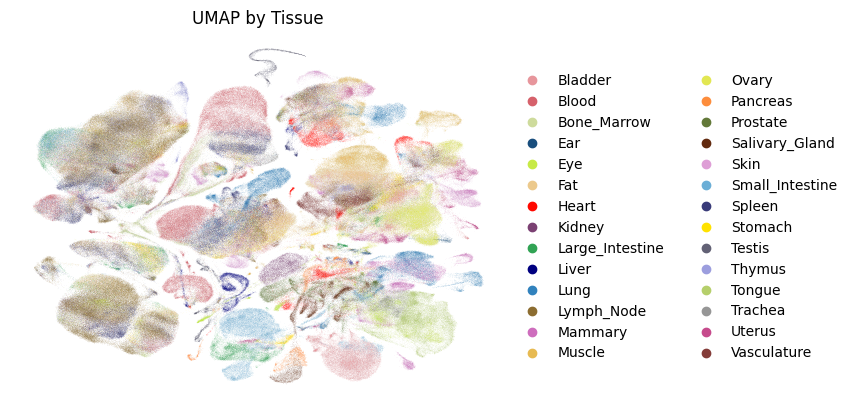

In [189]:
sc.pl.umap(
    adata,
    color='tissue_in_publication',
    legend_loc='right margin',  # or 'right margin' for large datasets
    size=0.1,  # reduce for large datasets
    title='UMAP by Tissue',
    frameon=False
)


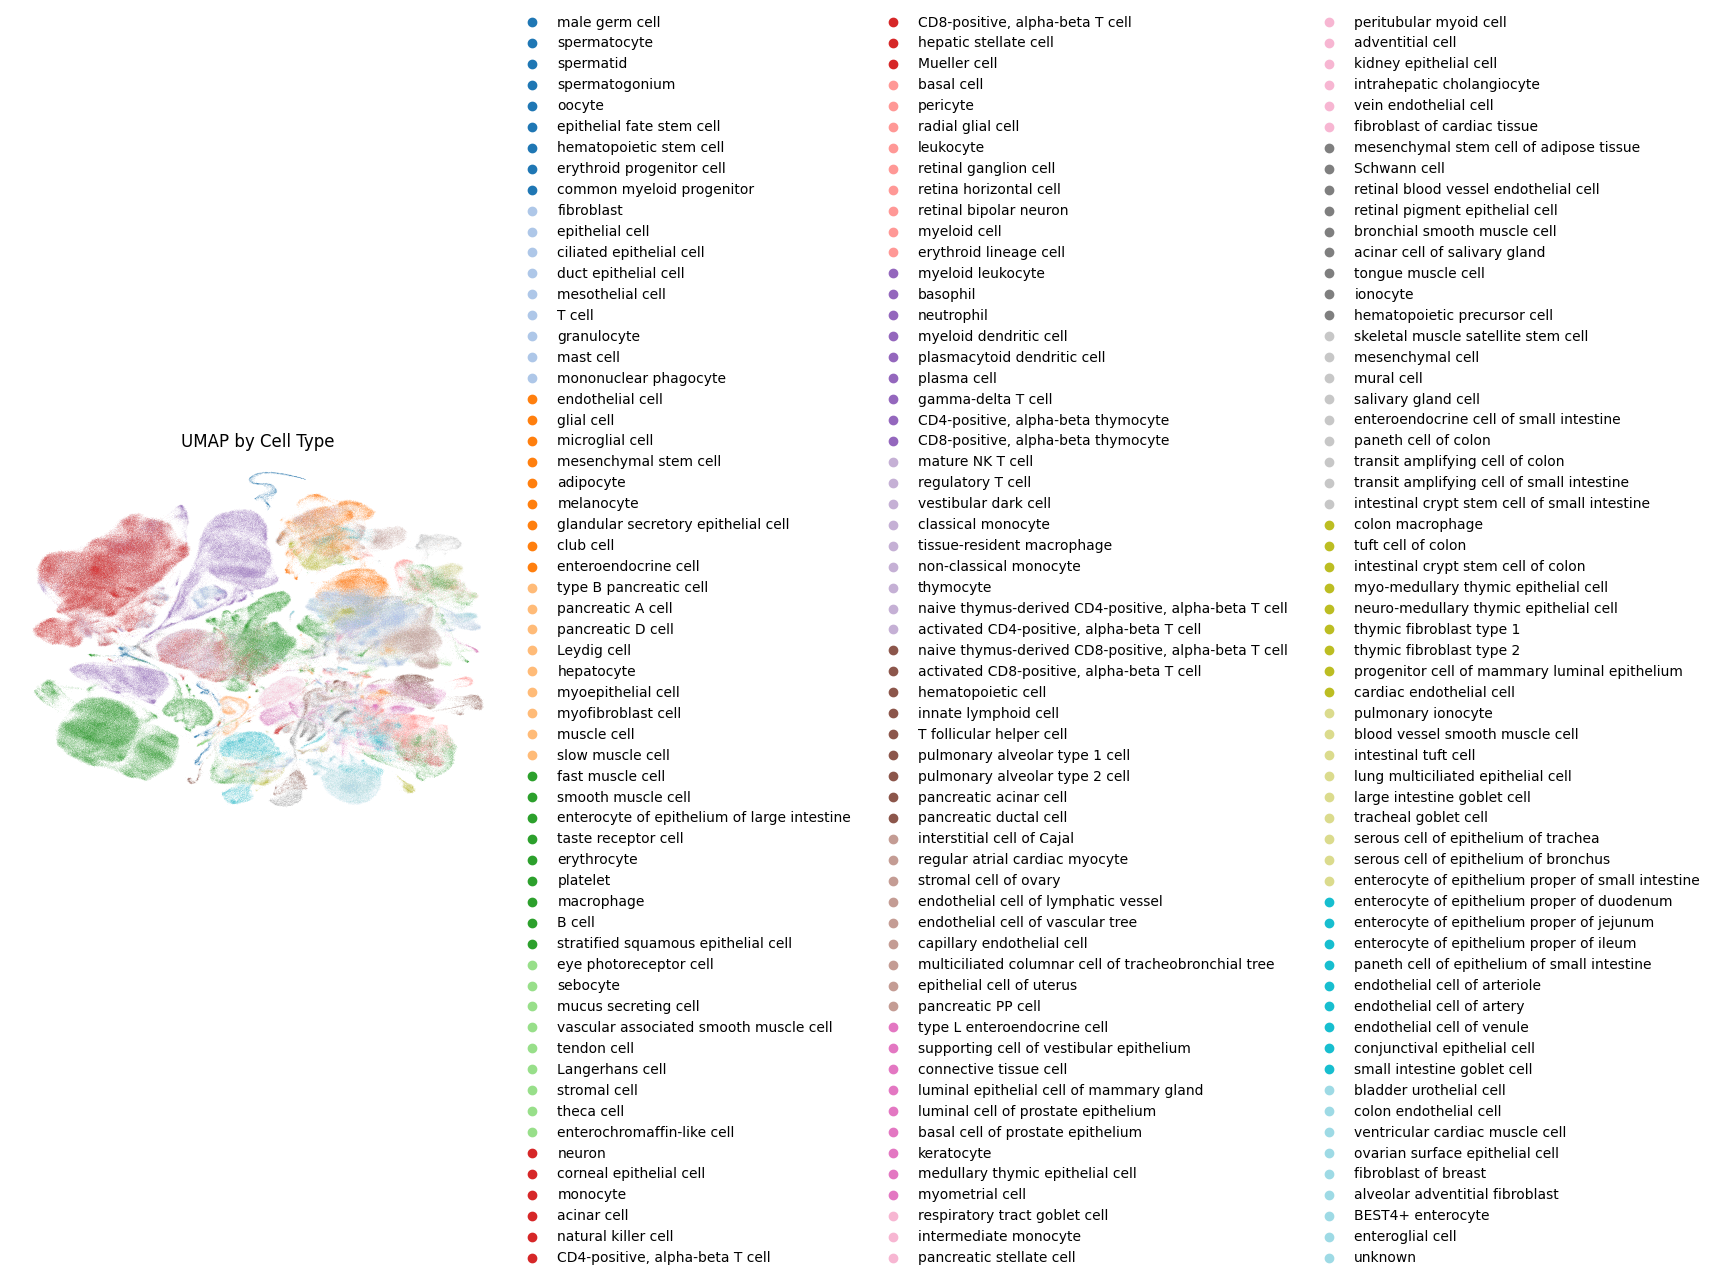

In [56]:
sc.pl.umap(
    adata,
    color='cell_type',
    legend_loc='right margin',  # or 'right margin' for large datasets
    size=0.1,  # reduce for large datasets
    title='UMAP by Cell Type',
    frameon=False
)
